# SRCNN - architecture search
This notebook implements the super-resolution convolutional neural network, SRCNN, as described by [Dong *et al.*](https://link.springer.com/chapter/10.1007/978-3-319-10593-2_13).

The notebook will cover the $2\times$ scaling factor.

## Summary
Results from this notebook are summarized in full at the end of the notebook. Using $32 \times 32$ training patches and a scaling factor of 2, image patch stride of 14, training batch size of 32 with 300 epochs, training took roughly 5 to 17 minutes on a GTX 1080 Ti (depending on architecture). There were no major improvements over the base model (9-5-64-32-1). However, minor improvements were found near the basic structure, suggesting that either the current structure is nearly optimal (inasmuch as it adheres to this small form factor, there are of course much better architectures) or that the limit of performance is the data. The below table summarizes the small improvemetns found.

| $f_1$ | $f_3$ | $n_1$ | $n_2$ | number of 1$\times$1 layers | Mean PSNR over Set14 |
| :---: | :---: | :---: | :---: | :-------------------------: | :------------------: |
| 9 | 5 | 64 | 32 | 1 | 24.33 dB |
| 9 | 7 | 64 | 32 | 1 | 24.38 dB |
| 9 | 7 | 128 | 64 | 1 | 24.37 dB |
| 9 | 5 | 64 | 32 | 4 | 24.37 dB |
| 9 | 5 | 256 | 64 | 1 | 24.36 dB |
| 13 | 7 | 64 | 32 | 4 | 24.36 |
| 9 | 7 | 64 | 64 | 1 | 24.35 |
| 13 | 7 | 128 | 128 | 1 | 24.34 |
| 13 | 7 | 64 | 64 | 1 | 24.34 |
| 13 | 7 | 256 | 64 | 4 | 24.34 |
| 9 | 7 | 256 | 32 | 8 | 24.34 |
| 9 | 5 | 64 | 64 | 8 | 24.34 |
| 9 | 7 | 64 | 32 | 4 | 24.34 |

This architecture seems to favor smaller filter sizes in one or both $f_1$ and $f_3$, and small number of 1$\times$1 nonlinear layers. Adding more filters beyond 64 does not seem to improve performance.

In [1]:
# Imports.
import numpy as np
import pandas as pd
from PIL import Image

import site
site.addsitedir('../')
from srcnn_tf2.data.preprocessing import create_xy_patches, import_from_file, scale_batch, center_crop
from srcnn_tf2.data.plotting import n_compare
from srcnn_tf2.model.srcnn_model import SRCNN

# Data locations.
training_folder = '../../../sr_data/T91'
set5_eval_folder = '../../../sr_data/Set5'
set14_eval_folder = '../../../sr_data/Set14'

---
## Import and preprocess training data
High-resolution target images, $I_y$, are 32 x 32 pixel sub-images extracted from the original T91 image set. This is done by passing a 32 x 32 pixel window over the originals at a stride of 14 pixels. Target images are then given a Gaussian blur and downscaled by the scaling factor to produce the low-resolution input images, $I_x$. Pre-upscaling for the model is performed as part of the model class. 

**Note** that applying the blur after the downscale produces better numerical and visual results on the images that are downscaled for validation (e.g. Set5 and Set14). However, applying the blur before downscaling, as in the paper, while returning seemingly worse numerical and visual results on the validation set, produces far more realistic images when tested on CIFAR-10.

To avoid edge effects of convlution, padding in the model is set to `'valid'`, and $I_y$ images are center cropped to remove the edge, forcing the loss function to compare only the central $20 x 20$ section of the image.

Note that the number of training images found here under 32 x 32 image size and 14 pixel stride is $22,623$, which is slightly less than the $24,800$ images obtained in the original paper. We have used a stride of 14 pixels in both $x-$ and $y-$directions, as we believe the original paper has, but have not identified another source of discrepancy. Minimum accepted stride is $1$, so we do not discard any pixels at the end of an image if 14 does not divide into the image size evenly.

In [2]:
# Data options.
# Note: 'scaling_factor' should evenly divide into 'y_image_size'.
y_image_size = (32, 32)  # Target image size, patches extracted from T91 inputs.
scaling_factor = 2
patch_stride = 14
blur_kernel = -1

# Data extraction.
xdata, ydata = create_xy_patches(training_folder,
                                 scaling_factor,
                                 patch_size=y_image_size,
                                 patch_stride=patch_stride,
                                 blur_kernel=blur_kernel,
                                 rotations=[0], swap_channels=False)
print(f"Target data size (number of images x image shape x channels): {ydata.shape}")
print(f"Training data input size (number of images x image shape x channels): {xdata.shape}")

Target data size (number of images x image shape x channels): (22623, 32, 32, 3)
Training data input size (number of images x image shape x channels): (22623, 16, 16, 3)


## Define and train models
### Define model architectures
Models are defined in a loop, using a range of parameters. Here we do a grid search across the filter sizes, as well as the number of filters and non-linear layers. Constraints on architecture are based on those found in the paper, where $n_2 \leq n_1$ and $f1 \leq f_3$.

In [3]:
# Model architectures are defined in a list of tuples, containing:
#     (f1, f3, n1, n2, nlin_layers)

f1_range = [17]
f3_range = [5, 11]
n1_range = [32, 64, 256]
n2_range = [16, 32, 128]
nlin_range = [1, 4, 8]

arch_list = []

for f1_i in f1_range:
    for f3_i in f3_range:
        for n1_i in n1_range:
            for n2_i in n2_range:
                for nlin_i in nlin_range:
                    if (f3_i <= f1_i) & (n2_i <= n1_i):
                        arch_list.append((f1_i, f3_i, n1_i, n2_i, nlin_i))


### Train model architectures
Specify number of epochs and batch size. Use a small split for running validation, and plot the loss and validation loss.


Model Architecture: (9, 5, 64, 32, 1)
300 epochs completed in 4.0 minutes 12.09 seconds, approx. 0.84 seconds per epoch.


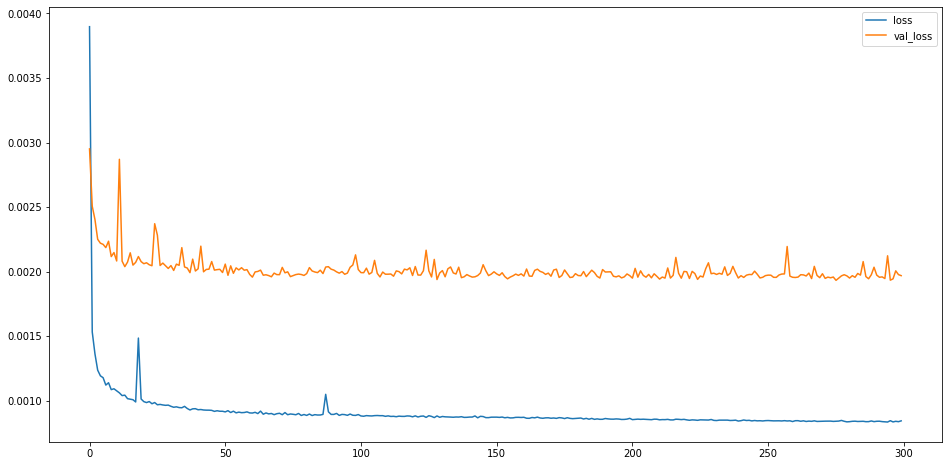

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.5
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.5
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.329

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

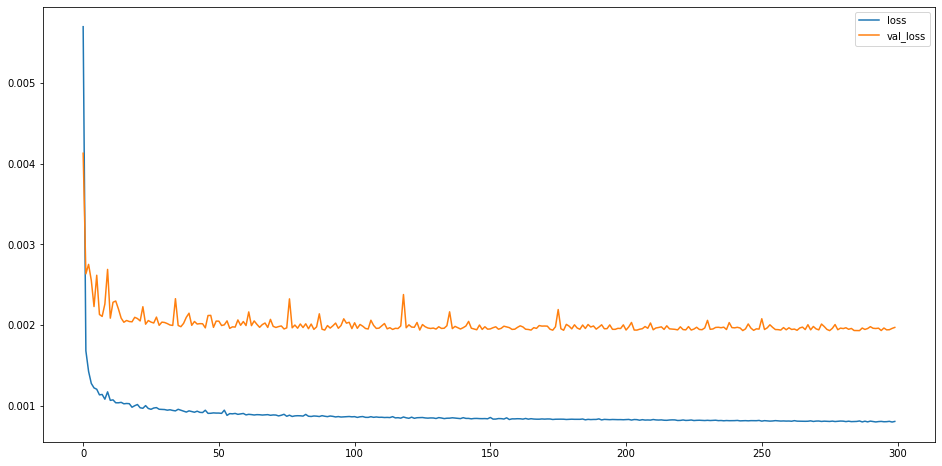

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 28.2
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.7
		5.11. PSNR: 24.1
		5.12. PSNR: 24.3
		5.13. PSNR: 28.1
		5.14. PSNR: 20.6
	Average PSNR: 24.369

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

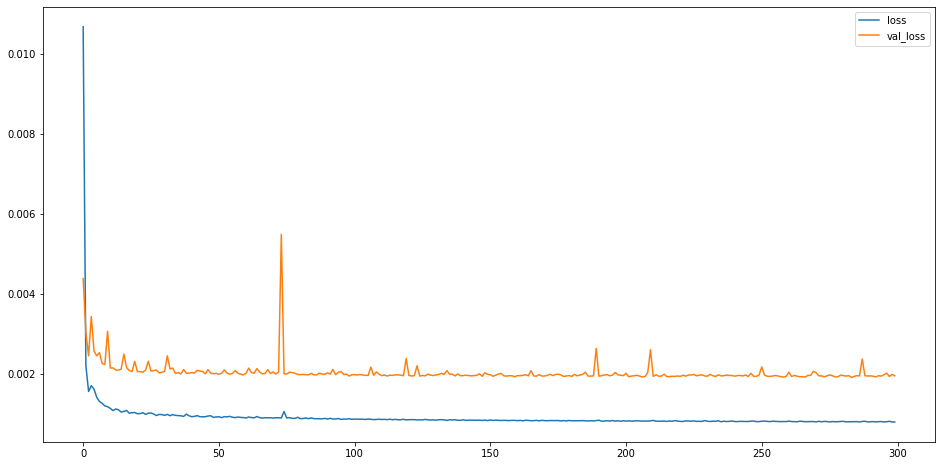

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.6
		5.11. PSNR: 24.0
		5.12. PSNR: 24.1
		5.13. PSNR: 27.9
		5.14. PSNR: 20.7
	Average PSNR: 24.321

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

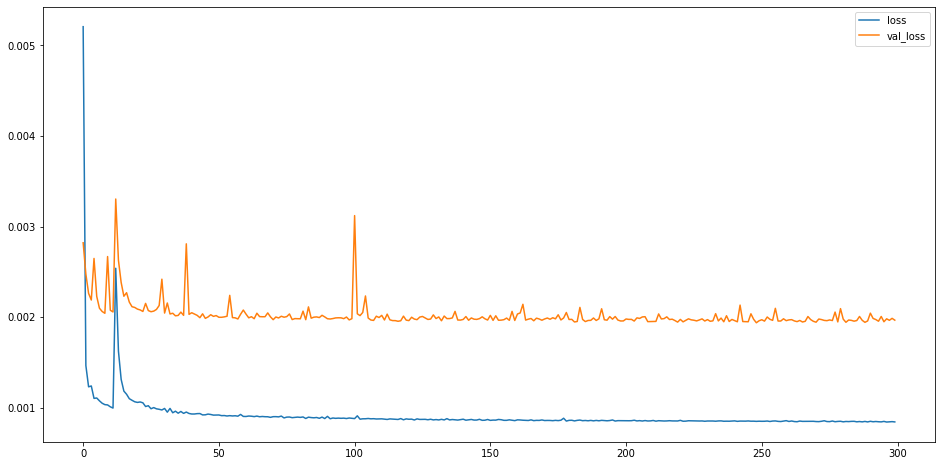

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.8
		5.11. PSNR: 24.1
		5.12. PSNR: 24.5
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.333

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

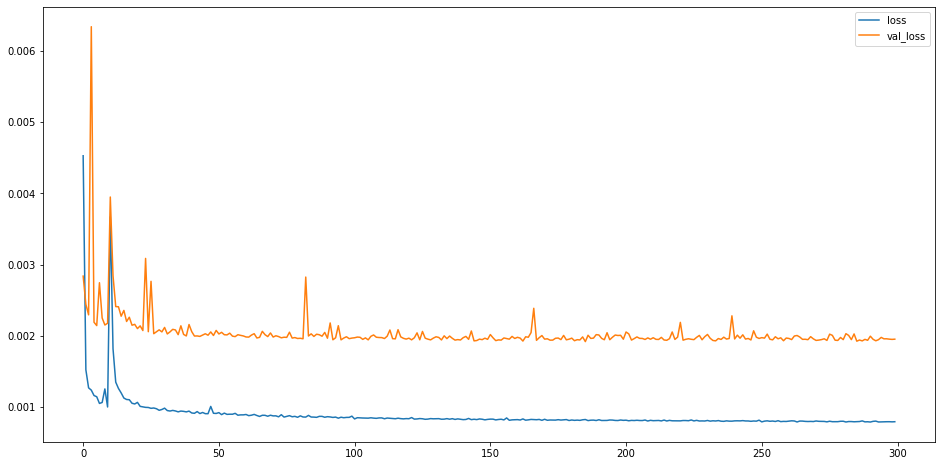

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.8
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.3
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.5
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.314

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

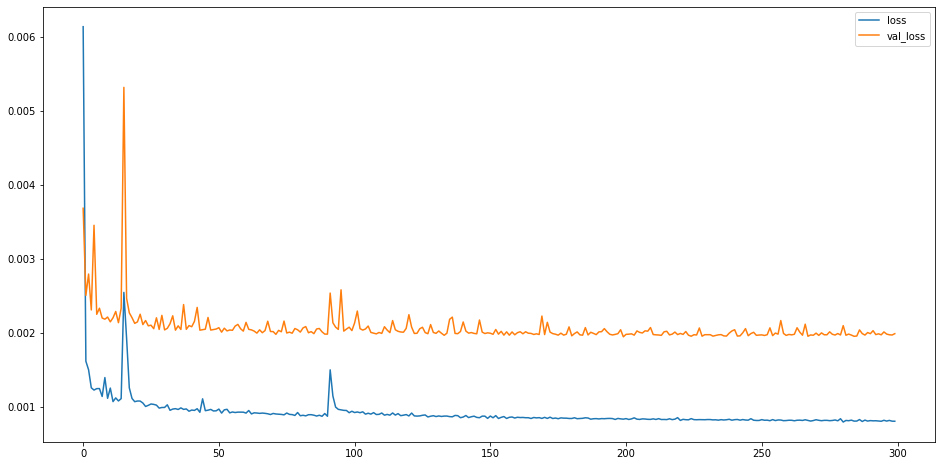

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 27.9
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.2
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.9
		5.11. PSNR: 23.9
		5.12. PSNR: 24.6
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.336

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

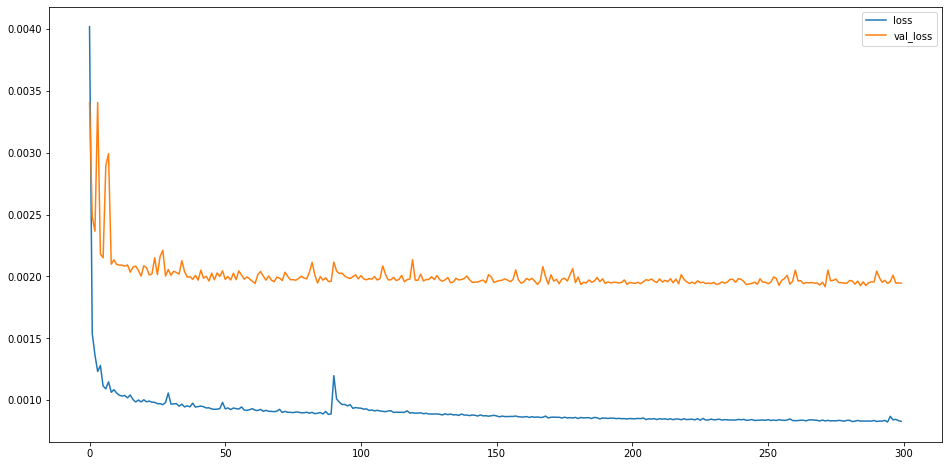

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.6
		5.11. PSNR: 24.0
		5.12. PSNR: 24.3
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.314

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

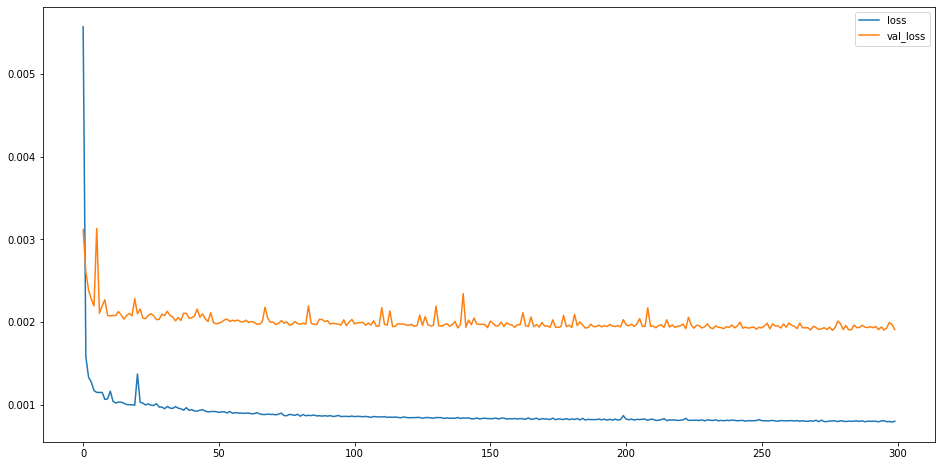

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.7
		5.11. PSNR: 24.1
		5.12. PSNR: 24.1
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.324

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

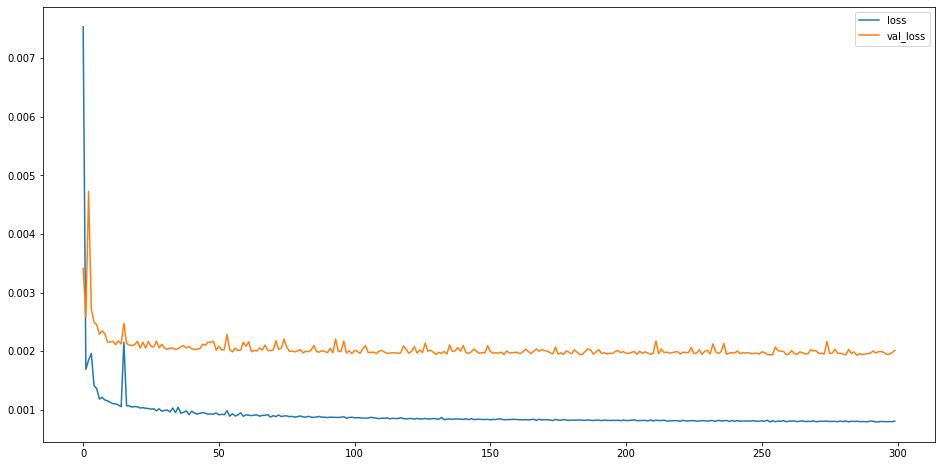

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.1
		5.4. PSNR: 20.2
		5.5. PSNR: 23.4
		5.6. PSNR: 24.6
		5.7. PSNR: 27.1
		5.8. PSNR: 23.4
		5.9. PSNR: 28.4
		5.10. PSNR: 22.4
		5.11. PSNR: 24.0
		5.12. PSNR: 24.7
		5.13. PSNR: 27.7
		5.14. PSNR: 20.4
	Average PSNR: 24.138

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

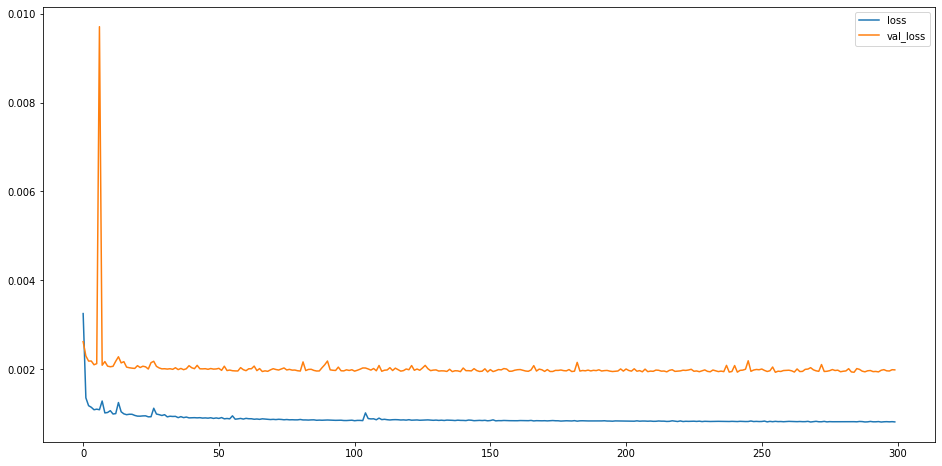

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 28.1
		5.4. PSNR: 20.4
		5.5. PSNR: 23.7
		5.6. PSNR: 24.7
		5.7. PSNR: 28.2
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.1
		5.11. PSNR: 24.1
		5.12. PSNR: 24.3
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.299

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

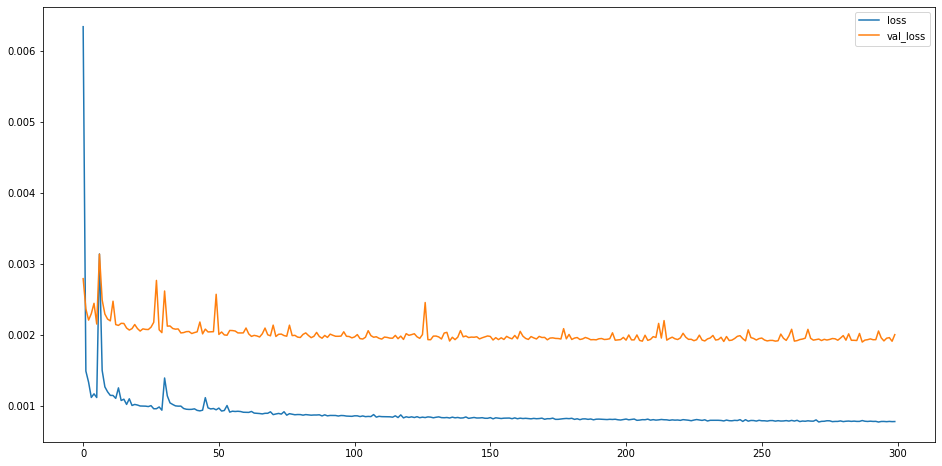

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.8
		5.4. PSNR: 20.5
		5.5. PSNR: 23.8
		5.6. PSNR: 24.7
		5.7. PSNR: 27.8
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 22.1
		5.11. PSNR: 23.8
		5.12. PSNR: 24.7
		5.13. PSNR: 27.7
		5.14. PSNR: 20.5
	Average PSNR: 24.242

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

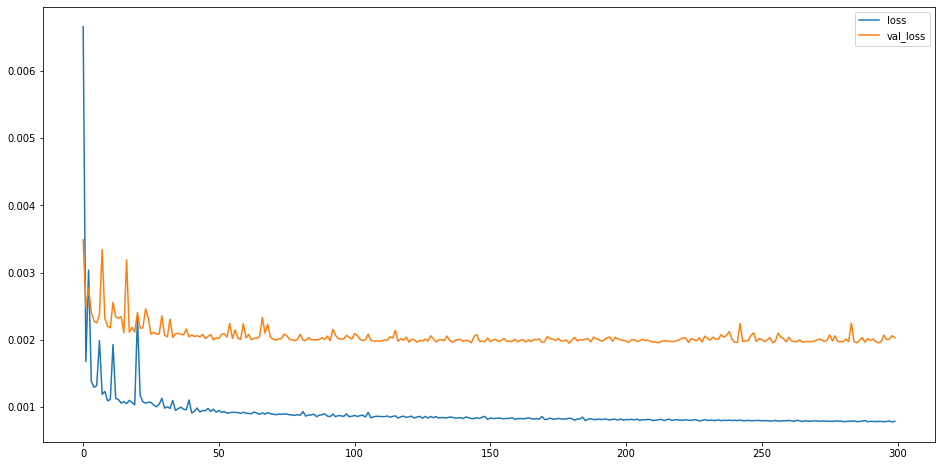

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.7
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.2
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.7
		5.11. PSNR: 23.9
		5.12. PSNR: 24.5
		5.13. PSNR: 27.7
		5.14. PSNR: 20.6
	Average PSNR: 24.269

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

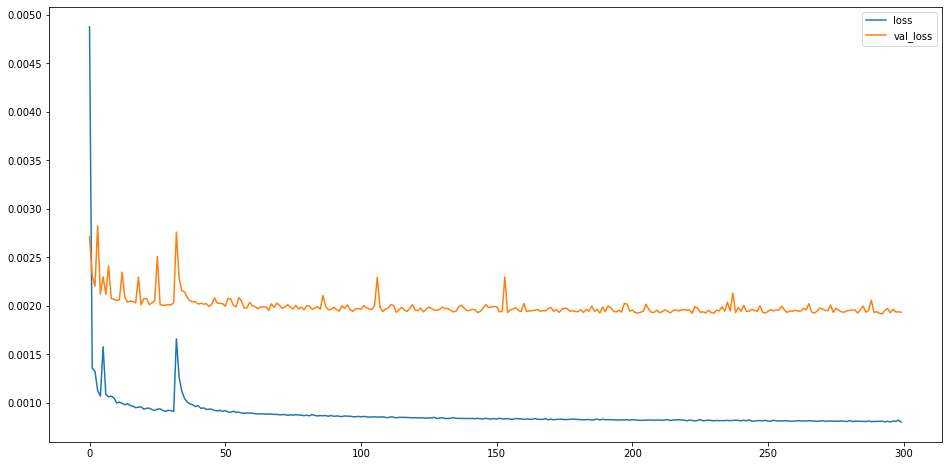

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.6
		5.5. PSNR: 23.9
		5.6. PSNR: 24.8
		5.7. PSNR: 28.2
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 22.1
		5.11. PSNR: 23.9
		5.12. PSNR: 24.6
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.314

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

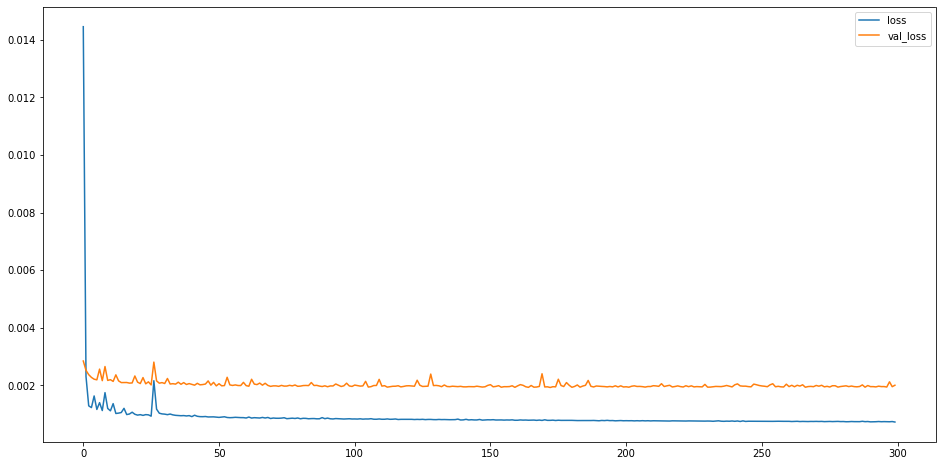

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.4
		5.3. PSNR: 27.8
		5.4. PSNR: 20.9
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.7
		5.9. PSNR: 29.0
		5.10. PSNR: 21.6
		5.11. PSNR: 24.1
		5.12. PSNR: 23.9
		5.13. PSNR: 28.1
		5.14. PSNR: 20.6
	Average PSNR: 24.319

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

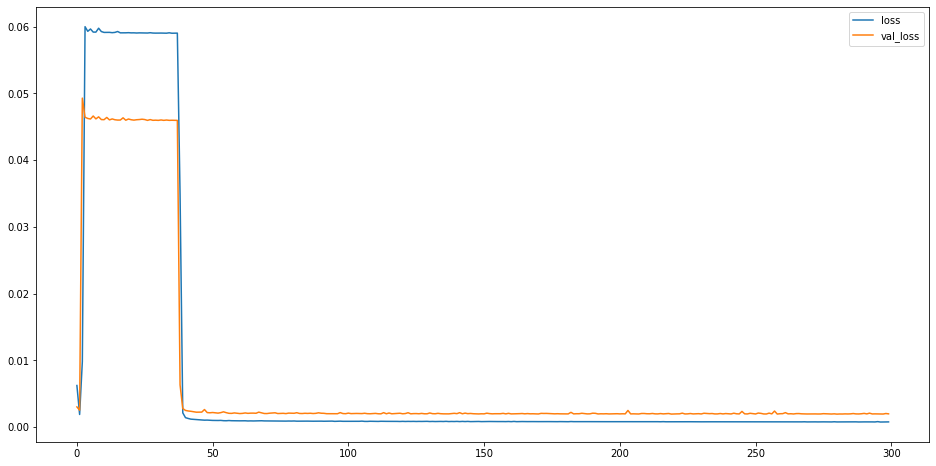

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.7
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.6
		5.11. PSNR: 24.0
		5.12. PSNR: 24.0
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.284

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

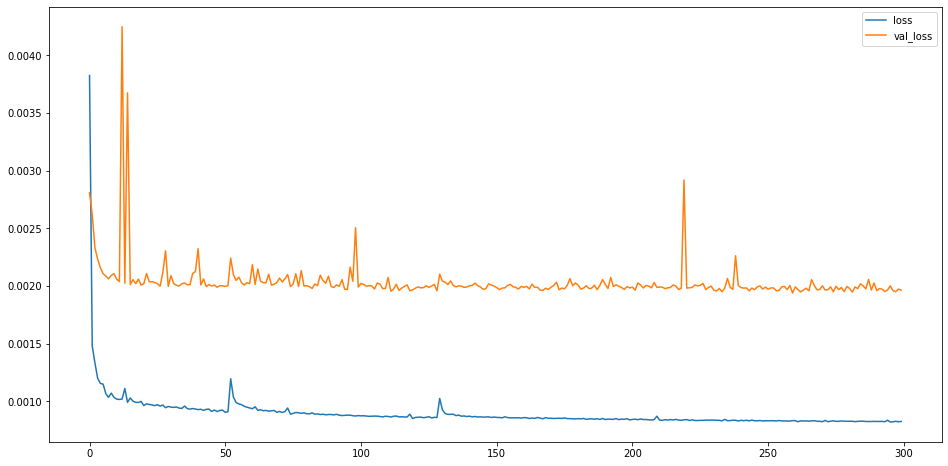

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.7
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.4
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.324

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

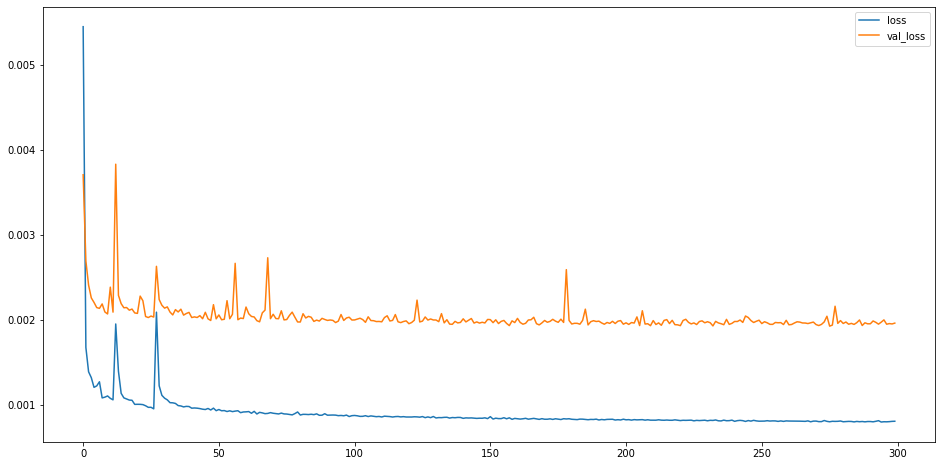

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.9
		5.4. PSNR: 20.6
		5.5. PSNR: 23.6
		5.6. PSNR: 24.7
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.6
		5.11. PSNR: 24.1
		5.12. PSNR: 24.1
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.275

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

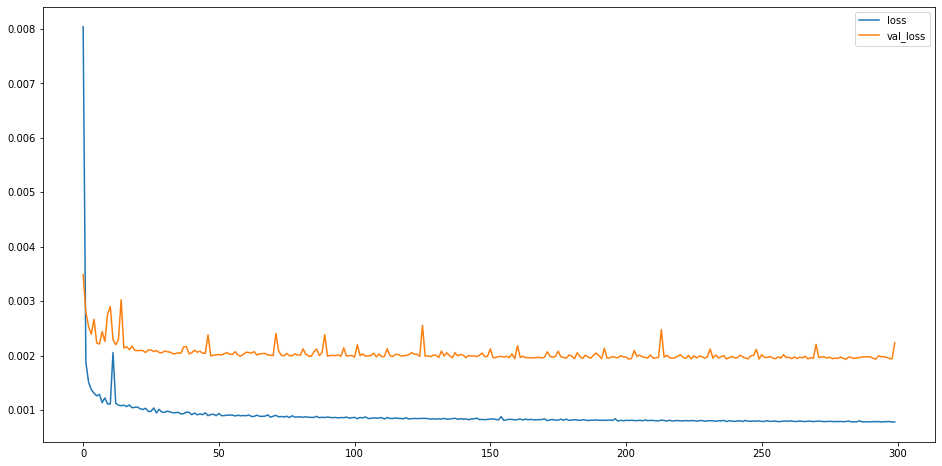

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.5
		5.4. PSNR: 20.5
		5.5. PSNR: 23.5
		5.6. PSNR: 24.7
		5.7. PSNR: 28.2
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.3
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.208

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

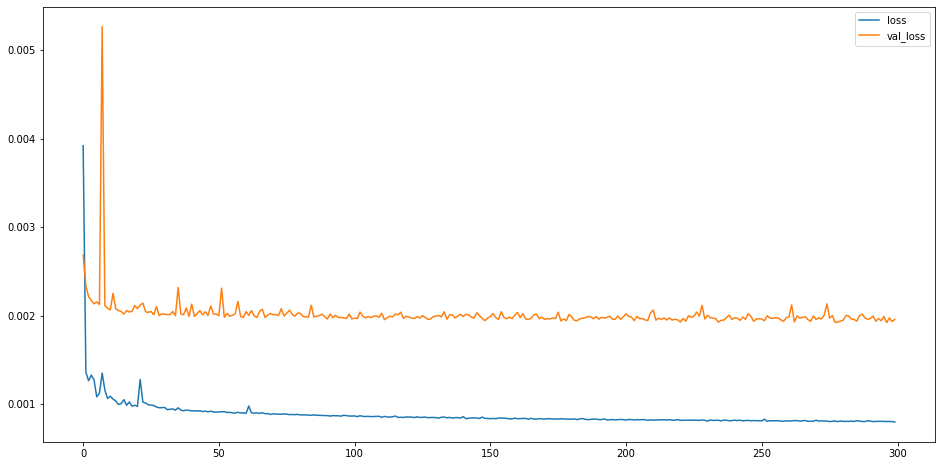

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.2
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.8
		5.11. PSNR: 24.1
		5.12. PSNR: 24.3
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.362

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

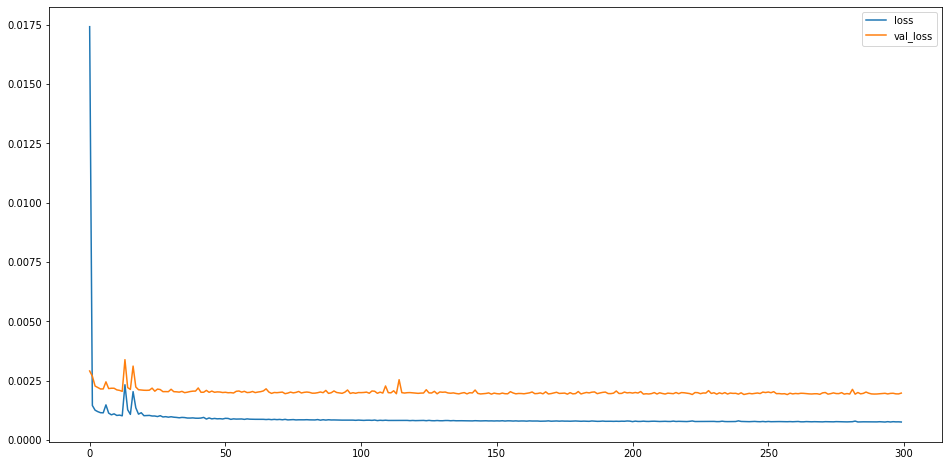

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.6
		5.5. PSNR: 23.4
		5.6. PSNR: 24.7
		5.7. PSNR: 28.2
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.1
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.252

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

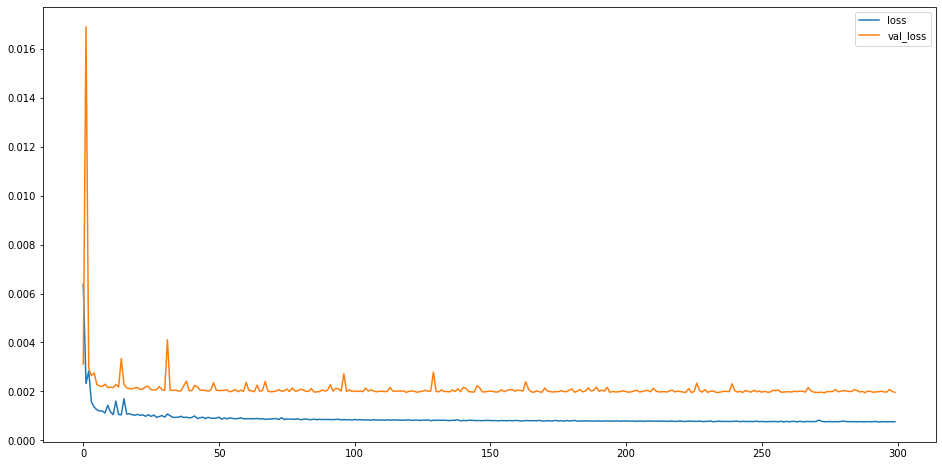

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.7
		5.11. PSNR: 24.1
		5.12. PSNR: 24.4
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.316

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

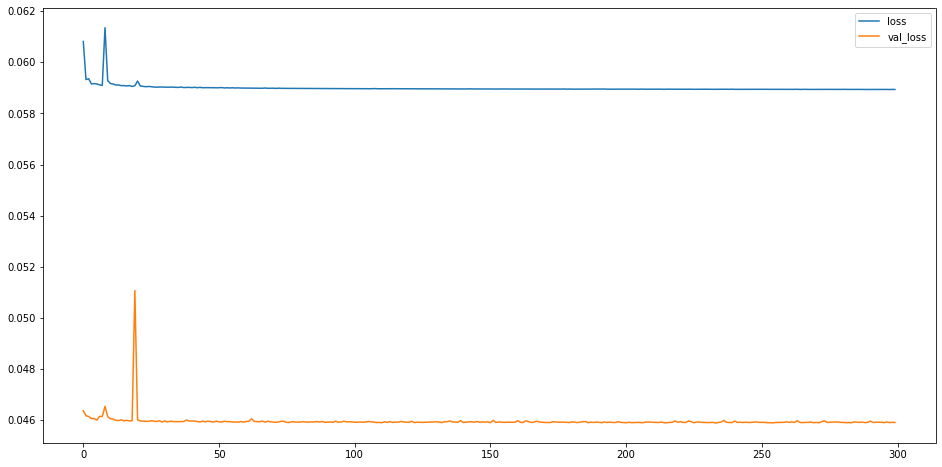

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 11.2
		5.2. PSNR: 13.3
		5.3. PSNR: 14.2
		5.4. PSNR: 6.7
		5.5. PSNR: 11.9
		5.6. PSNR: 10.6
		5.7. PSNR: 8.6
		5.8. PSNR: 10.7
		5.9. PSNR: 13.7
		5.10. PSNR: 12.0
		5.11. PSNR: 12.8
		5.12. PSNR: 13.8
		5.13. PSNR: 11.8
		5.14. PSNR: 9.8
	Average PSNR: 11.502

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.3
		5.2. SSIM: 0.5
		5.3. SSIM: 0.5
		5.4. SSIM: 0.6


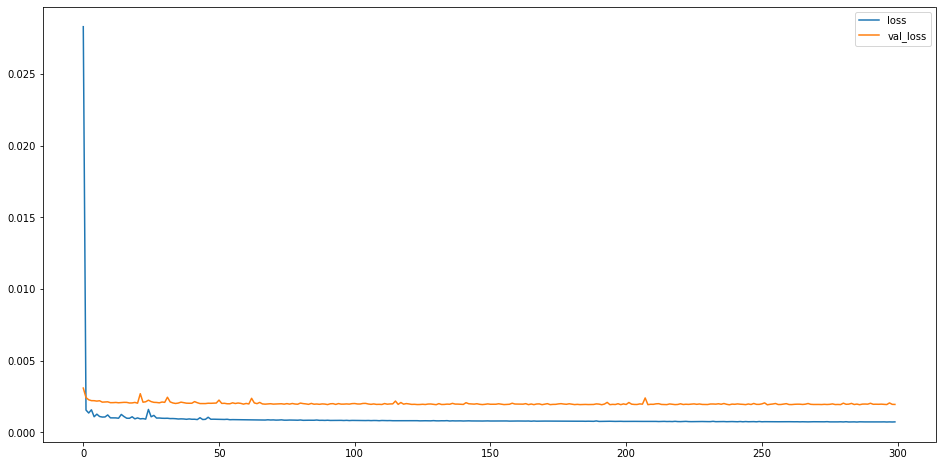

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.6
		5.11. PSNR: 24.1
		5.12. PSNR: 24.0
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.286

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

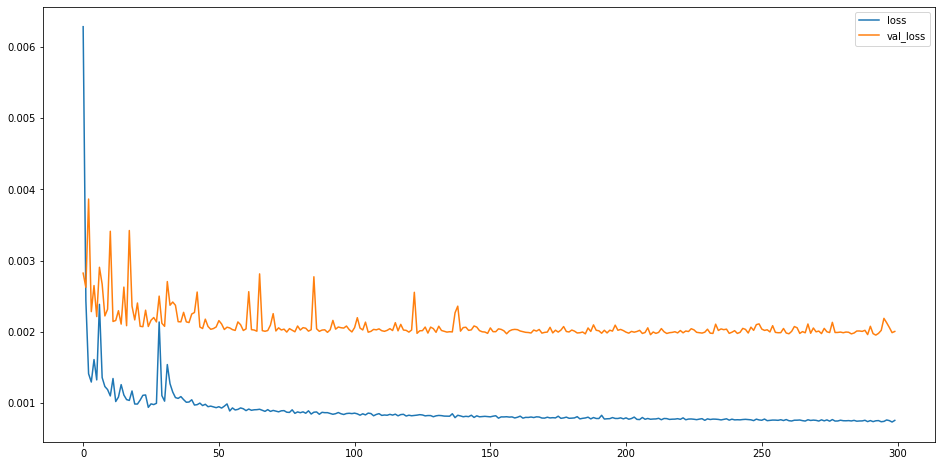

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 27.4
		5.4. PSNR: 20.9
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.7
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 23.8
		5.13. PSNR: 28.0
		5.14. PSNR: 20.7
	Average PSNR: 24.281

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

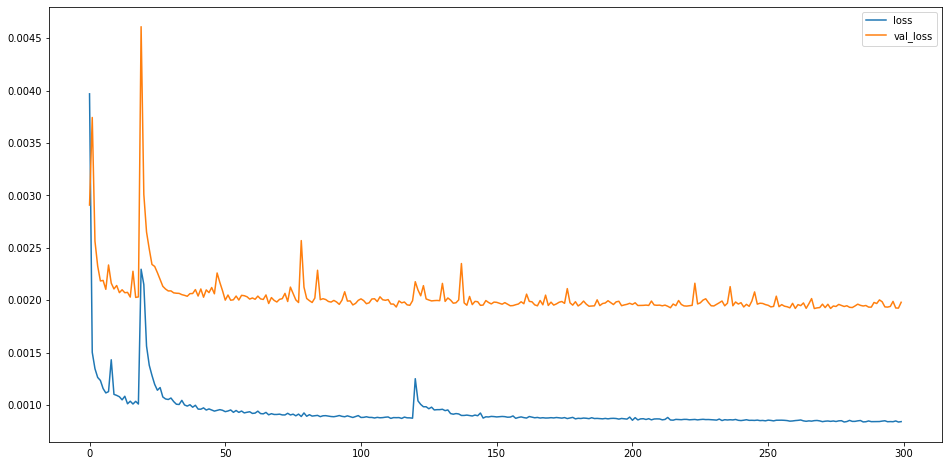

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 28.2
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.1
		5.12. PSNR: 24.6
		5.13. PSNR: 28.1
		5.14. PSNR: 20.6
	Average PSNR: 24.383

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

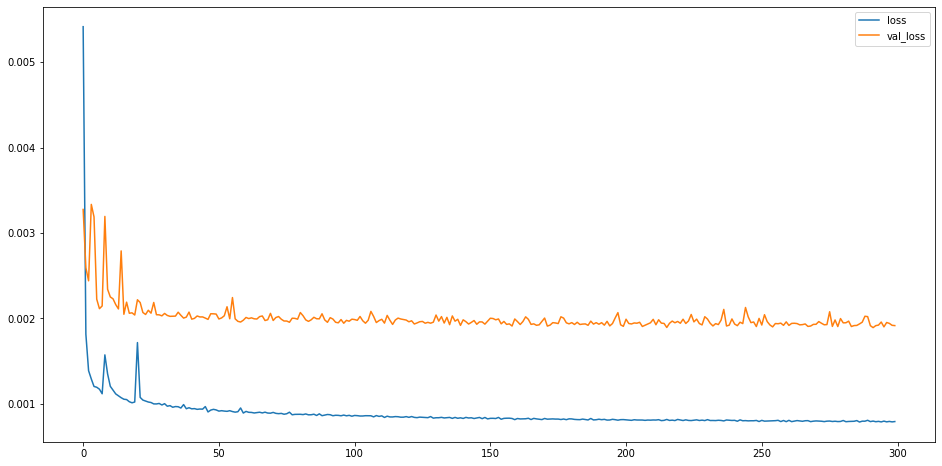

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.6
		5.5. PSNR: 23.8
		5.6. PSNR: 24.9
		5.7. PSNR: 28.3
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.6
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.343

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

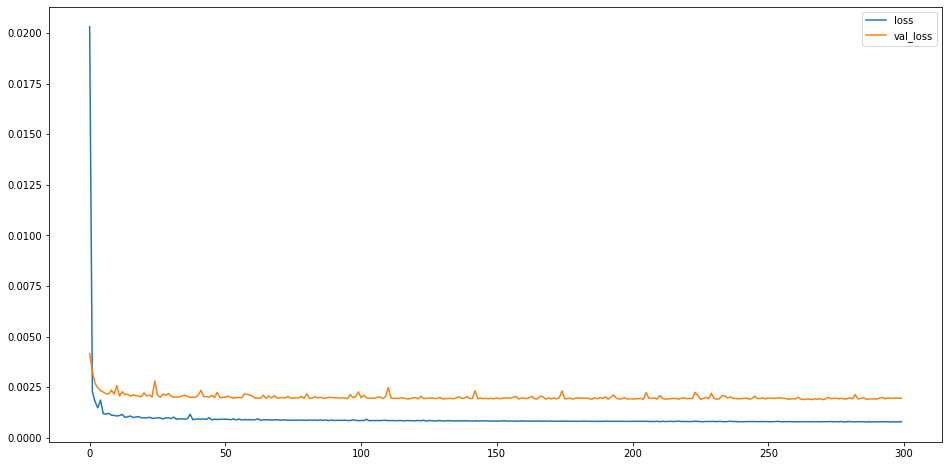

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 27.7
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 23.9
		5.12. PSNR: 24.4
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.294

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

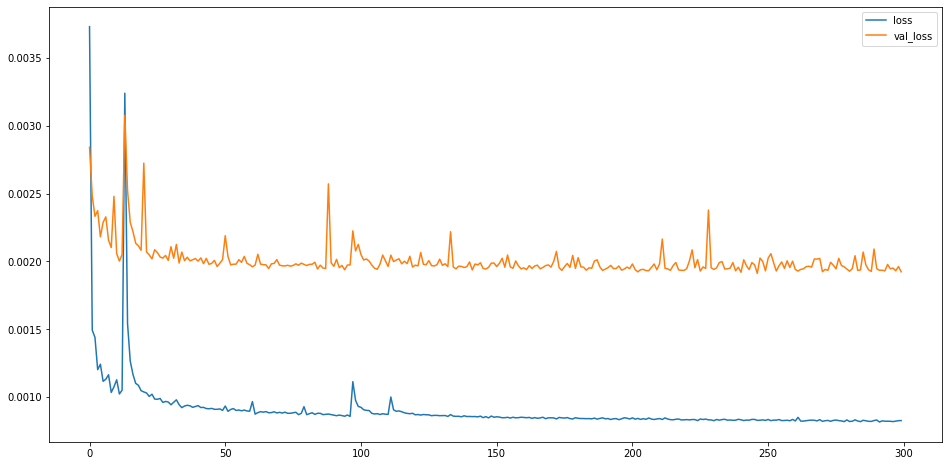

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 22.0
		5.11. PSNR: 24.0
		5.12. PSNR: 24.1
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.349

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

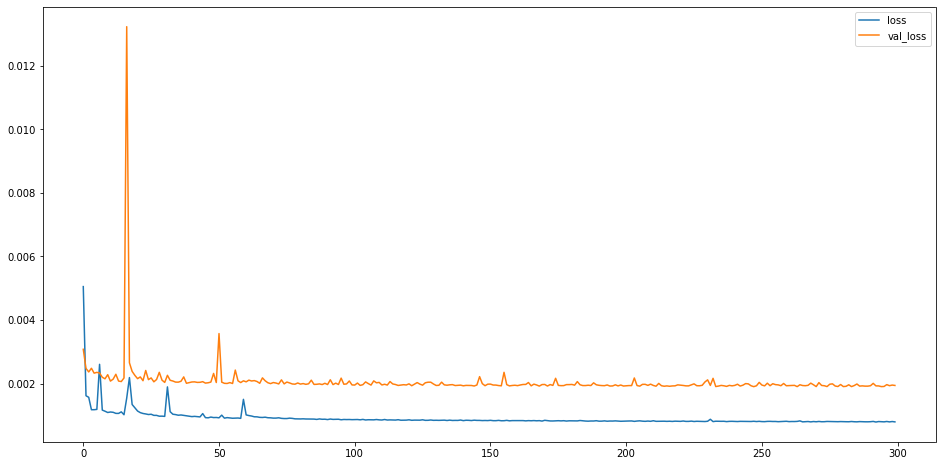

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.2
		5.4. PSNR: 20.3
		5.5. PSNR: 23.7
		5.6. PSNR: 24.7
		5.7. PSNR: 28.0
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.2
		5.11. PSNR: 23.9
		5.12. PSNR: 24.9
		5.13. PSNR: 27.6
		5.14. PSNR: 20.4
	Average PSNR: 24.203

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

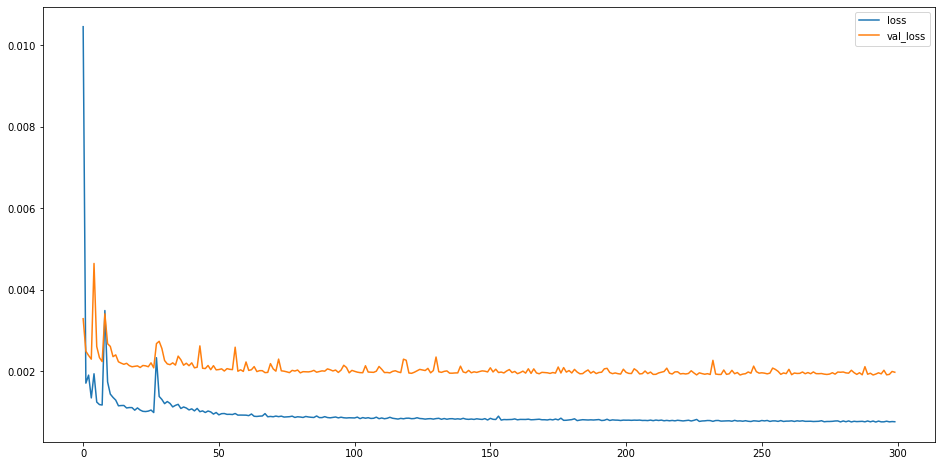

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.3
		5.5. PSNR: 23.5
		5.6. PSNR: 24.8
		5.7. PSNR: 28.2
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 22.3
		5.11. PSNR: 24.0
		5.12. PSNR: 24.5
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.278

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

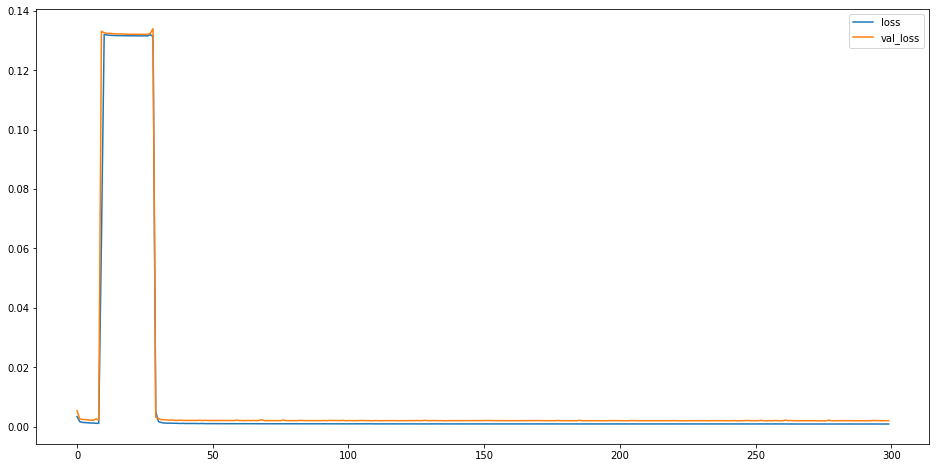

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.0
		5.4. PSNR: 20.5
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.0
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.283

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

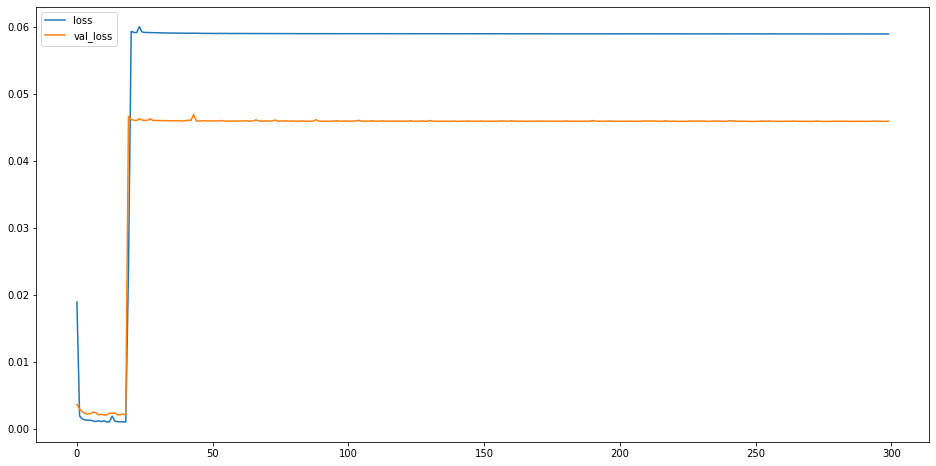

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 11.2
		5.2. PSNR: 13.3
		5.3. PSNR: 14.2
		5.4. PSNR: 6.7
		5.5. PSNR: 11.9
		5.6. PSNR: 10.6
		5.7. PSNR: 8.6
		5.8. PSNR: 10.7
		5.9. PSNR: 13.7
		5.10. PSNR: 12.1
		5.11. PSNR: 12.8
		5.12. PSNR: 13.8
		5.13. PSNR: 11.8
		5.14. PSNR: 9.7
	Average PSNR: 11.502

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.3
		5.2. SSIM: 0.5
		5.3. SSIM: 0.5
		5.4. SSIM: 0.6


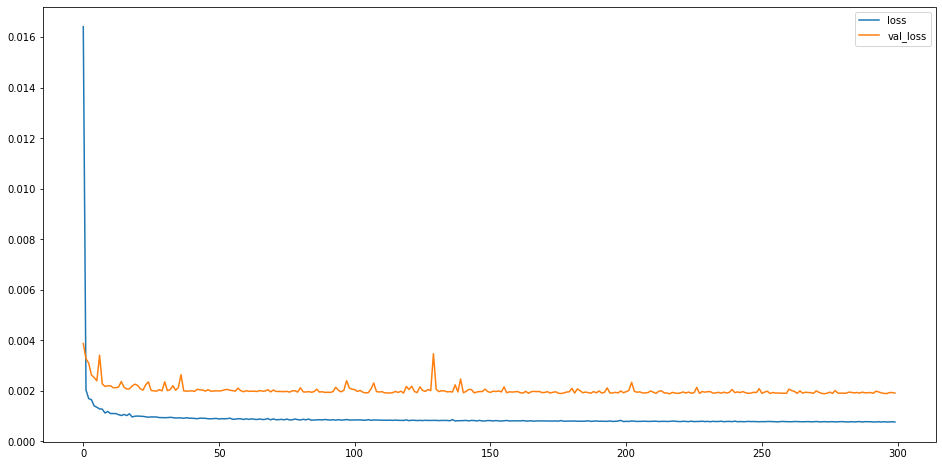

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.7
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.321

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

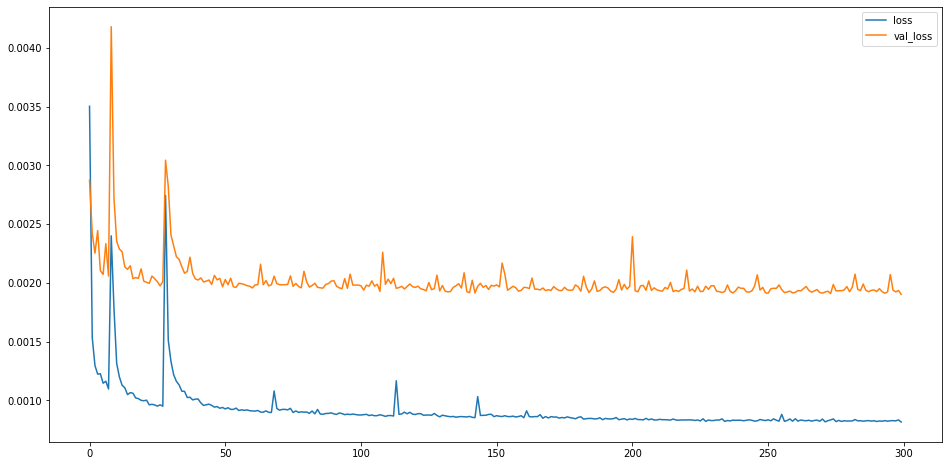

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 28.0
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 22.0
		5.11. PSNR: 24.0
		5.12. PSNR: 24.4
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.367

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

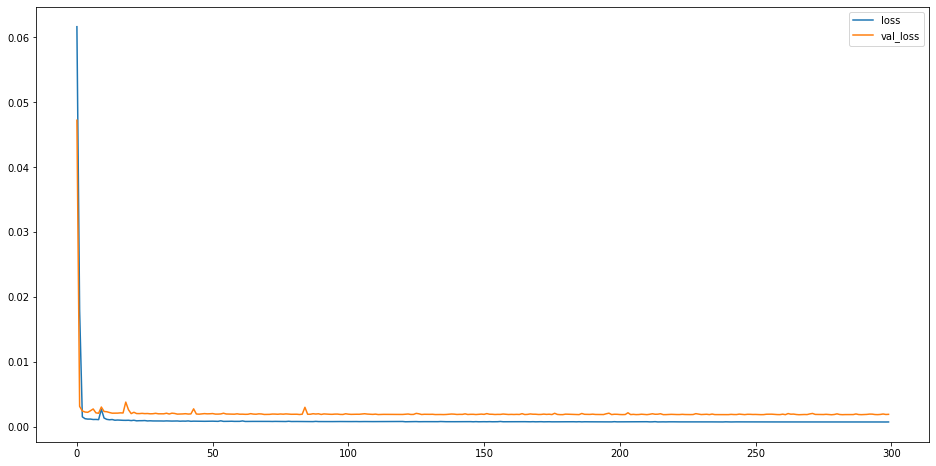

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.5
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 22.1
		5.11. PSNR: 24.0
		5.12. PSNR: 24.5
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.332

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

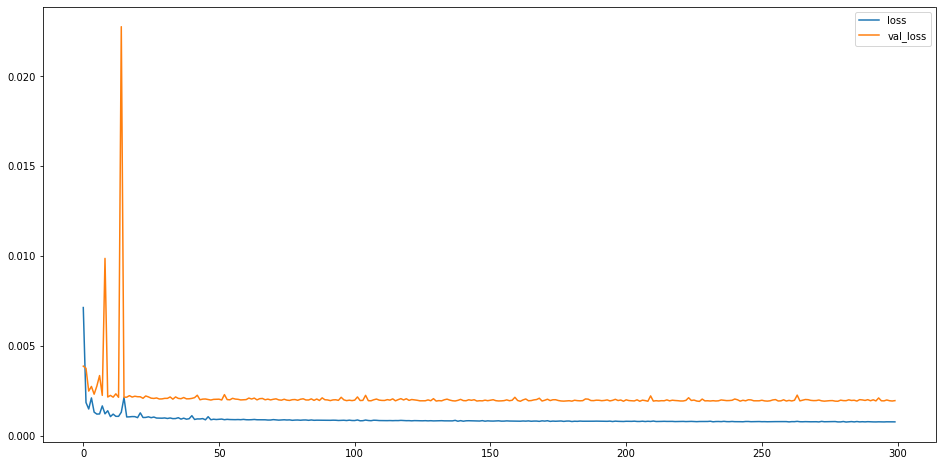

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.8
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 22.0
		5.11. PSNR: 23.8
		5.12. PSNR: 24.1
		5.13. PSNR: 28.0
		5.14. PSNR: 20.5
	Average PSNR: 24.263

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

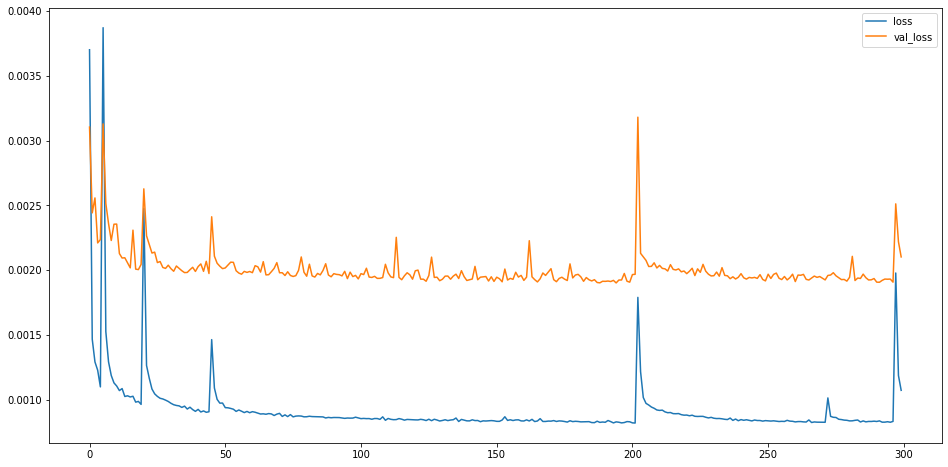

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.8
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.5
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 23.8
		5.12. PSNR: 24.6
		5.13. PSNR: 27.7
		5.14. PSNR: 20.5
	Average PSNR: 24.277

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

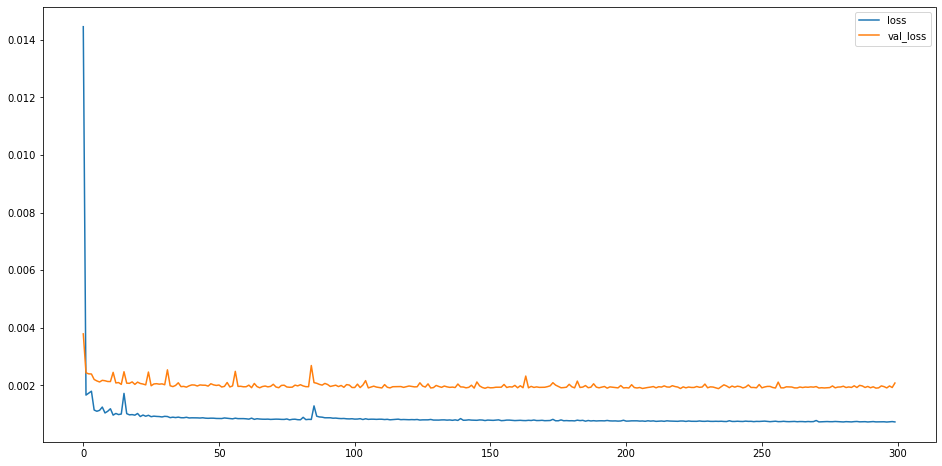

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.0
		5.3. PSNR: 27.6
		5.4. PSNR: 20.0
		5.5. PSNR: 23.0
		5.6. PSNR: 24.6
		5.7. PSNR: 27.0
		5.8. PSNR: 23.3
		5.9. PSNR: 28.5
		5.10. PSNR: 22.5
		5.11. PSNR: 23.9
		5.12. PSNR: 24.2
		5.13. PSNR: 27.5
		5.14. PSNR: 20.3
	Average PSNR: 23.978

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

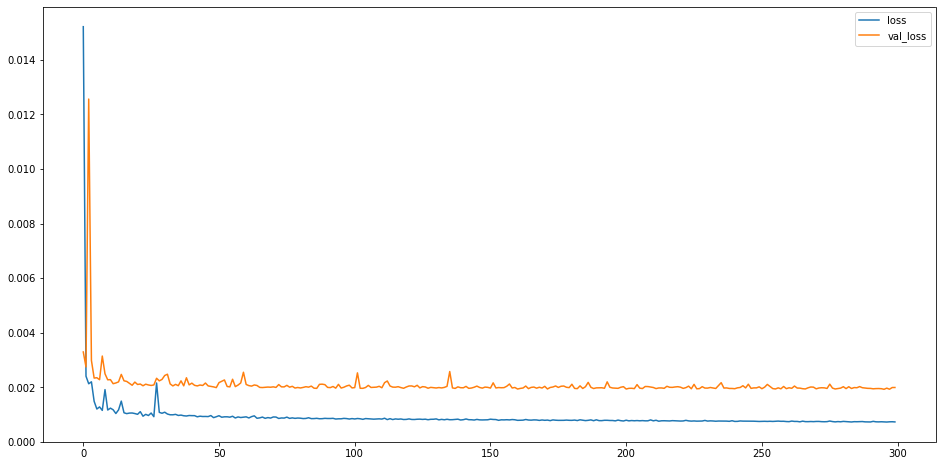

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.6
		5.4. PSNR: 20.5
		5.5. PSNR: 23.5
		5.6. PSNR: 24.8
		5.7. PSNR: 28.3
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.2
		5.11. PSNR: 23.9
		5.12. PSNR: 24.0
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.211

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

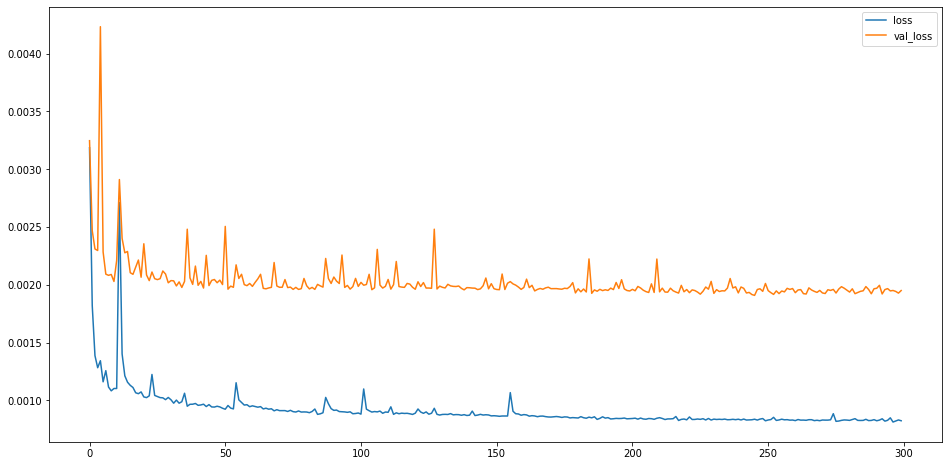

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.9
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.3
		5.8. PSNR: 23.5
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 23.9
		5.12. PSNR: 24.4
		5.13. PSNR: 27.7
		5.14. PSNR: 20.5
	Average PSNR: 24.274

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

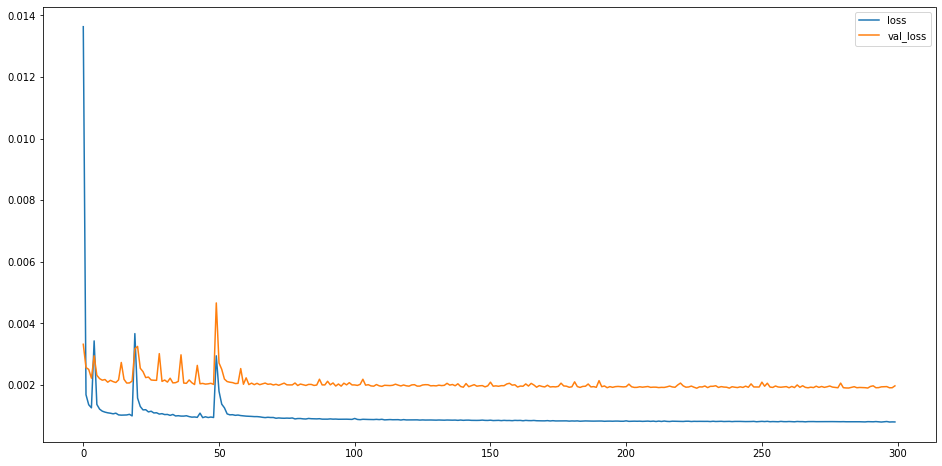

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 27.9
		5.4. PSNR: 20.7
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 23.9
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.270

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

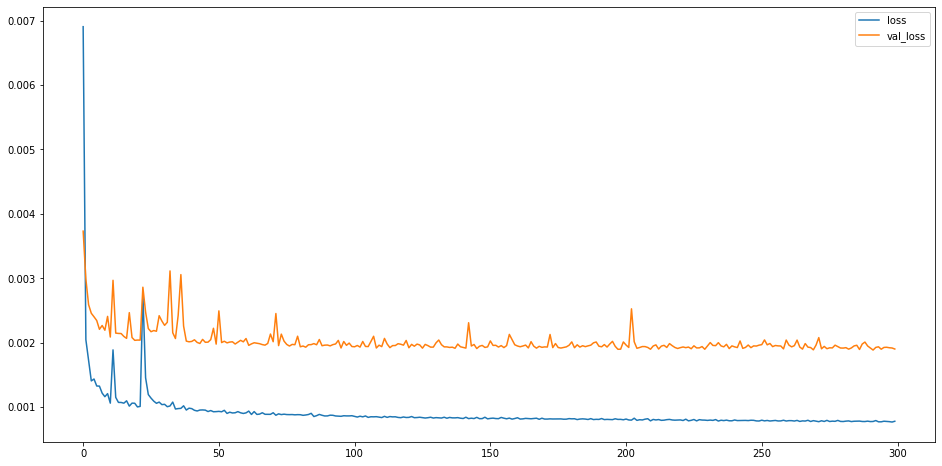

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 27.9
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.9
		5.11. PSNR: 23.9
		5.12. PSNR: 24.3
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.338

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

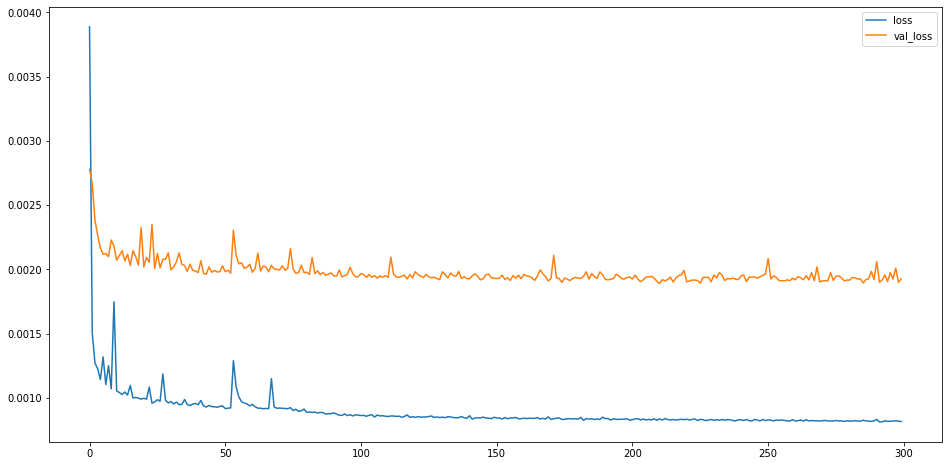

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.5
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.3
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 22.0
		5.11. PSNR: 24.0
		5.12. PSNR: 24.7
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.328

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

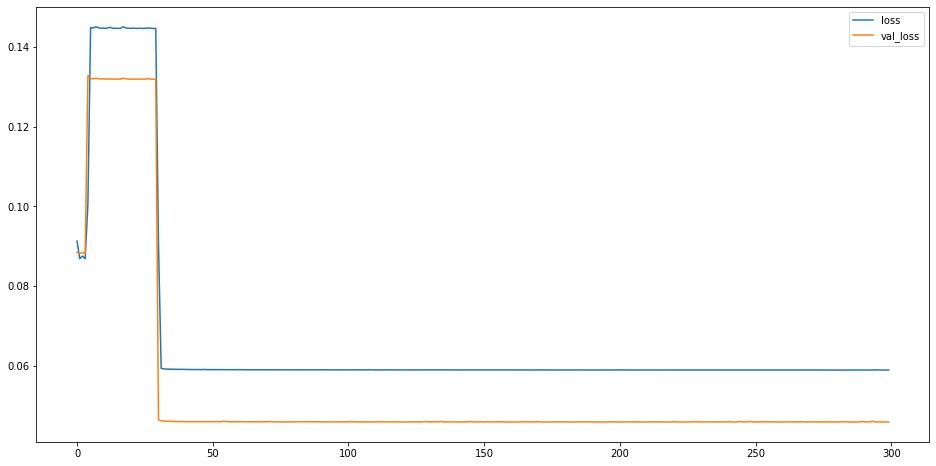

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 11.2
		5.2. PSNR: 13.3
		5.3. PSNR: 14.2
		5.4. PSNR: 6.7
		5.5. PSNR: 11.9
		5.6. PSNR: 10.6
		5.7. PSNR: 8.6
		5.8. PSNR: 10.7
		5.9. PSNR: 13.7
		5.10. PSNR: 12.1
		5.11. PSNR: 12.8
		5.12. PSNR: 13.8
		5.13. PSNR: 11.8
		5.14. PSNR: 9.7
	Average PSNR: 11.499

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.3
		5.2. SSIM: 0.5
		5.3. SSIM: 0.5
		5.4. SSIM: 0.6


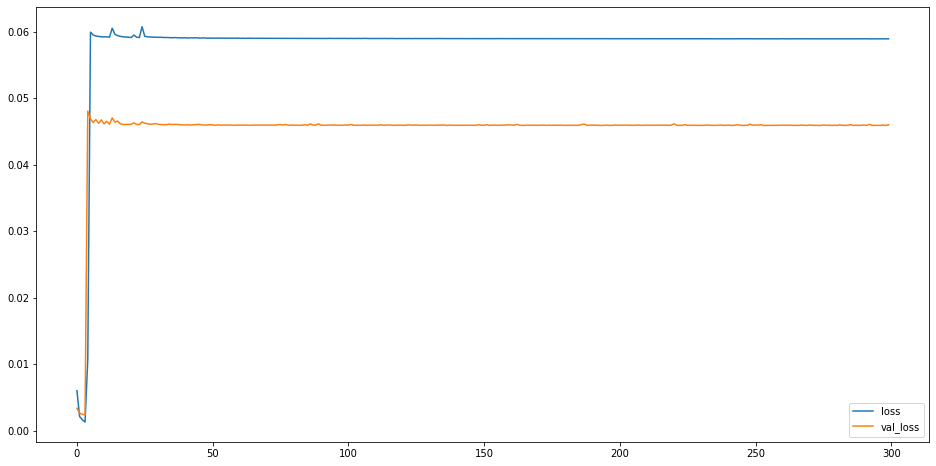

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 11.2
		5.2. PSNR: 13.3
		5.3. PSNR: 14.2
		5.4. PSNR: 6.7
		5.5. PSNR: 11.9
		5.6. PSNR: 10.6
		5.7. PSNR: 8.6
		5.8. PSNR: 10.7
		5.9. PSNR: 13.7
		5.10. PSNR: 12.1
		5.11. PSNR: 12.8
		5.12. PSNR: 13.8
		5.13. PSNR: 11.8
		5.14. PSNR: 9.7
	Average PSNR: 11.498

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.3
		5.2. SSIM: 0.5
		5.3. SSIM: 0.5
		5.4. SSIM: 0.6


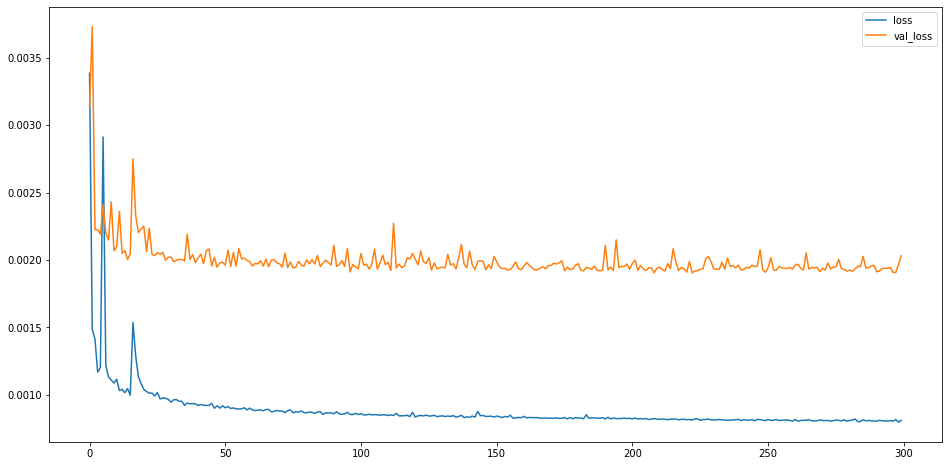

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.7
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.6
		5.13. PSNR: 27.8
		5.14. PSNR: 20.6
	Average PSNR: 24.326

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

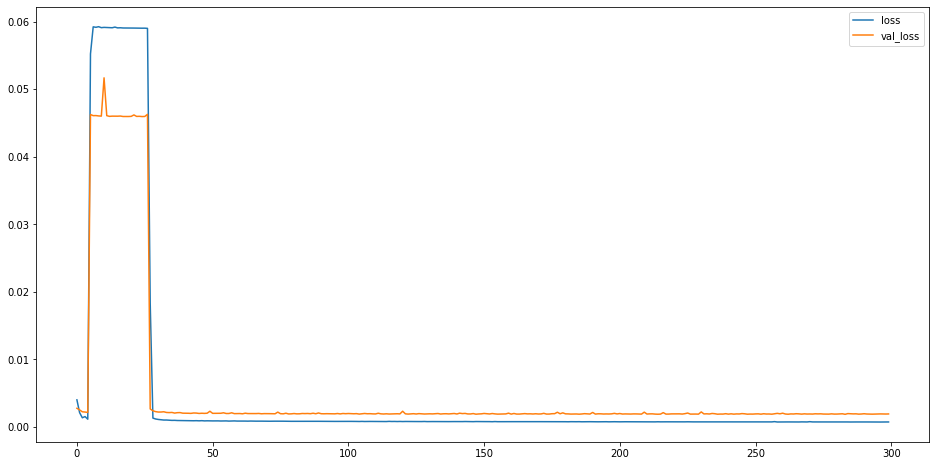

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 27.8
		5.4. PSNR: 20.6
		5.5. PSNR: 23.5
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.0
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.284

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

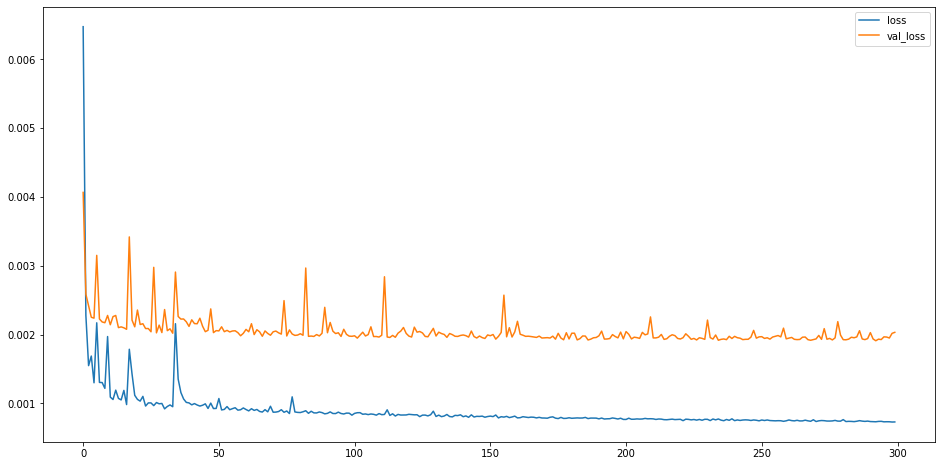

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 27.6
		5.4. PSNR: 19.9
		5.5. PSNR: 23.5
		5.6. PSNR: 24.6
		5.7. PSNR: 26.8
		5.8. PSNR: 23.3
		5.9. PSNR: 28.6
		5.10. PSNR: 22.8
		5.11. PSNR: 23.9
		5.12. PSNR: 23.8
		5.13. PSNR: 28.0
		5.14. PSNR: 20.3
	Average PSNR: 24.027

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

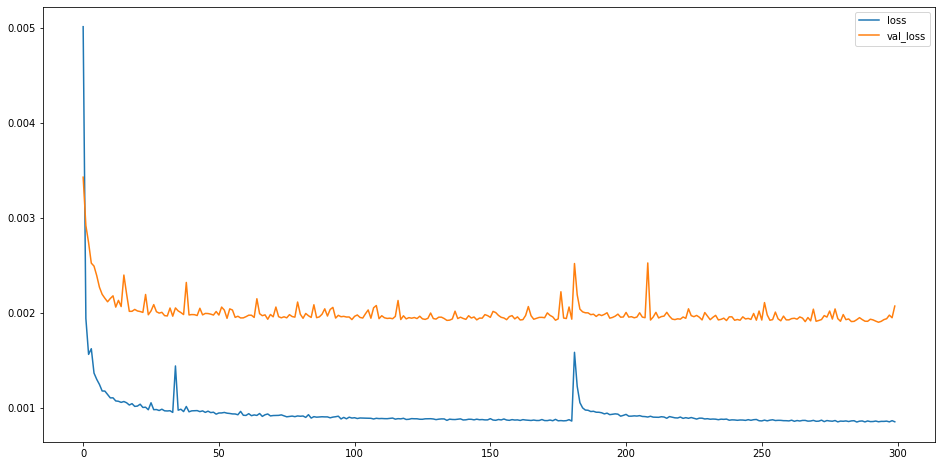

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 27.2
		5.4. PSNR: 20.3
		5.5. PSNR: 23.6
		5.6. PSNR: 24.7
		5.7. PSNR: 27.9
		5.8. PSNR: 23.4
		5.9. PSNR: 28.8
		5.10. PSNR: 22.1
		5.11. PSNR: 23.9
		5.12. PSNR: 23.9
		5.13. PSNR: 27.8
		5.14. PSNR: 20.3
	Average PSNR: 24.111

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

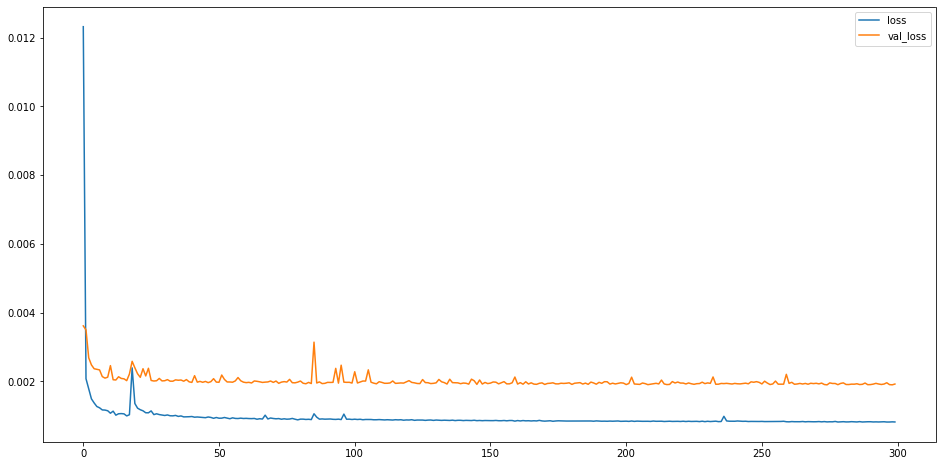

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.6
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.3
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.303

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

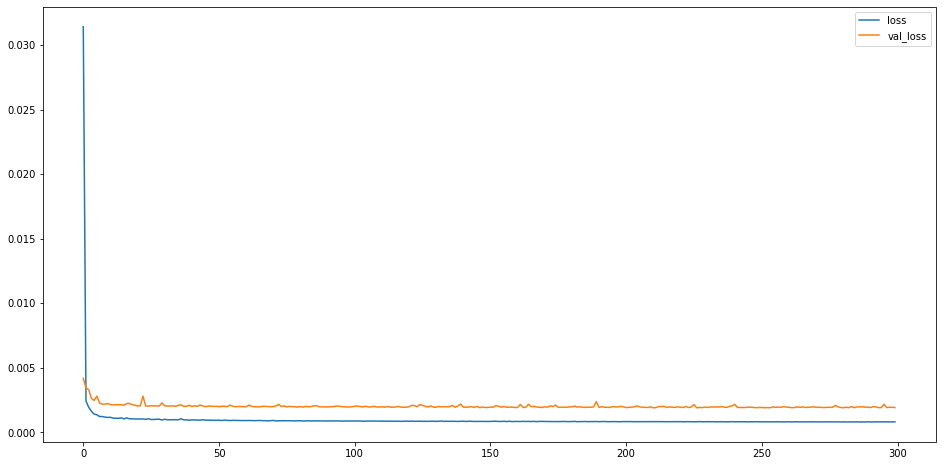

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.7
		5.4. PSNR: 20.9
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.6
		5.11. PSNR: 24.1
		5.12. PSNR: 23.7
		5.13. PSNR: 28.1
		5.14. PSNR: 20.6
	Average PSNR: 24.292

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

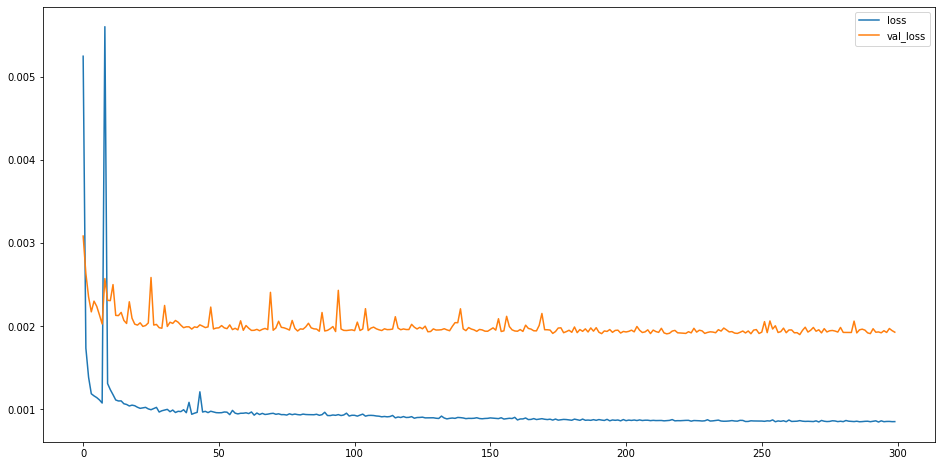

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.5
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.293

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

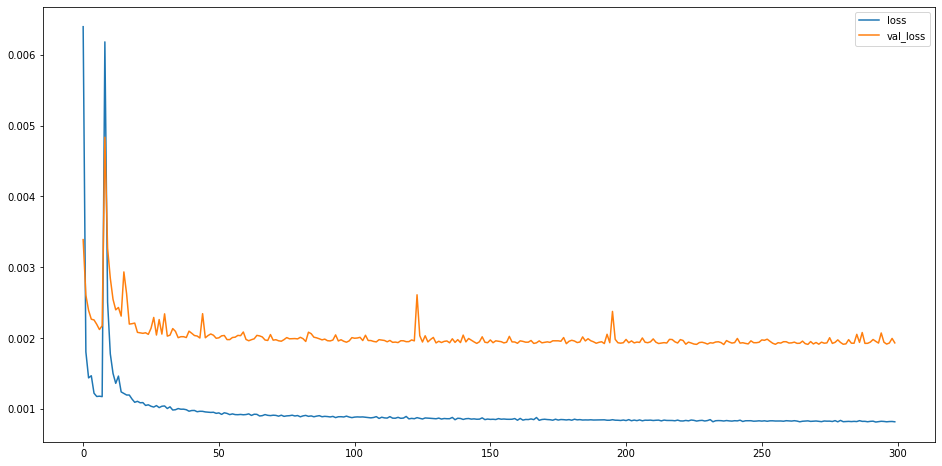

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.7
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.288

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

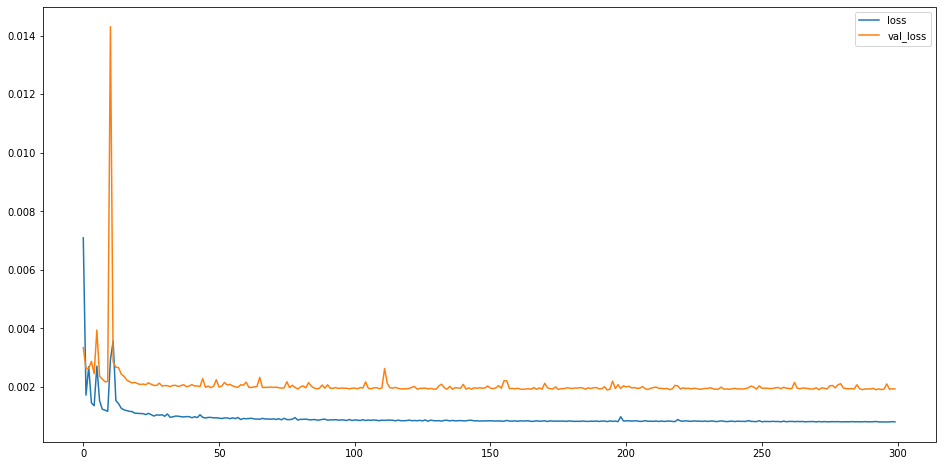

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 27.6
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.8
		5.11. PSNR: 23.9
		5.12. PSNR: 24.3
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.300

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

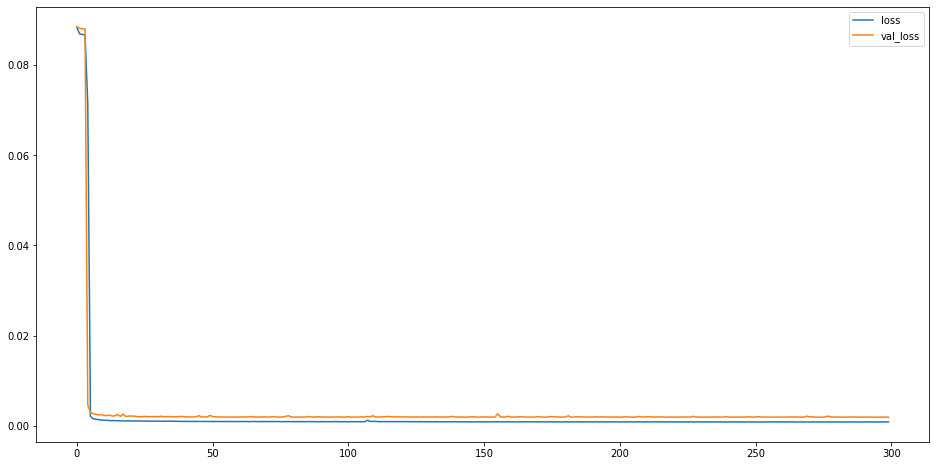

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.7
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 23.9
		5.12. PSNR: 24.2
		5.13. PSNR: 27.8
		5.14. PSNR: 20.6
	Average PSNR: 24.295

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

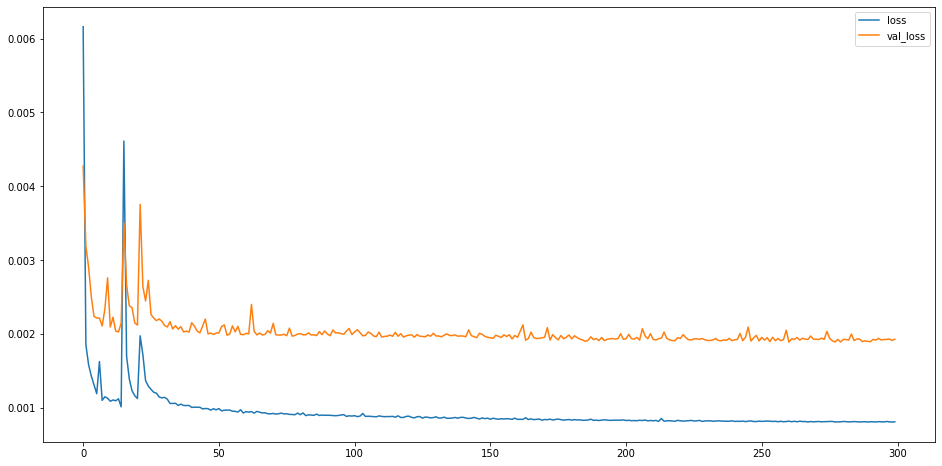

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.7
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 23.9
		5.12. PSNR: 24.3
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.277

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

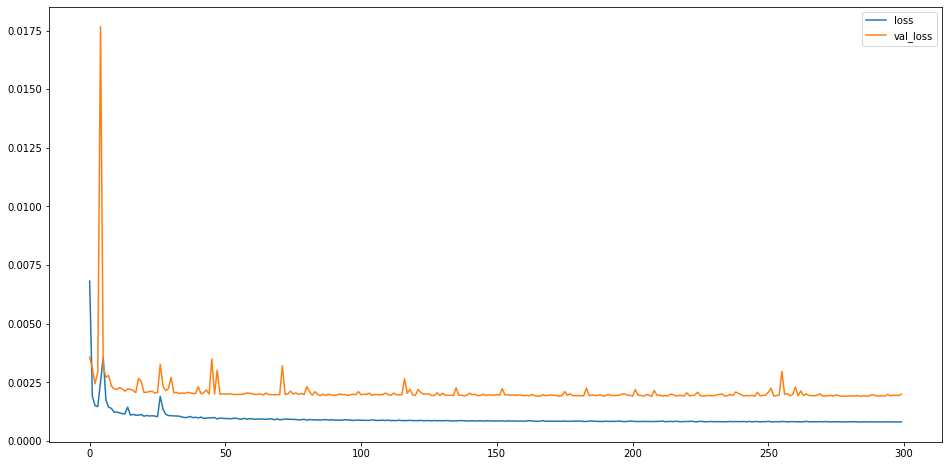

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 26.7
		5.4. PSNR: 20.5
		5.5. PSNR: 23.6
		5.6. PSNR: 24.7
		5.7. PSNR: 27.6
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.1
		5.11. PSNR: 23.9
		5.12. PSNR: 24.1
		5.13. PSNR: 27.8
		5.14. PSNR: 20.4
	Average PSNR: 24.089

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

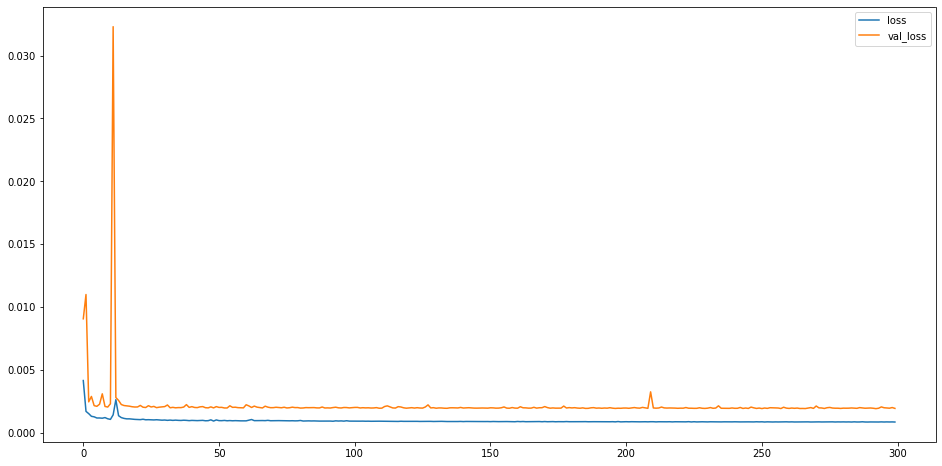

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 23.9
		5.12. PSNR: 24.1
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.332

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

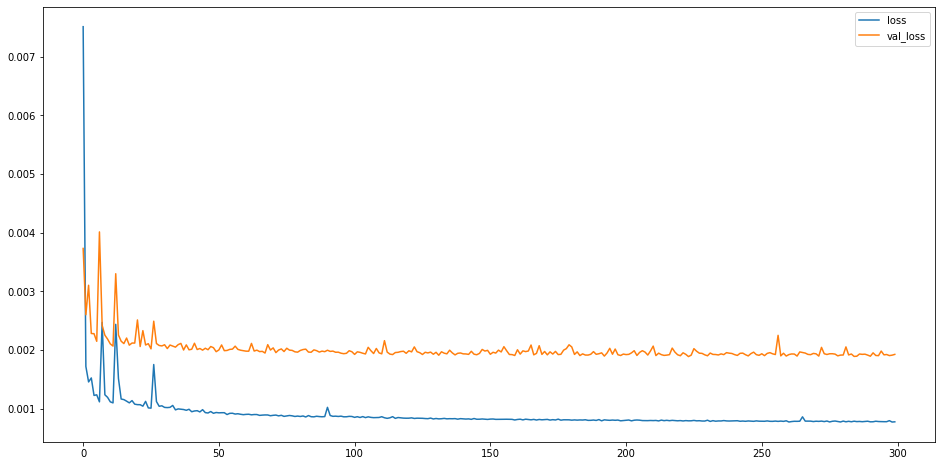

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.7
		5.4. PSNR: 20.8
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.4
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.334

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

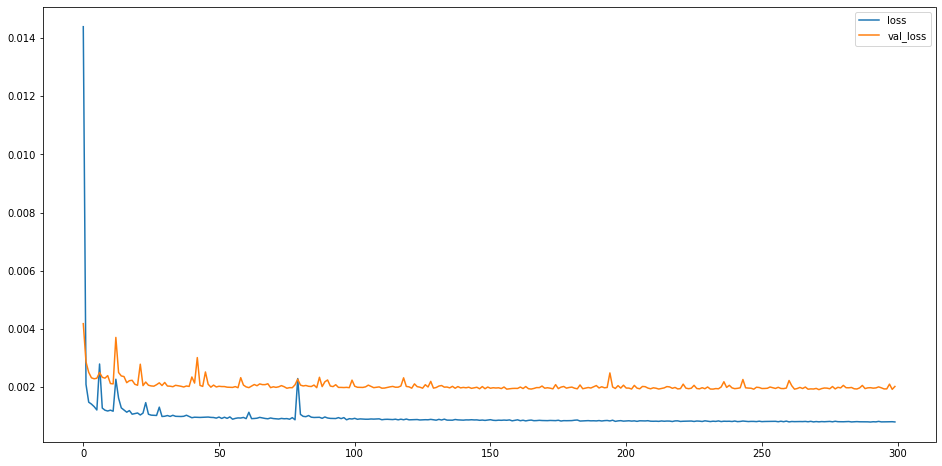

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.6
		5.4. PSNR: 20.7
		5.5. PSNR: 23.6
		5.6. PSNR: 24.7
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 21.7
		5.11. PSNR: 23.9
		5.12. PSNR: 23.9
		5.13. PSNR: 27.8
		5.14. PSNR: 20.6
	Average PSNR: 24.216

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

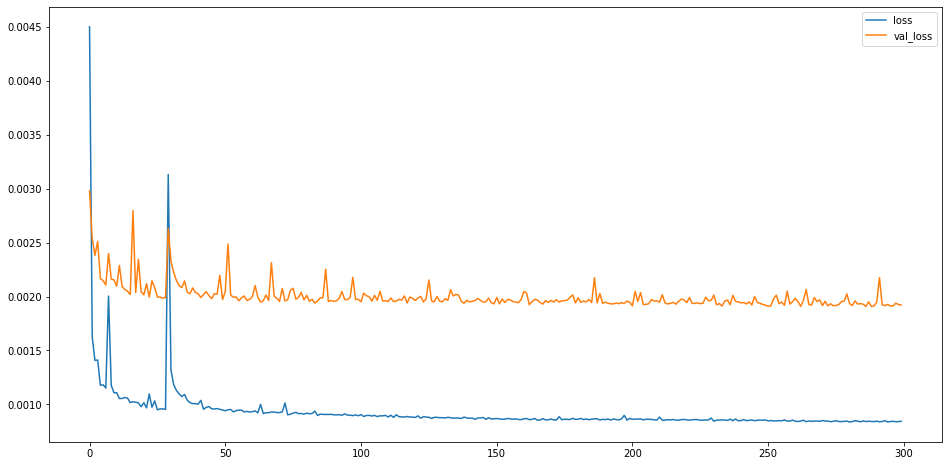

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.0
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.303

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

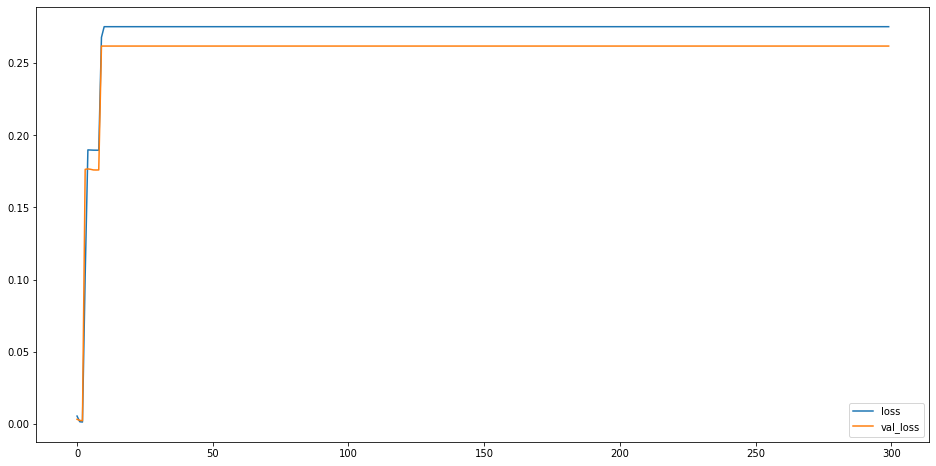

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.


/tf/GitProjects/srcnn-tf2/srcnn_tf2/model/srcnn_model.py:219: RuntimeWarning: invalid value encountered in true_divide
  y_pred.append(predicted_image/predicted_image.max())



	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: nan
		5.2. PSNR: nan
		5.3. PSNR: nan
		5.4. PSNR: nan
		5.5. PSNR: nan
		5.6. PSNR: nan
		5.7. PSNR: nan
		5.8. PSNR: nan
		5.9. PSNR: nan
		5.10. PSNR: nan
		5.11. PSNR: nan
		5.12. PSNR: nan
		5.13. PSNR: nan
		5.14. PSNR: nan
	Average PSNR: nan

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: nan
		5.2. SSIM: nan
		5.3. SSIM: nan
		5.4. SSIM: nan
		5.5. SSIM: nan
		5.6. SSIM: nan
		5.7. SSIM: nan
		5.8. SSIM: nan
		5.9. SSIM: nan
		5.10. SSIM: nan
		5.11. SSIM: nan
		5.12. SSIM: nan
		5.13. SSIM: nan
		5.14. SSIM: nan
	Average SSIM: nan

	6. Plotting SSIM results:

Model Architecture: (13, 5, 128, 128, 8)
300 epochs comp

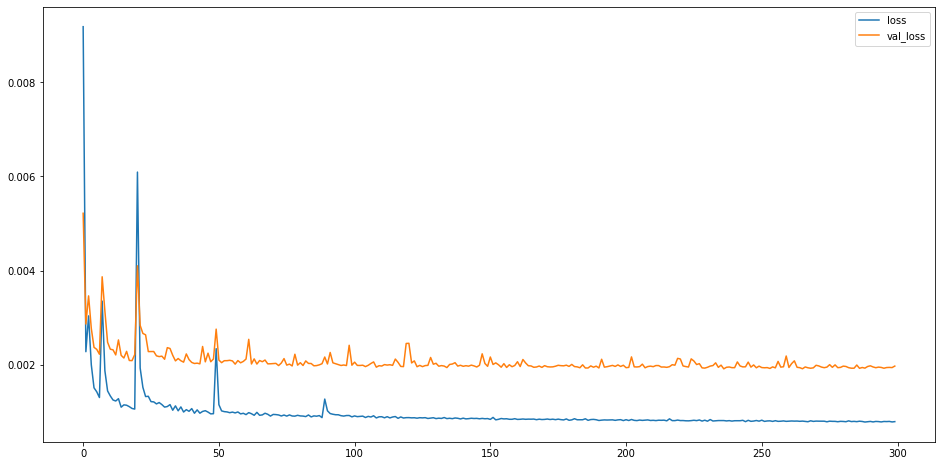

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.8
		5.4. PSNR: 20.8
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 21.8
		5.11. PSNR: 23.9
		5.12. PSNR: 23.8
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.248

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

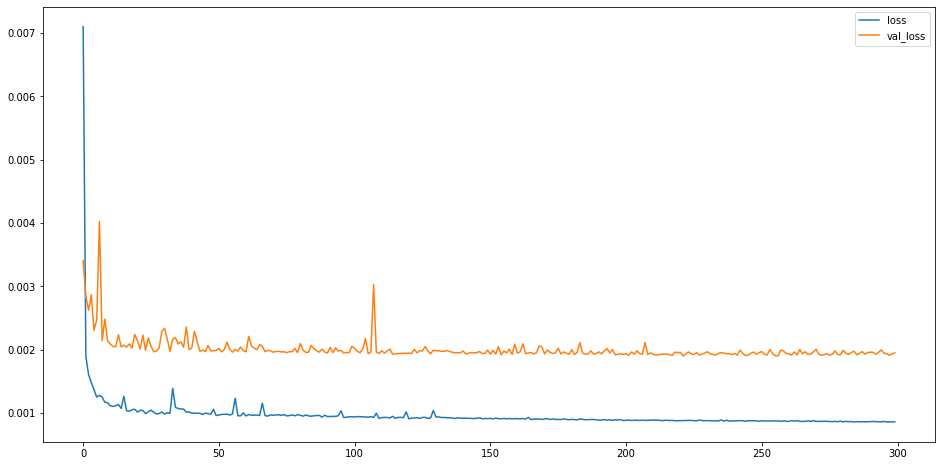

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.1
		5.4. PSNR: 20.5
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.2
		5.11. PSNR: 23.9
		5.12. PSNR: 24.4
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.307

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

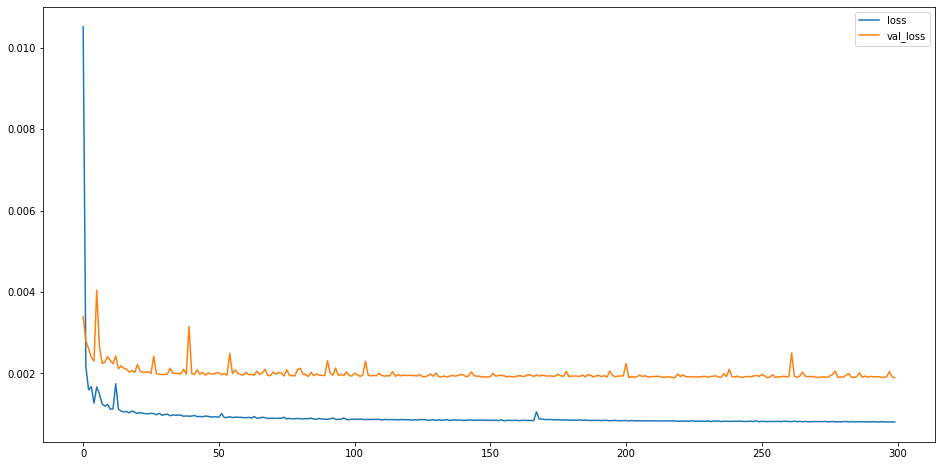

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.8
		5.4. PSNR: 20.7
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 22.0
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 27.8
		5.14. PSNR: 20.6
	Average PSNR: 24.308

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

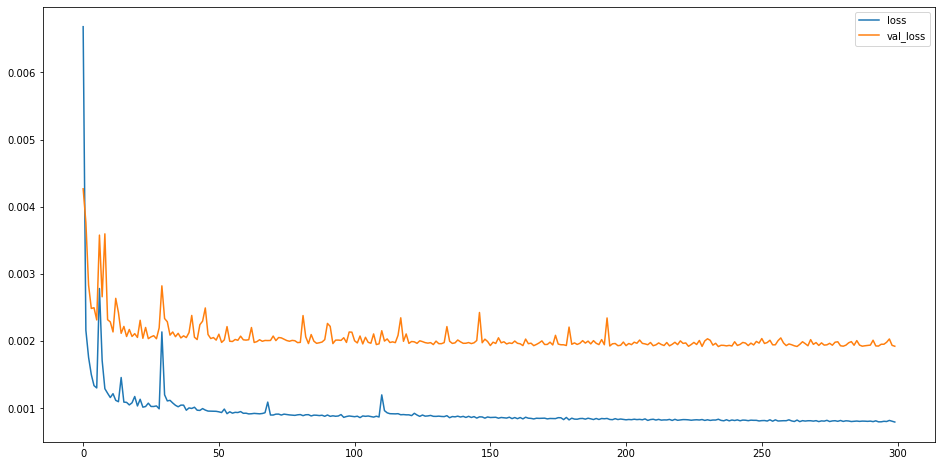

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.8
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.297

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

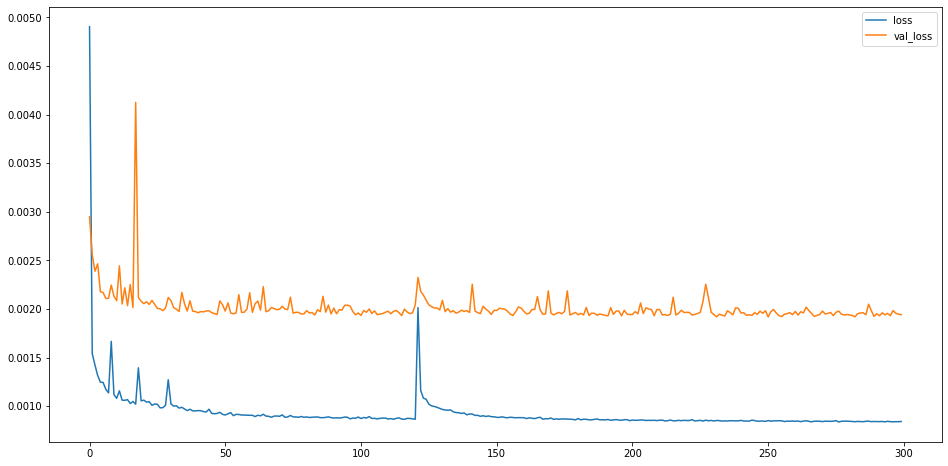

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.3
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.1
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.285

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

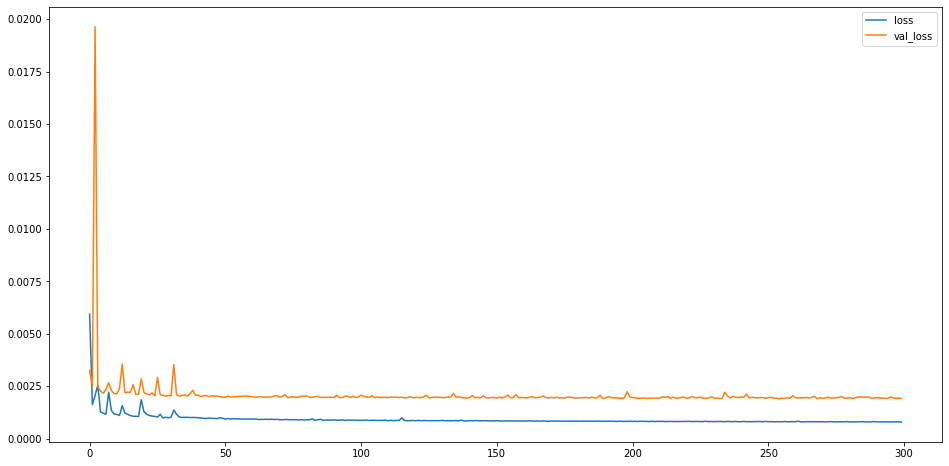

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 28.0
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.6
		5.11. PSNR: 24.0
		5.12. PSNR: 24.1
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.318

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

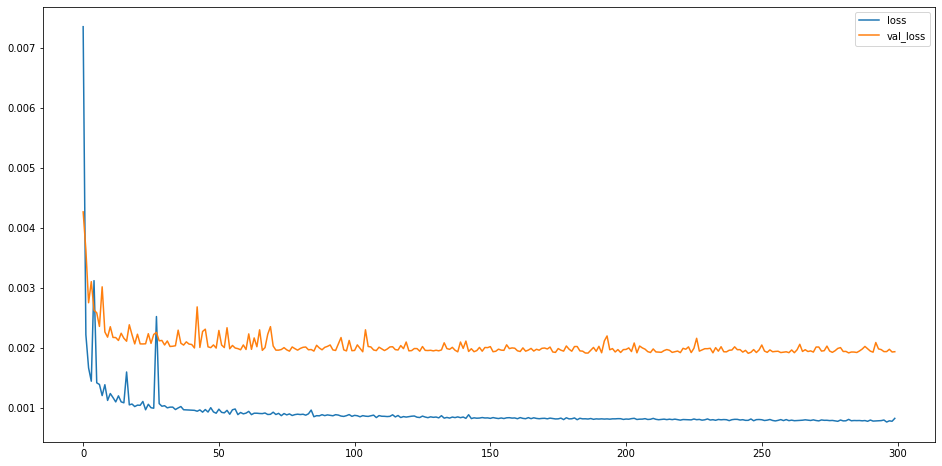

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.5
		5.4. PSNR: 20.8
		5.5. PSNR: 23.6
		5.6. PSNR: 24.6
		5.7. PSNR: 28.8
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.2
		5.11. PSNR: 23.8
		5.12. PSNR: 23.9
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.211

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

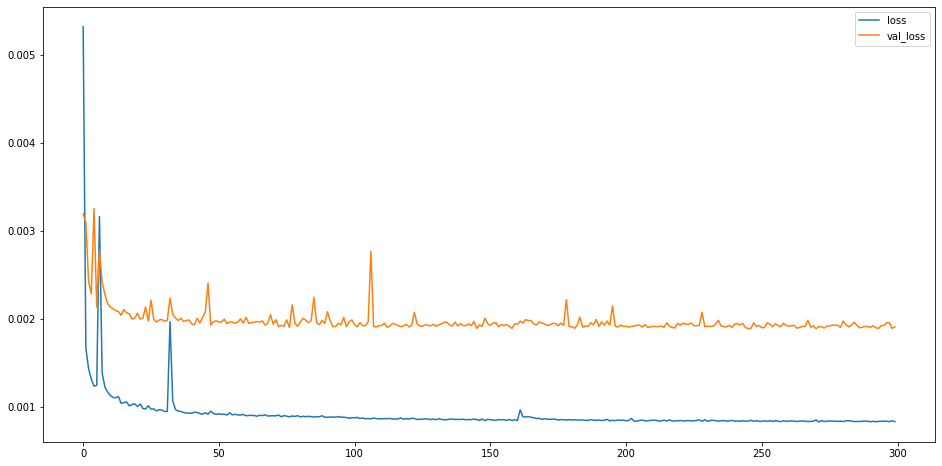

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.8
		5.4. PSNR: 20.7
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.3
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.3
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.296

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

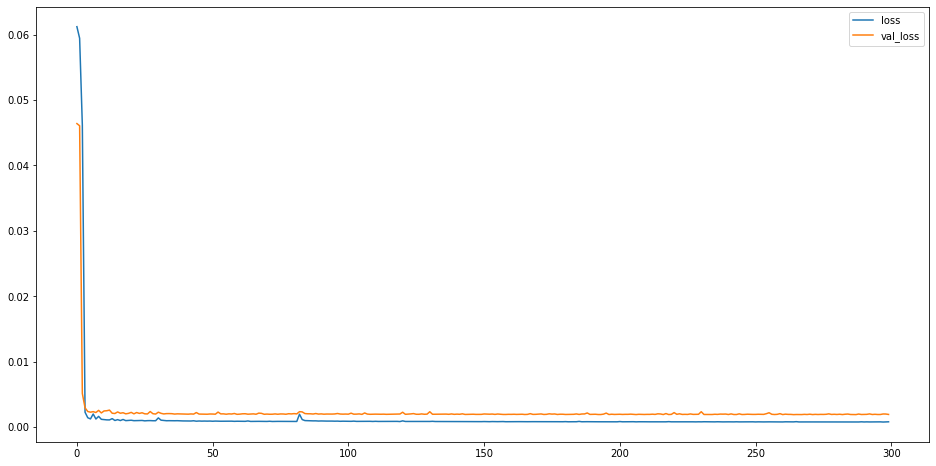

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 27.7
		5.4. PSNR: 20.8
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.7
		5.11. PSNR: 24.0
		5.12. PSNR: 24.1
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.301

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

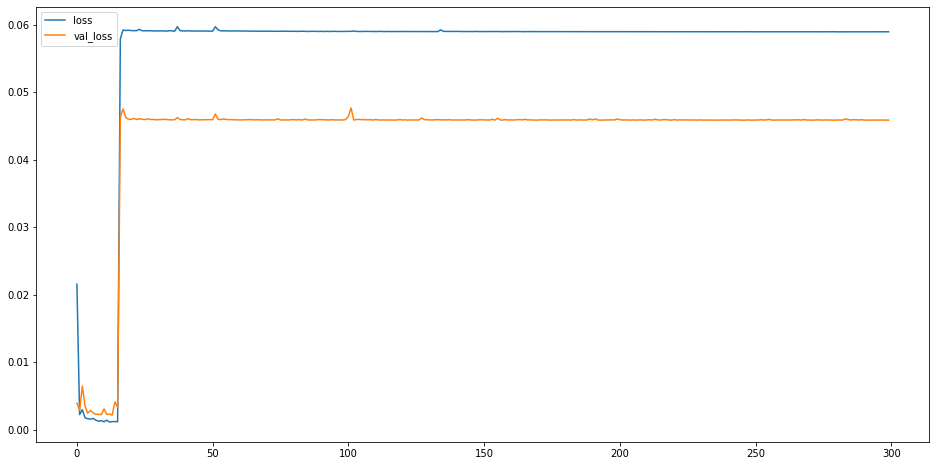

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 11.2
		5.2. PSNR: 13.3
		5.3. PSNR: 14.2
		5.4. PSNR: 6.7
		5.5. PSNR: 11.9
		5.6. PSNR: 10.6
		5.7. PSNR: 8.6
		5.8. PSNR: 10.7
		5.9. PSNR: 13.7
		5.10. PSNR: 12.0
		5.11. PSNR: 12.8
		5.12. PSNR: 13.8
		5.13. PSNR: 11.8
		5.14. PSNR: 9.7
	Average PSNR: 11.494

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.3
		5.2. SSIM: 0.5
		5.3. SSIM: 0.5
		5.4. SSIM: 0.6


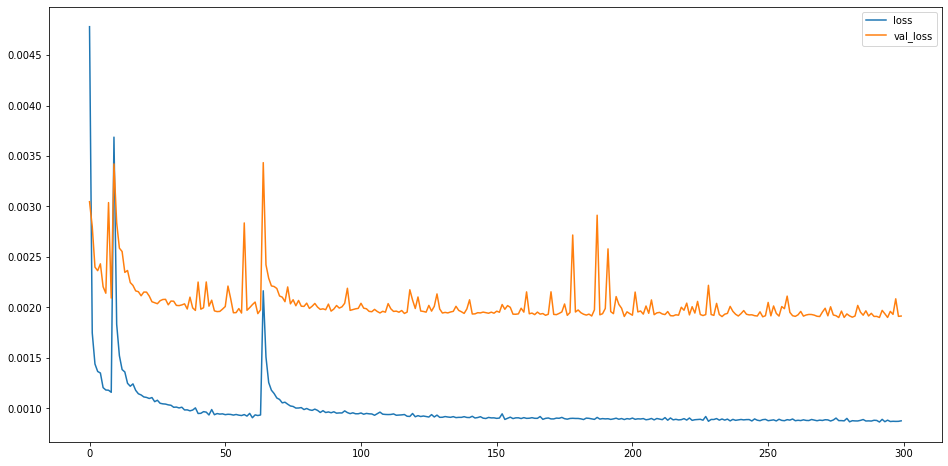

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.1
		5.4. PSNR: 20.5
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.3
		5.13. PSNR: 28.0
		5.14. PSNR: 20.5
	Average PSNR: 24.304

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

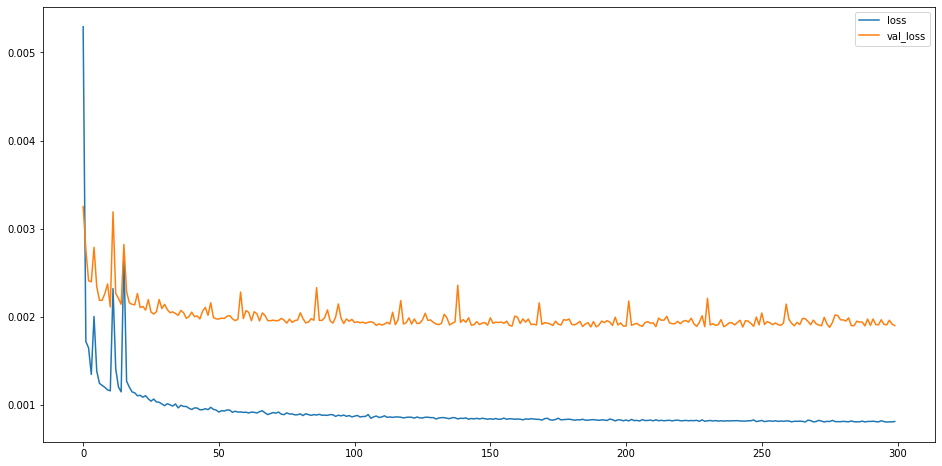

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.2
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.8
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.3
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.360

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

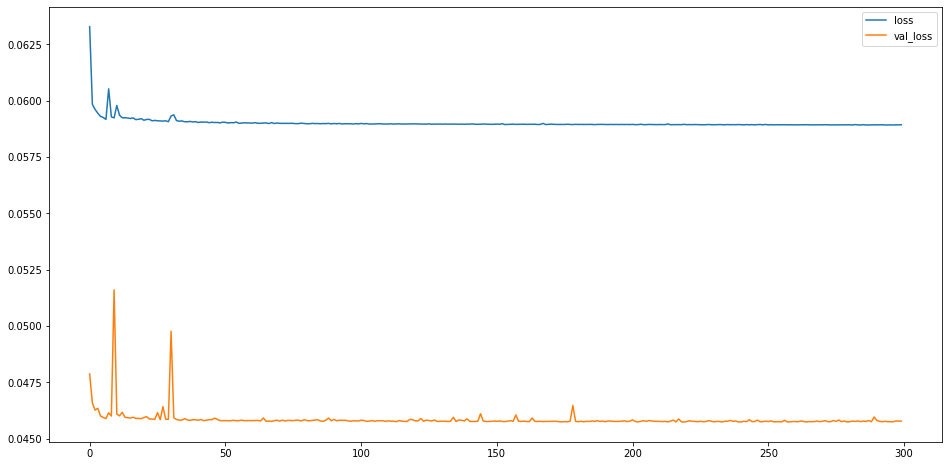

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 11.1
		5.2. PSNR: 13.3
		5.3. PSNR: 14.2
		5.4. PSNR: 6.7
		5.5. PSNR: 11.9
		5.6. PSNR: 10.6
		5.7. PSNR: 8.6
		5.8. PSNR: 10.7
		5.9. PSNR: 13.7
		5.10. PSNR: 12.1
		5.11. PSNR: 12.8
		5.12. PSNR: 13.8
		5.13. PSNR: 11.8
		5.14. PSNR: 9.7
	Average PSNR: 11.496

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.3
		5.2. SSIM: 0.5
		5.3. SSIM: 0.5
		5.4. SSIM: 0.6


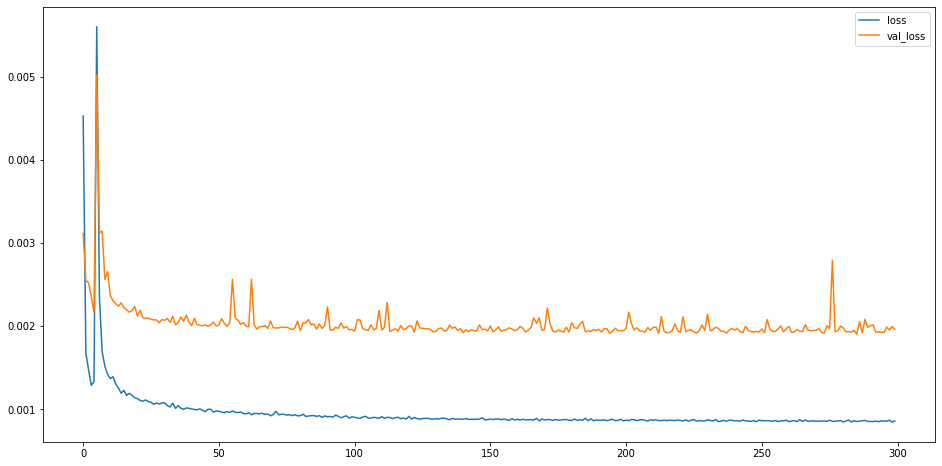

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 28.2
		5.4. PSNR: 20.5
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.4
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.341

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

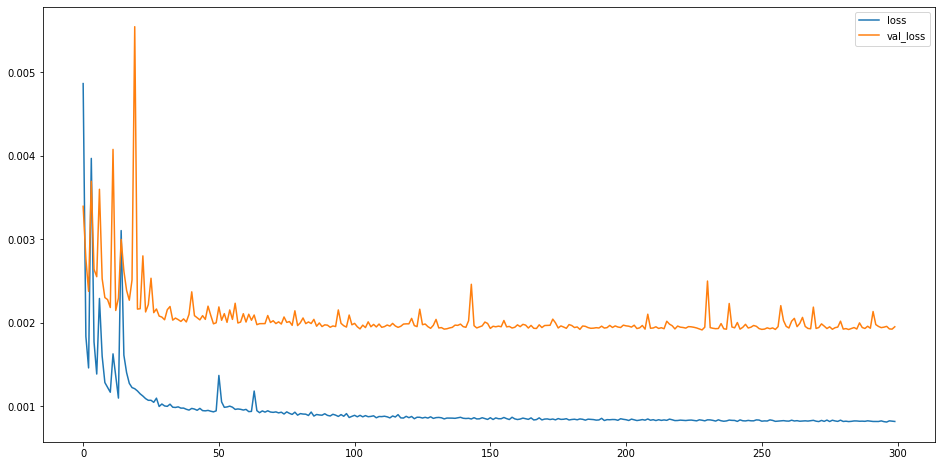

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 28.0
		5.4. PSNR: 20.5
		5.5. PSNR: 23.6
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 22.2
		5.11. PSNR: 23.9
		5.12. PSNR: 24.4
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.294

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

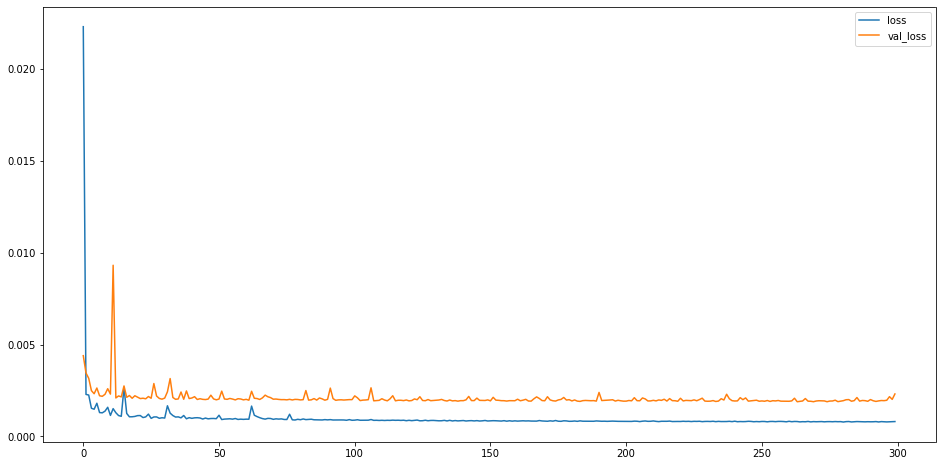

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.2
		5.2. PSNR: 23.0
		5.3. PSNR: 26.9
		5.4. PSNR: 20.1
		5.5. PSNR: 23.7
		5.6. PSNR: 24.7
		5.7. PSNR: 27.4
		5.8. PSNR: 23.4
		5.9. PSNR: 28.5
		5.10. PSNR: 22.2
		5.11. PSNR: 23.5
		5.12. PSNR: 24.8
		5.13. PSNR: 26.9
		5.14. PSNR: 20.3
	Average PSNR: 23.978

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

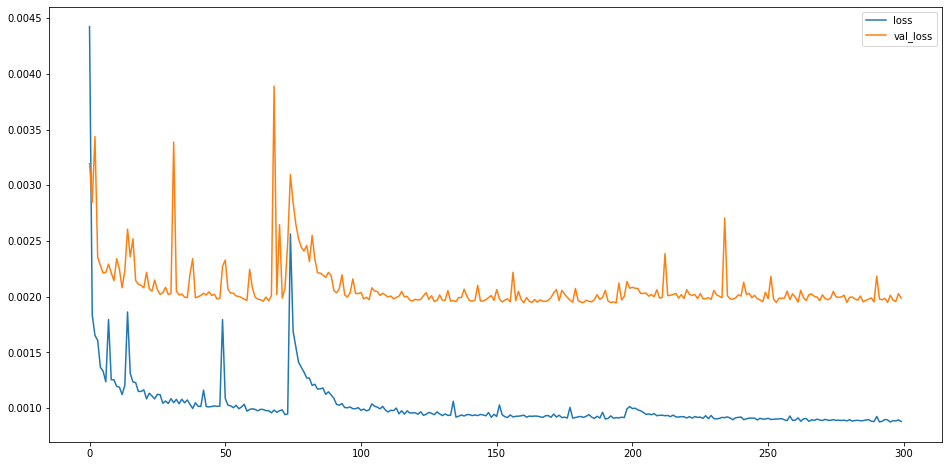

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.7
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.315

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

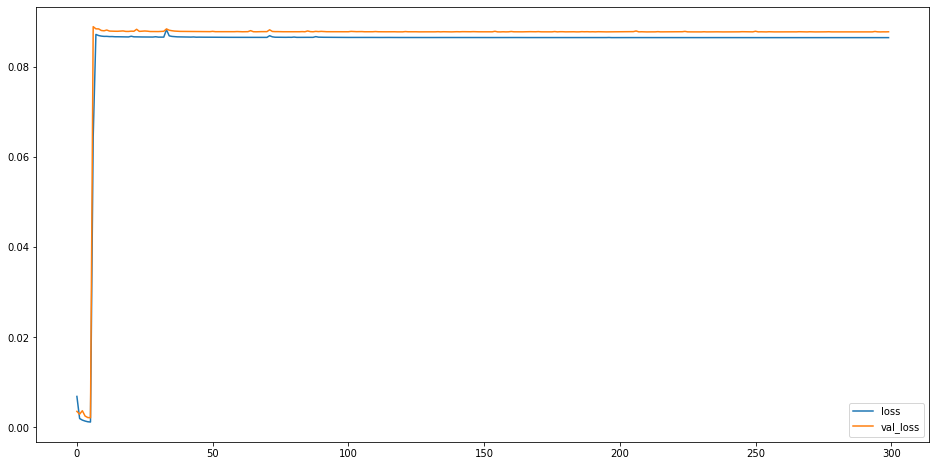

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 11.1
		5.2. PSNR: 9.3
		5.3. PSNR: 9.5
		5.4. PSNR: 6.4
		5.5. PSNR: 11.5
		5.6. PSNR: 10.4
		5.7. PSNR: 7.9
		5.8. PSNR: 10.7
		5.9. PSNR: 14.0
		5.10. PSNR: 12.1
		5.11. PSNR: 12.9
		5.12. PSNR: 12.4
		5.13. PSNR: 11.6
		5.14. PSNR: 9.0
	Average PSNR: 10.631

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.3
		5.2. SSIM: 0.5
		5.3. SSIM: 0.5
		5.4. SSIM: 0.6
		

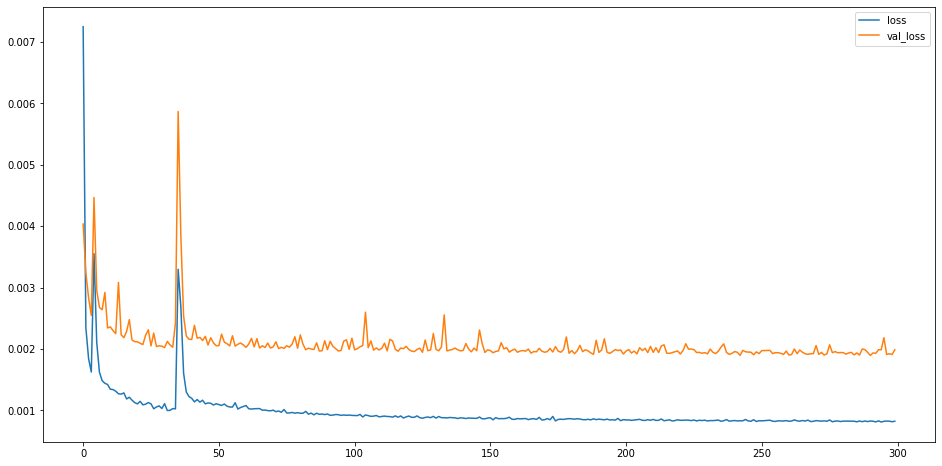

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.8
		5.4. PSNR: 20.3
		5.5. PSNR: 23.4
		5.6. PSNR: 24.7
		5.7. PSNR: 27.4
		5.8. PSNR: 23.4
		5.9. PSNR: 28.6
		5.10. PSNR: 22.5
		5.11. PSNR: 24.0
		5.12. PSNR: 24.2
		5.13. PSNR: 27.9
		5.14. PSNR: 20.4
	Average PSNR: 24.140

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

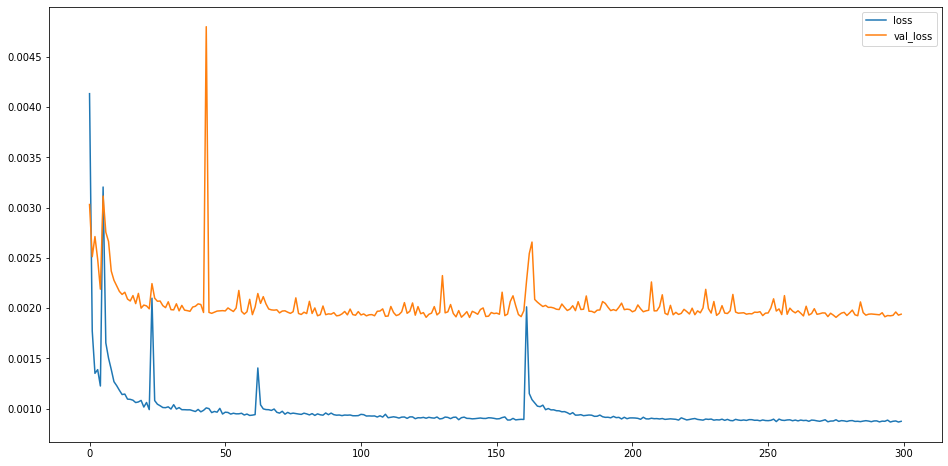

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.0
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.8
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.1
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.305

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

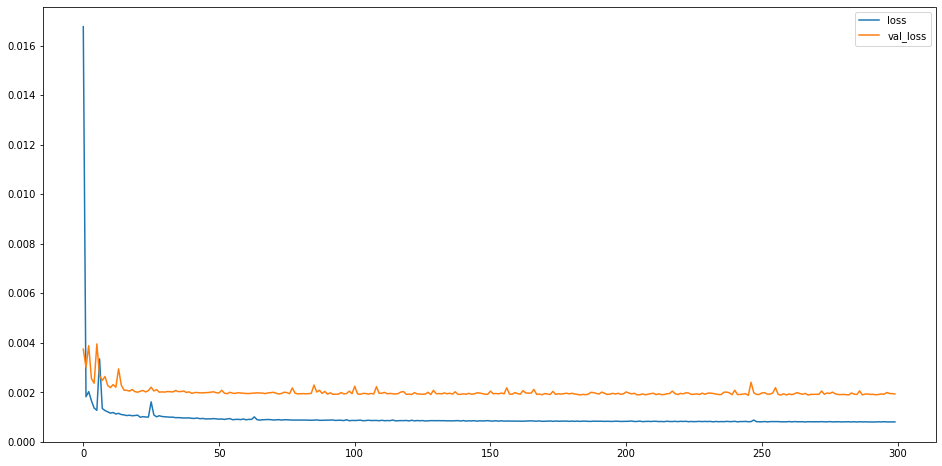

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.2
		5.3. PSNR: 27.9
		5.4. PSNR: 20.4
		5.5. PSNR: 23.5
		5.6. PSNR: 24.8
		5.7. PSNR: 28.4
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.1
		5.11. PSNR: 24.0
		5.12. PSNR: 24.0
		5.13. PSNR: 27.9
		5.14. PSNR: 20.4
	Average PSNR: 24.239

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

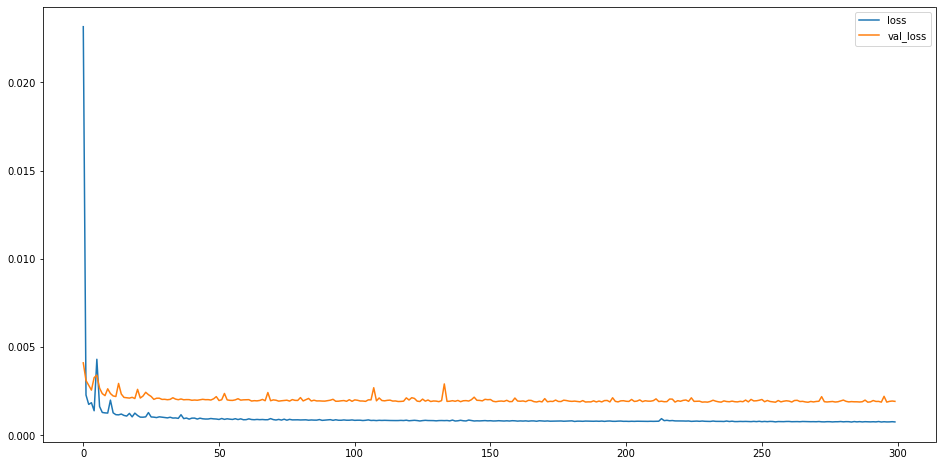

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.1
		5.4. PSNR: 20.4
		5.5. PSNR: 23.7
		5.6. PSNR: 24.7
		5.7. PSNR: 28.3
		5.8. PSNR: 23.5
		5.9. PSNR: 28.6
		5.10. PSNR: 22.3
		5.11. PSNR: 23.9
		5.12. PSNR: 24.0
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.238

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

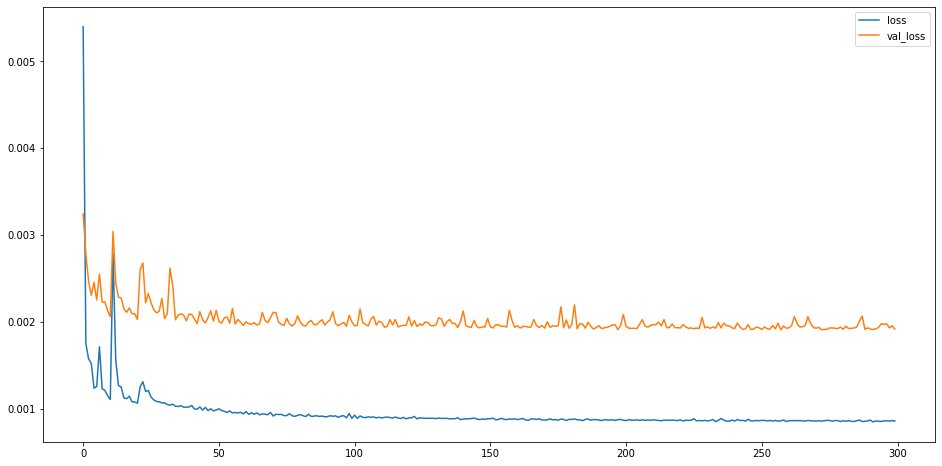

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.9
		5.11. PSNR: 24.0
		5.12. PSNR: 24.5
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.338

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

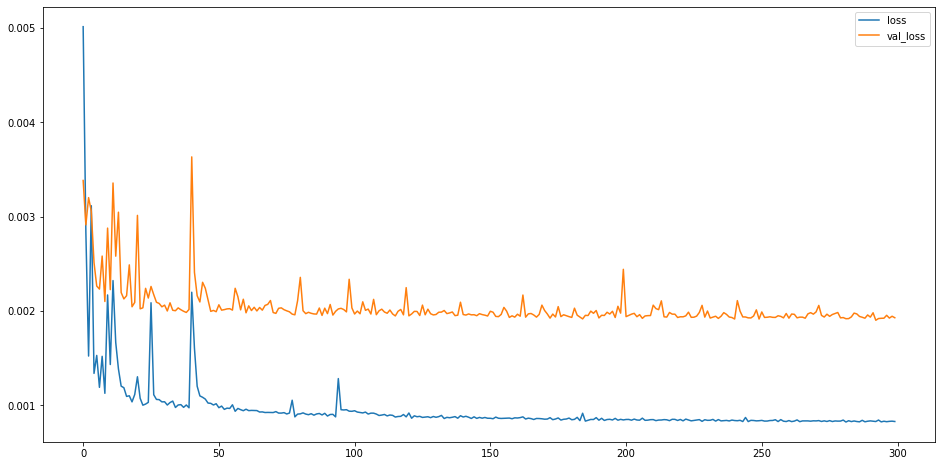

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.0
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 22.0
		5.11. PSNR: 23.9
		5.12. PSNR: 24.1
		5.13. PSNR: 28.0
		5.14. PSNR: 20.5
	Average PSNR: 24.302

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

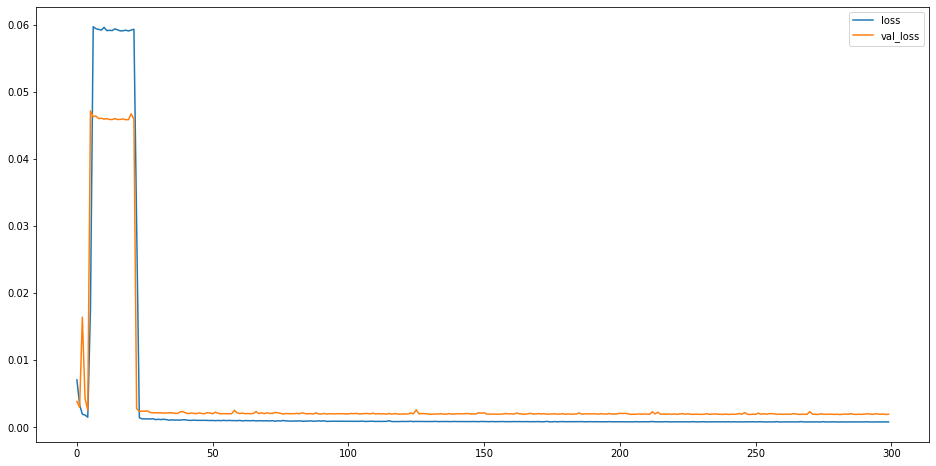

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.2
		5.4. PSNR: 20.7
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.7
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 22.2
		5.11. PSNR: 23.9
		5.12. PSNR: 24.3
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.264

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

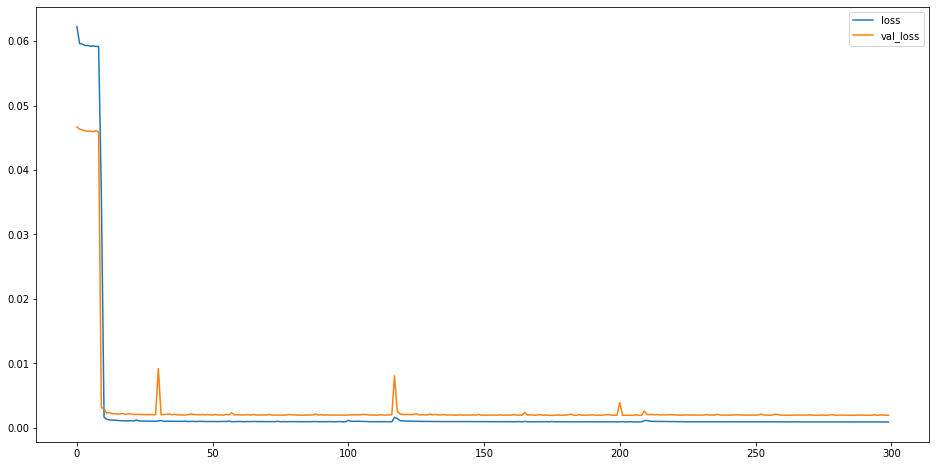

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 28.0
		5.4. PSNR: 20.5
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 22.0
		5.11. PSNR: 23.9
		5.12. PSNR: 24.5
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.289

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

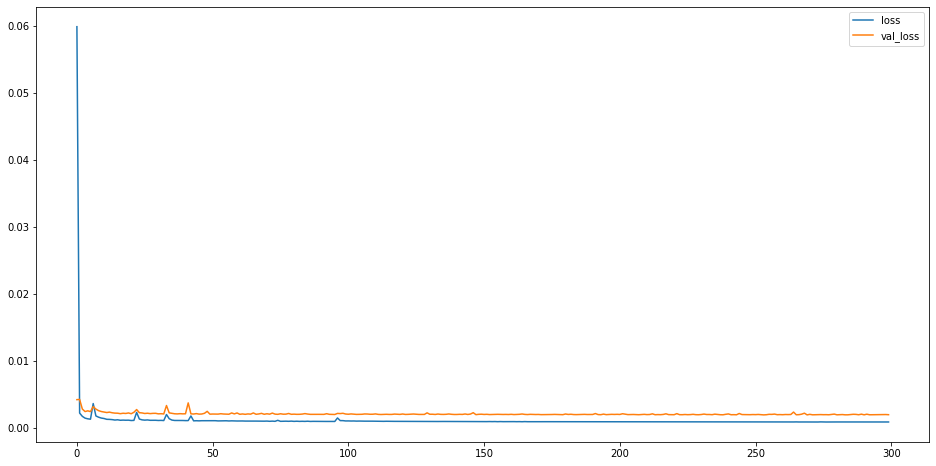

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.0
		5.4. PSNR: 20.6
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 22.0
		5.11. PSNR: 23.9
		5.12. PSNR: 24.2
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.304

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

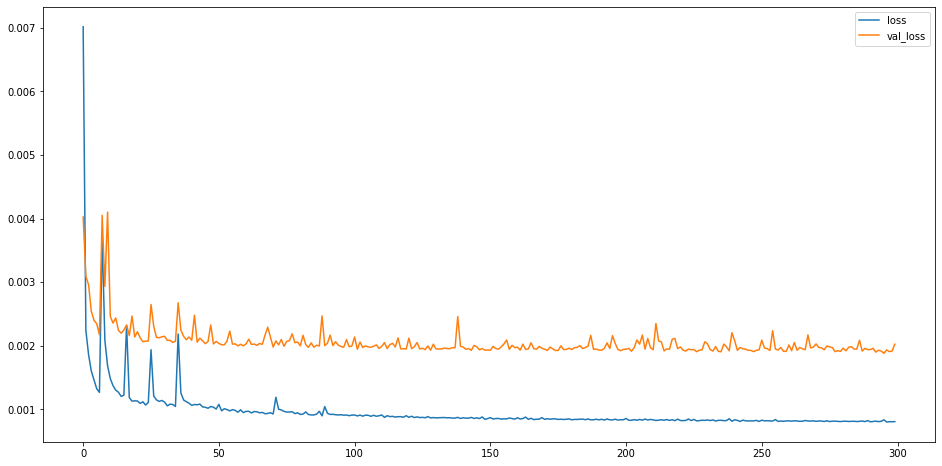

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.7
		5.4. PSNR: 20.5
		5.5. PSNR: 23.9
		5.6. PSNR: 24.7
		5.7. PSNR: 28.0
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 22.3
		5.11. PSNR: 23.9
		5.12. PSNR: 25.1
		5.13. PSNR: 27.5
		5.14. PSNR: 20.5
	Average PSNR: 24.296

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

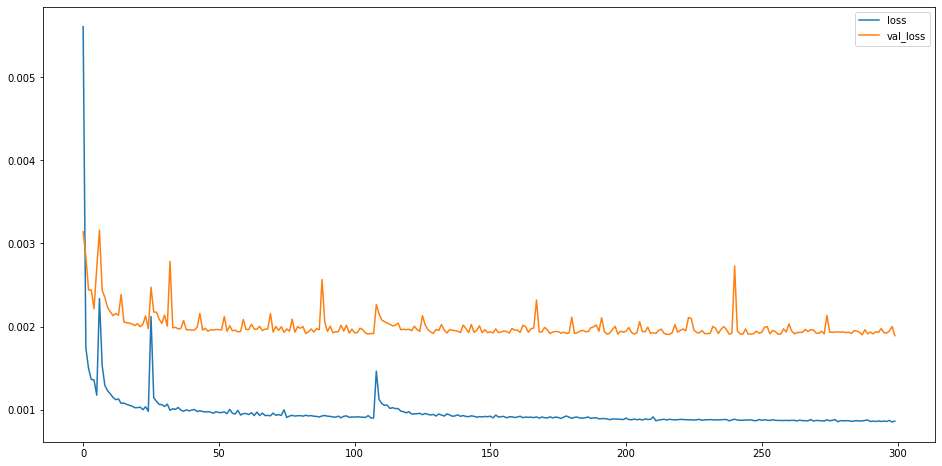

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.7
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.8
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.1
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.325

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

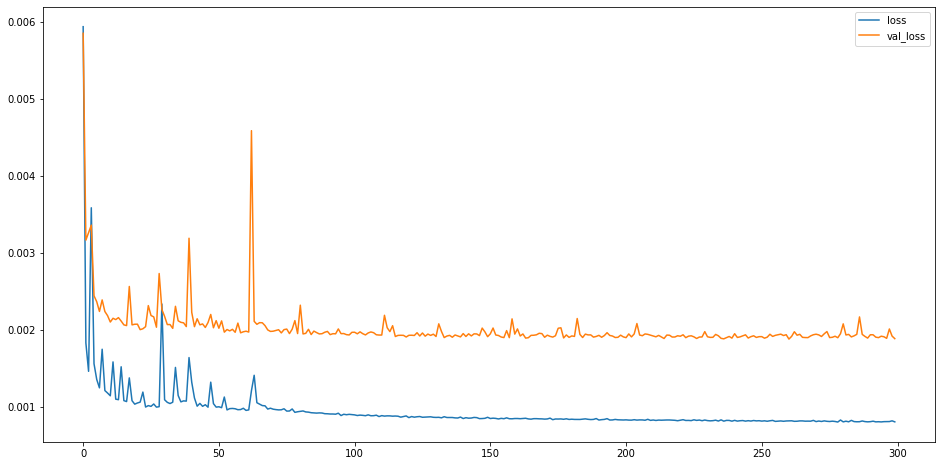

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.3
		5.3. PSNR: 27.9
		5.4. PSNR: 20.6
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.8
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 24.0
		5.12. PSNR: 24.6
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.337

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

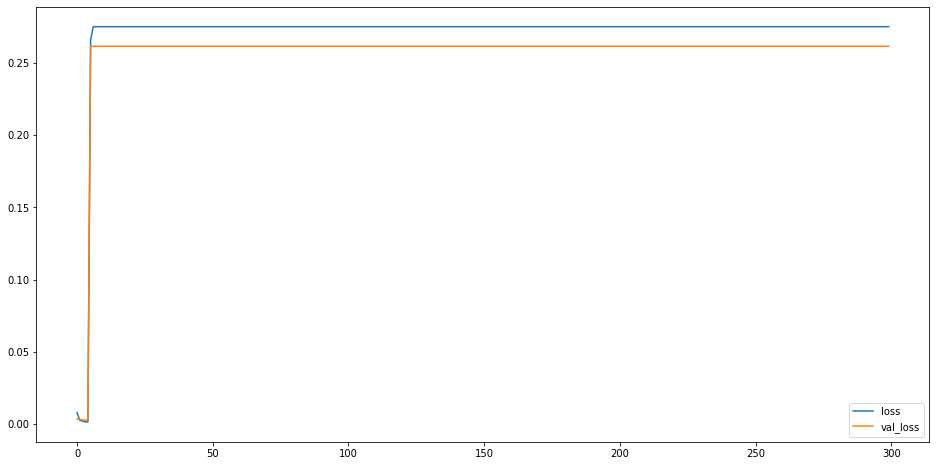

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: nan
		5.2. PSNR: nan
		5.3. PSNR: nan
		5.4. PSNR: nan
		5.5. PSNR: nan
		5.6. PSNR: nan
		5.7. PSNR: nan
		5.8. PSNR: nan
		5.9. PSNR: nan
		5.10. PSNR: nan
		5.11. PSNR: nan
		5.12. PSNR: nan
		5.13. PSNR: nan
		5.14. PSNR: nan
	Average PSNR: nan

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: nan
		5.2. SSIM: nan
		5.3. SSIM: nan
		5.4. SSIM: nan
		5.5. SSIM: n

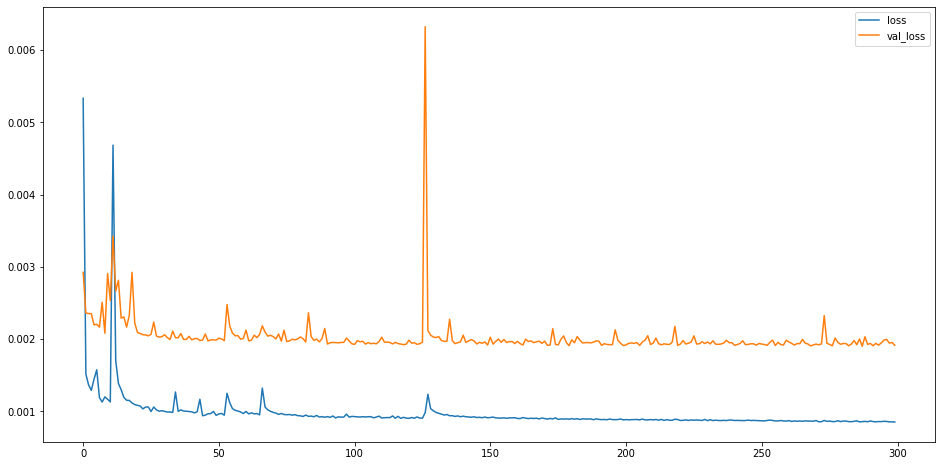

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.0
		5.4. PSNR: 20.5
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.7
		5.11. PSNR: 23.9
		5.12. PSNR: 24.5
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.300

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

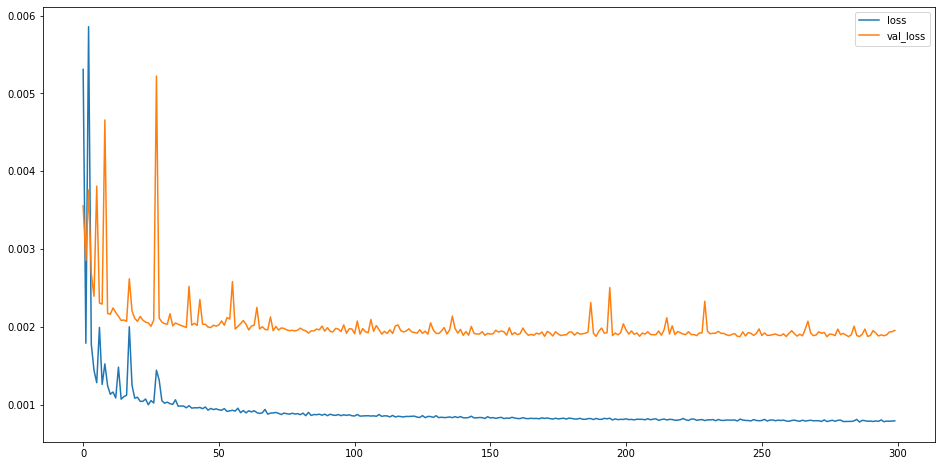

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.3
		5.3. PSNR: 28.0
		5.4. PSNR: 20.5
		5.5. PSNR: 23.6
		5.6. PSNR: 24.9
		5.7. PSNR: 28.2
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 22.0
		5.11. PSNR: 23.9
		5.12. PSNR: 24.0
		5.13. PSNR: 27.9
		5.14. PSNR: 20.6
	Average PSNR: 24.271

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

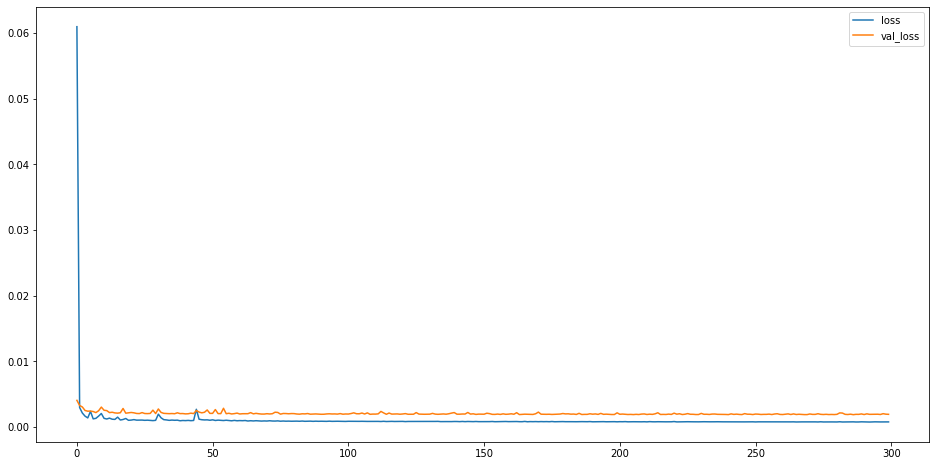

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.8
		5.4. PSNR: 20.6
		5.5. PSNR: 23.8
		5.6. PSNR: 24.8
		5.7. PSNR: 28.5
		5.8. PSNR: 23.6
		5.9. PSNR: 28.9
		5.10. PSNR: 21.8
		5.11. PSNR: 23.5
		5.12. PSNR: 24.4
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.244

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

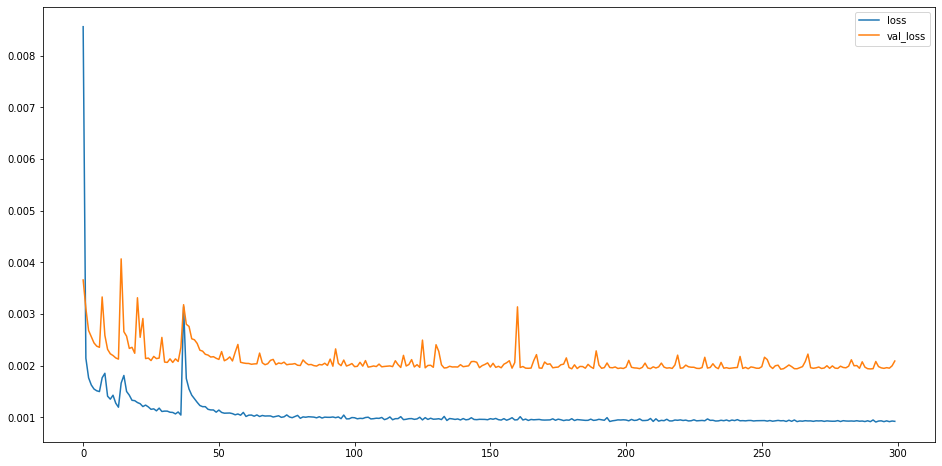

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 28.1
		5.4. PSNR: 20.1
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.3
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 22.2
		5.11. PSNR: 23.9
		5.12. PSNR: 24.4
		5.13. PSNR: 27.8
		5.14. PSNR: 20.4
	Average PSNR: 24.241

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

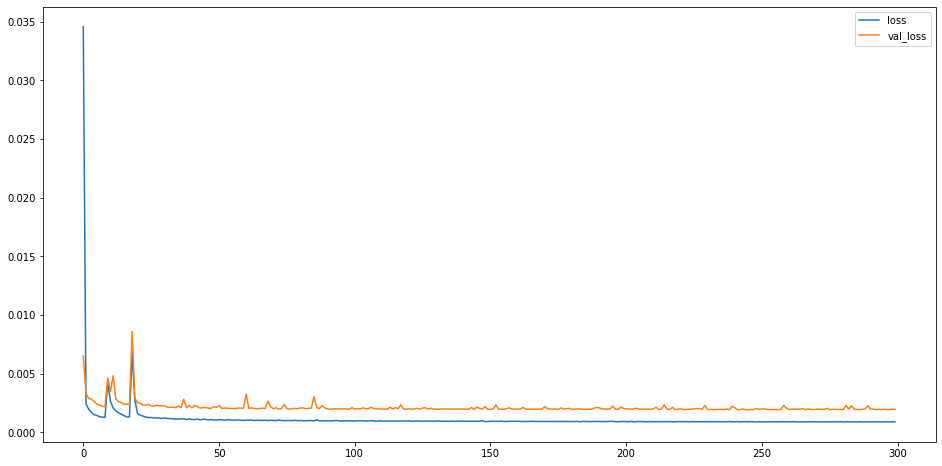

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 27.8
		5.4. PSNR: 20.4
		5.5. PSNR: 23.3
		5.6. PSNR: 24.8
		5.7. PSNR: 28.8
		5.8. PSNR: 23.6
		5.9. PSNR: 28.8
		5.10. PSNR: 21.8
		5.11. PSNR: 23.9
		5.12. PSNR: 24.1
		5.13. PSNR: 27.9
		5.14. PSNR: 20.5
	Average PSNR: 24.213

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

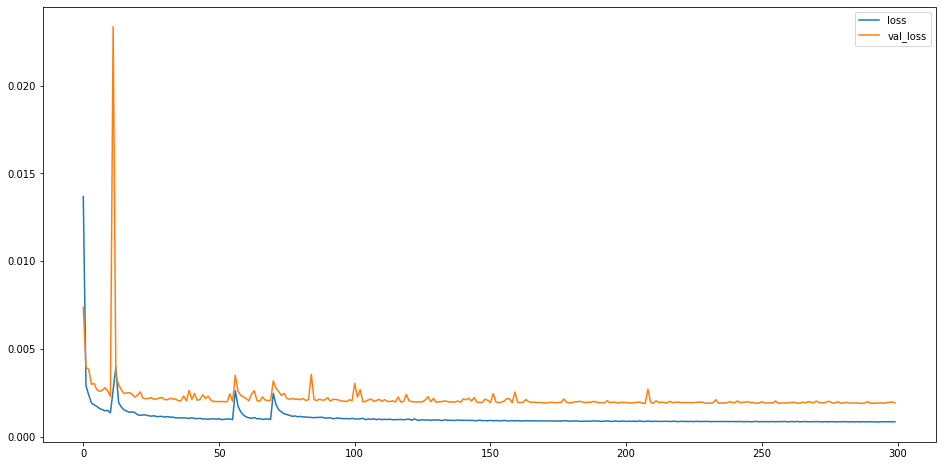

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 27.5
		5.4. PSNR: 20.2
		5.5. PSNR: 23.7
		5.6. PSNR: 24.7
		5.7. PSNR: 28.3
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 21.9
		5.11. PSNR: 23.9
		5.12. PSNR: 24.3
		5.13. PSNR: 27.8
		5.14. PSNR: 20.4
	Average PSNR: 24.167

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

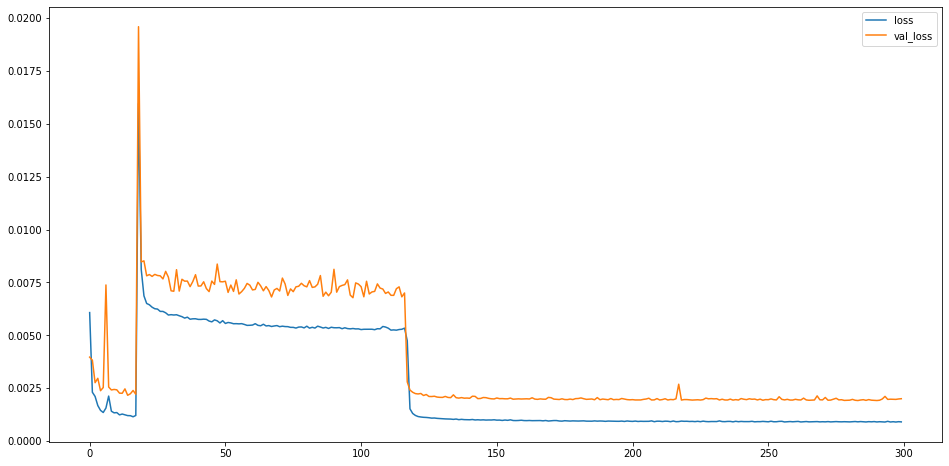

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.0
		5.3. PSNR: 27.9
		5.4. PSNR: 20.2
		5.5. PSNR: 23.7
		5.6. PSNR: 24.6
		5.7. PSNR: 28.3
		5.8. PSNR: 23.4
		5.9. PSNR: 28.2
		5.10. PSNR: 22.0
		5.11. PSNR: 23.5
		5.12. PSNR: 24.5
		5.13. PSNR: 27.5
		5.14. PSNR: 20.4
	Average PSNR: 24.093

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

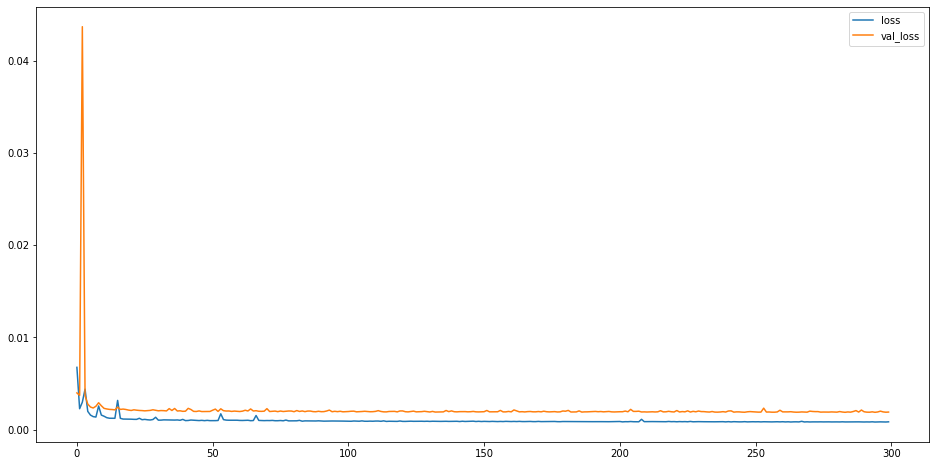

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 27.6
		5.4. PSNR: 20.4
		5.5. PSNR: 23.9
		5.6. PSNR: 24.7
		5.7. PSNR: 28.4
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 21.9
		5.11. PSNR: 23.8
		5.12. PSNR: 24.5
		5.13. PSNR: 27.6
		5.14. PSNR: 20.4
	Average PSNR: 24.204

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

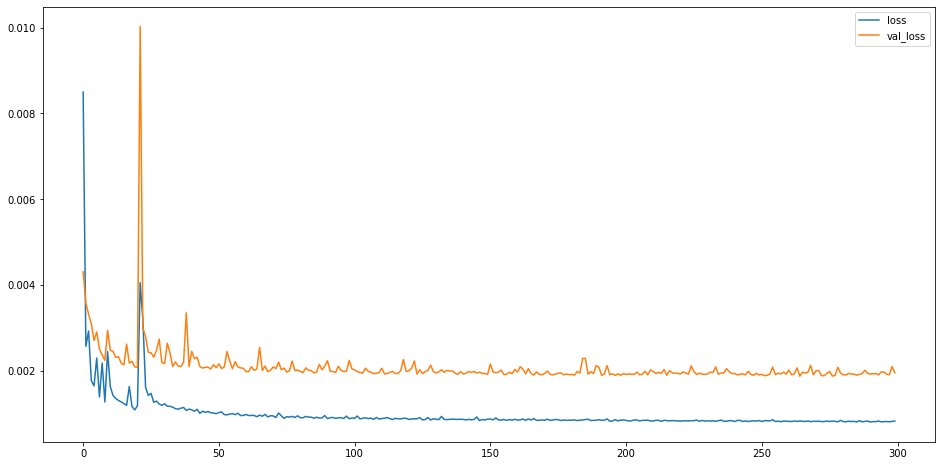

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.0
		5.3. PSNR: 27.0
		5.4. PSNR: 19.9
		5.5. PSNR: 23.8
		5.6. PSNR: 24.6
		5.7. PSNR: 27.1
		5.8. PSNR: 23.3
		5.9. PSNR: 28.5
		5.10. PSNR: 22.5
		5.11. PSNR: 23.6
		5.12. PSNR: 24.5
		5.13. PSNR: 27.3
		5.14. PSNR: 20.2
	Average PSNR: 23.971

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

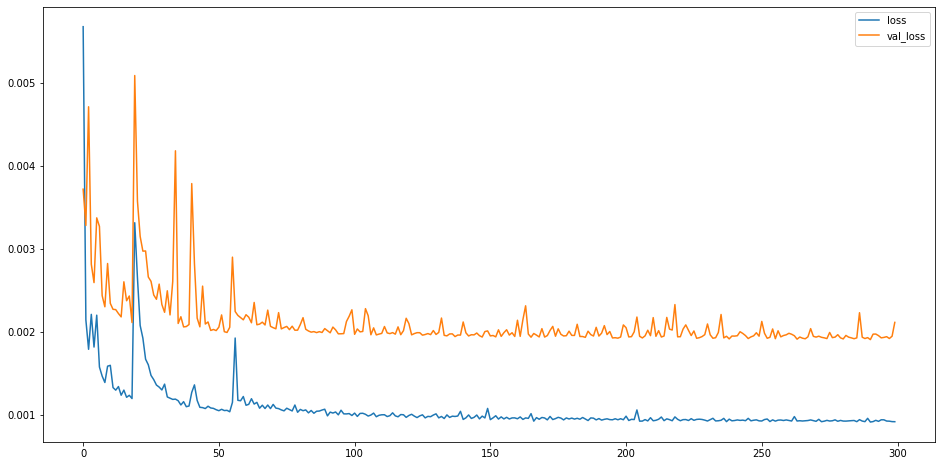

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.0
		5.3. PSNR: 27.7
		5.4. PSNR: 19.7
		5.5. PSNR: 23.0
		5.6. PSNR: 24.4
		5.7. PSNR: 26.5
		5.8. PSNR: 23.1
		5.9. PSNR: 27.9
		5.10. PSNR: 22.4
		5.11. PSNR: 23.7
		5.12. PSNR: 24.2
		5.13. PSNR: 27.2
		5.14. PSNR: 20.1
	Average PSNR: 23.804

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

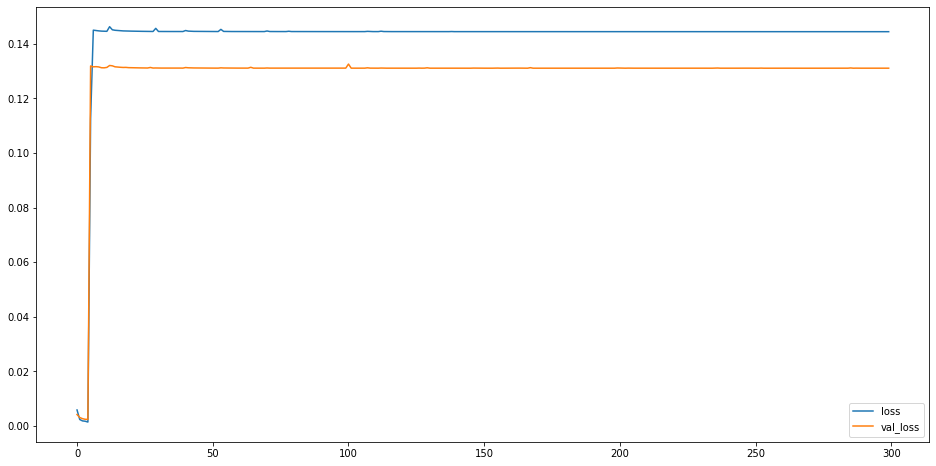

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 8.4
		5.2. PSNR: 8.0
		5.3. PSNR: 8.3
		5.4. PSNR: 3.7
		5.5. PSNR: 8.8
		5.6. PSNR: 7.5
		5.7. PSNR: 5.3
		5.8. PSNR: 7.8
		5.9. PSNR: 10.9
		5.10. PSNR: 9.3
		5.11. PSNR: 10.0
		5.12. PSNR: 10.2
		5.13. PSNR: 8.7
		5.14. PSNR: 6.5
	Average PSNR: 8.092

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.1
		5.2. SSIM: 0.2
		5.3. SSIM: 0.3
		5.4. SSIM: 0.3
		5.5. SS

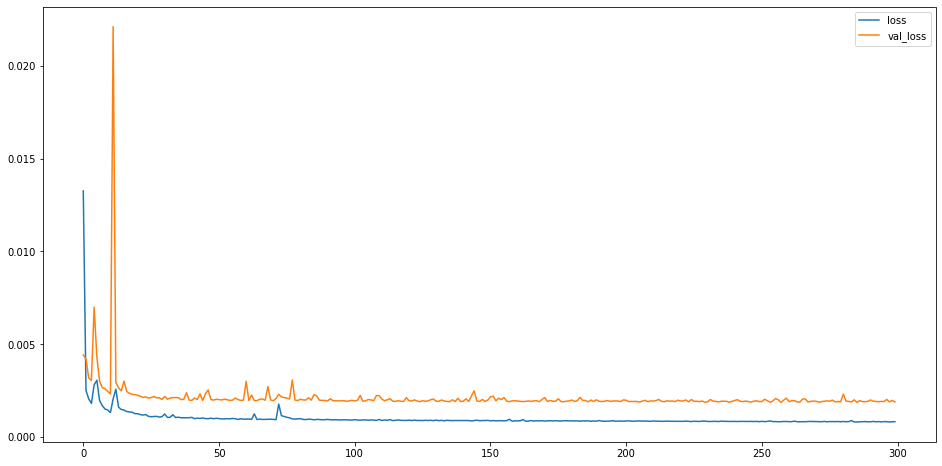

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 28.1
		5.4. PSNR: 20.4
		5.5. PSNR: 23.8
		5.6. PSNR: 24.7
		5.7. PSNR: 28.5
		5.8. PSNR: 23.5
		5.9. PSNR: 28.7
		5.10. PSNR: 22.2
		5.11. PSNR: 23.7
		5.12. PSNR: 24.3
		5.13. PSNR: 27.8
		5.14. PSNR: 20.5
	Average PSNR: 24.260

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

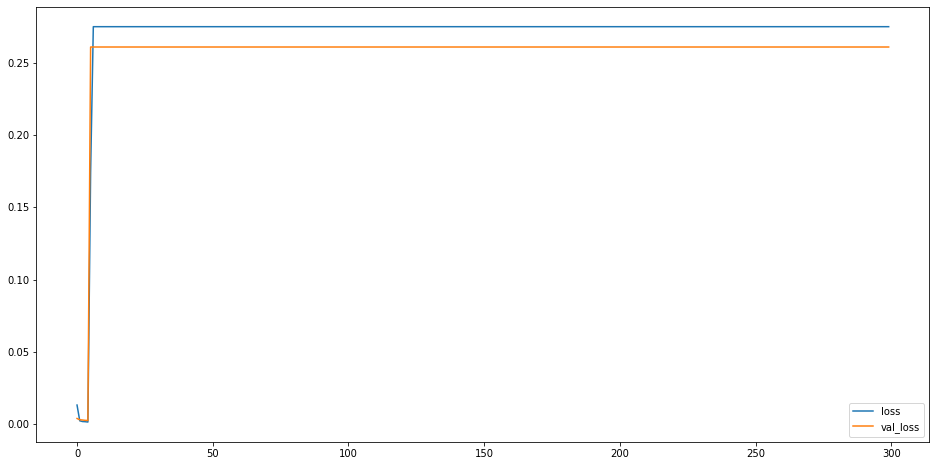

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: nan
		5.2. PSNR: nan
		5.3. PSNR: nan
		5.4. PSNR: nan
		5.5. PSNR: nan
		5.6. PSNR: nan
		5.7. PSNR: nan
		5.8. PSNR: nan
		5.9. PSNR: nan
		5.10. PSNR: nan
		5.11. PSNR: nan
		5.12. PSNR: nan
		5.13. PSNR: nan
		5.14. PSNR: nan
	Average PSNR: nan

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: nan
		5.2. SSIM: nan
		5.3. SSIM: nan
		5.4. SSIM: nan
		5.5. SSIM: n

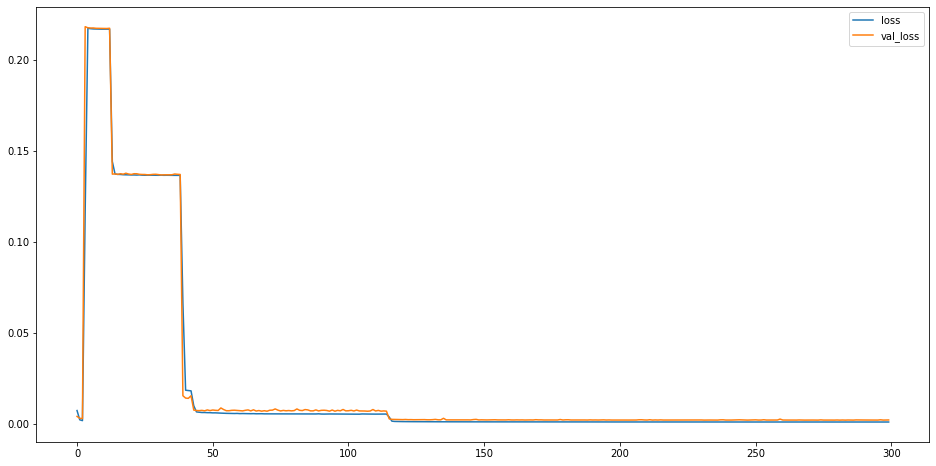

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.1
		5.3. PSNR: 27.7
		5.4. PSNR: 19.8
		5.5. PSNR: 23.6
		5.6. PSNR: 24.5
		5.7. PSNR: 27.7
		5.8. PSNR: 23.4
		5.9. PSNR: 28.6
		5.10. PSNR: 22.2
		5.11. PSNR: 23.5
		5.12. PSNR: 24.3
		5.13. PSNR: 27.8
		5.14. PSNR: 20.3
	Average PSNR: 24.051

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

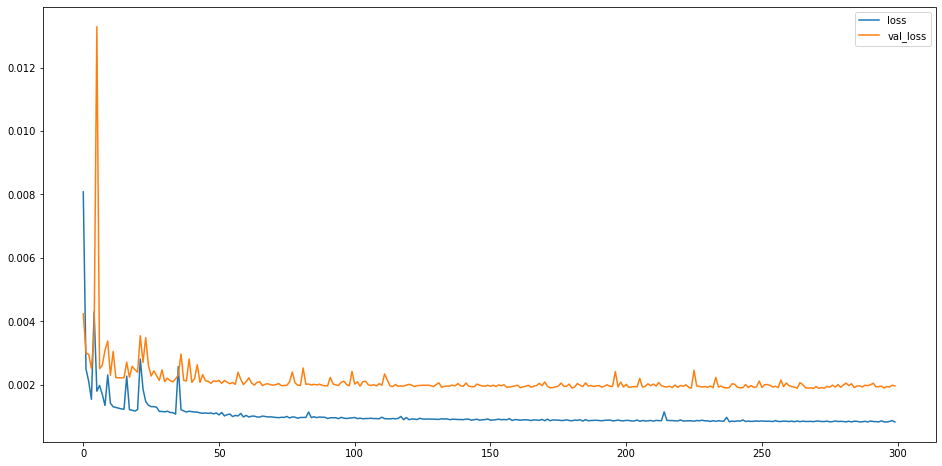

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.3
		5.2. PSNR: 23.2
		5.3. PSNR: 27.9
		5.4. PSNR: 20.2
		5.5. PSNR: 23.9
		5.6. PSNR: 24.7
		5.7. PSNR: 28.4
		5.8. PSNR: 23.6
		5.9. PSNR: 28.6
		5.10. PSNR: 21.9
		5.11. PSNR: 23.8
		5.12. PSNR: 24.7
		5.13. PSNR: 27.7
		5.14. PSNR: 20.5
	Average PSNR: 24.246

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

KeyboardInterrupt: 

In [4]:
testing_images_14 = import_from_file(set14_eval_folder)
batch_size = 32  # use slightly smaller size in case of large models using all VRAM
epochs = 300
result_strings = []

for arch in arch_list:
    print(f"\n====================================================\nModel Architecture: {arch}")
    srcnn_m = SRCNN(
        num_channels=3,
        f1=arch[0],
        f3=arch[1],
        n1=arch[2],
        n2=arch[3],
        nlin_layers=arch[4],
        activation='relu', optimizer='adam', loss='mse', metrics=['accuracy'], padding='valid', batch_norm=False)
    srcnn_m.fit(xdata=xdata, ydata=ydata, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
    srcnn_m.plot_training(figsize=(16, 8), plot_vars=['loss', 'val_loss'])
    
    psnr_14, psnr_bicubic_14 = srcnn_m.benchmark(testing_images_14, metric='psnr', return_metrics=True)
    ssim_14, ssim_bicubic_14 = srcnn_m.benchmark(testing_images_14, metric='ssim', return_metrics=True)
    
    result_strings.append(
        f"| ${scaling_factor}\\times$ | Set14 | {' / '.join([str(a) for a in arch])} |"+
        f" ${np.mean(psnr_bicubic_14):.2f}$ dB | ${np.mean(psnr_14):.2f}$ dB |"+
        f" $+{np.mean(psnr_14) - np.mean(psnr_bicubic_14):.2f}$ dB |"+
        f" ${np.mean(ssim_bicubic_14):.2f}$ | ${np.mean(ssim_14):.2f}$ | $+{np.mean(ssim_14) - np.mean(ssim_bicubic_14):.2f}$ |"
    )

## Train model
Specify number of epochs and batch size. Use a small split for running validation, and plot the loss and validation loss.

In [5]:
print(f"| Scaling factor | Image Set | $f_1 / f_3 / n_1 / n_2 / n_nonlin$ | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |")
print(f"| :------------- | :-------: | :------------------------------------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |")
for p in result_strings:
    print(p)

| Scaling factor | Image Set | $f_1 / f_3 / n_1 / n_2 / n_nonlin$ | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |
| :------------- | :-------: | :------------------------------------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 1 | $23.54$ dB | $24.33$ dB | $+0.79$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 4 | $23.54$ dB | $24.37$ dB | $+0.83$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 8 | $23.54$ dB | $24.32$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 1 | $23.54$ dB | $24.33$ dB | $+0.79$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 4 | $23.54$ dB | $24.31$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 /

| Scaling factor | Image Set | $f_1 / f_3 / n_1 / n_2 / n_nonlin$ | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |
| :------------- | :-------: | :------------------------------------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 1 | $23.54$ dB | $24.35$ dB | $+0.81$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 4 | $23.54$ dB | $24.27$ dB | $+0.73$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 8 | $23.54$ dB | $24.21$ dB | $+0.67$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 16 | $23.54$ dB | $24.16$ dB | $+0.63$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 1 | $23.54$ dB | $23.74$ dB | $+0.20$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 4 | $23.54$ dB | $24.10$ dB | $+0.56$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 8 | $23.54$ dB | $24.11$ dB | $+0.57$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 16 | $23.54$ dB | $24.12$ dB | $+0.58$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 32 / 1 | $23.54$ dB | $24.04$ dB | $+0.50$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 32 / 4 | $23.54$ dB | $24.25$ dB | $+0.71$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 32 / 8 | $23.54$ dB | $23.78$ dB | $+0.24$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 32 / 16 | $23.54$ dB | $24.23$ dB | $+0.69$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 64 / 1 | $23.54$ dB | $24.26$ dB | $+0.72$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 64 / 4 | $23.54$ dB | $24.23$ dB | $+0.69$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 64 / 8 | $23.54$ dB | $23.81$ dB | $+0.27$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 64 / 16 | $23.54$ dB | $24.12$ dB | $+0.58$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 128 / 1 | $23.54$ dB | $24.35$ dB | $+0.81$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 128 / 4 | $23.54$ dB | $24.34$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 128 / 8 | $23.54$ dB | $23.37$ dB | $+-0.16$ dB | $0.65$ | $0.66$ | $+0.01$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 128 / 16 | $23.54$ dB | $24.04$ dB | $+0.50$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 32 / 1 | $23.54$ dB | $24.29$ dB | $+0.75$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 32 / 4 | $23.54$ dB | $23.81$ dB | $+0.27$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 32 / 8 | $23.54$ dB | $24.20$ dB | $+0.66$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 32 / 16 | $23.54$ dB | $24.21$ dB | $+0.67$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 64 / 1 | $23.54$ dB | $24.30$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 64 / 4 | $23.54$ dB | $24.09$ dB | $+0.55$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 64 / 8 | $23.54$ dB | $24.23$ dB | $+0.69$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 64 / 16 | $23.54$ dB | $24.18$ dB | $+0.65$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 128 / 1 | $23.54$ dB | $24.38$ dB | $+0.84$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 128 / 4 | $23.54$ dB | $24.17$ dB | $+0.64$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 128 / 8 | $23.54$ dB | $24.24$ dB | $+0.70$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 128 / 16 | $23.54$ dB | $23.61$ dB | $+0.07$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 256 / 1 | $23.54$ dB | $24.31$ dB | $+0.77$ dB | $0.65$ | $0.69$ | $+0.04$ |

---
## CIFAR-10 Examples
We use the CIFAR-10 dataset as a "real world" application where there is no target with which to compare. We upscale using both the trained SRCNN and bicubic interpolation, and compare visually (there is no metric in this case).

Images are saved with tags so they can be included in the summary and compare across the three scaling factors.

In [12]:
from tensorflow.keras.datasets.cifar10 import load_data

# Data import and definition.
d_example_index = {'airplane': 30,
                   'automobile': 32,
                   'bird': 41,
                   'cat': 33,
                   'deer': 34,
                   'dog': 40,
                   'frog': 72,
                   'horse': 37,
                   'ship': 62,
                   'truck': 31}

(x_train, y_train), (x_test, y_test) = load_data()
del x_test
del y_test
del y_train

label_list, im_list = [], []
for di in d_example_index.keys():
    label_list.append(di)
    im_list.append(x_train[d_example_index[di]])

im_list = np.array(im_list) / 255.0

del x_train
# Save image string.
im_prefix = f'srcnn_baseline_{scaling_factor}x_'

In [17]:
im_pred = srcnn_model.predict(im_list)
im_scale = center_crop(
    images=scale_batch(im_list, (im_list.shape[2]*scaling_factor, im_list.shape[1]*scaling_factor)),
    remove_edge=(im_list.shape[1]*scaling_factor - im_pred.shape[1])//2)

print((im_list.shape[1]*scaling_factor - im_pred.shape[1])//2, im_list.shape[1]*scaling_factor, im_pred.shape[1])

6 128 116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


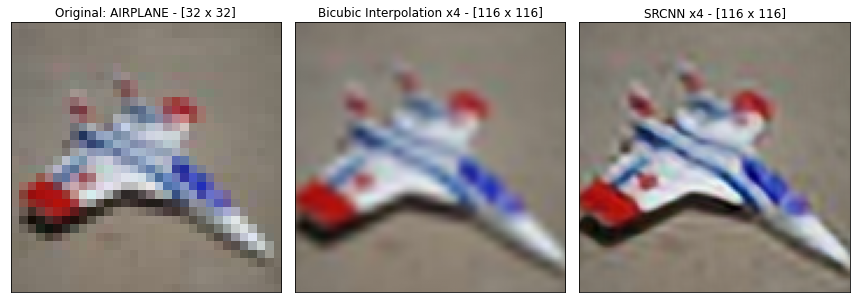

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


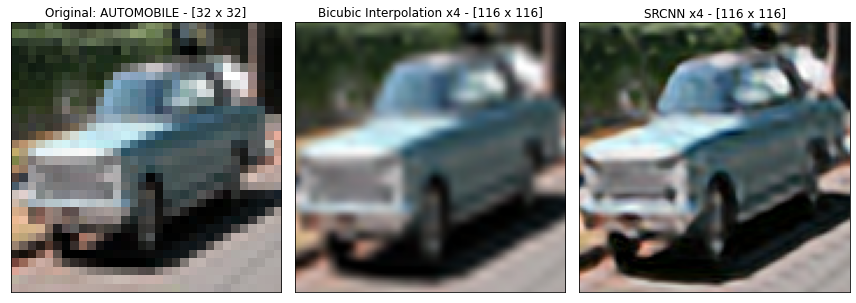

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


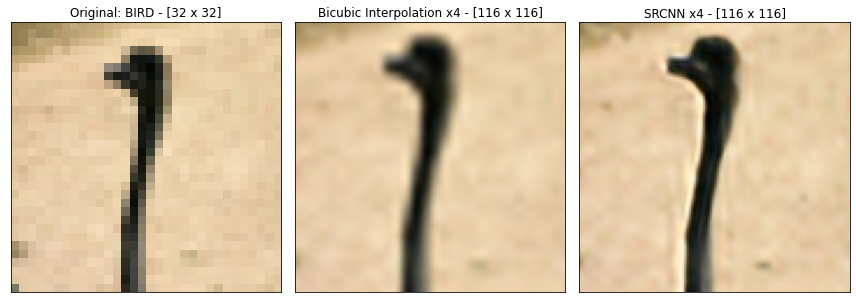

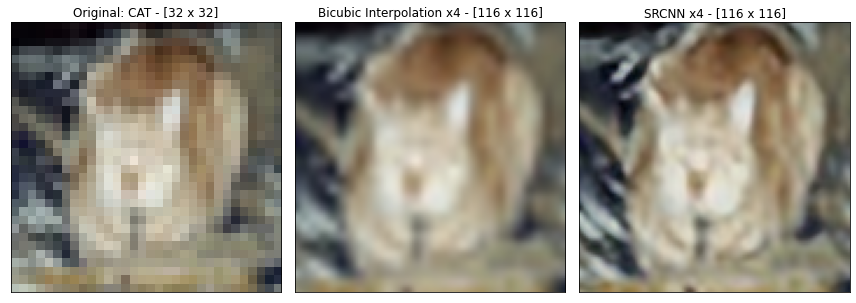

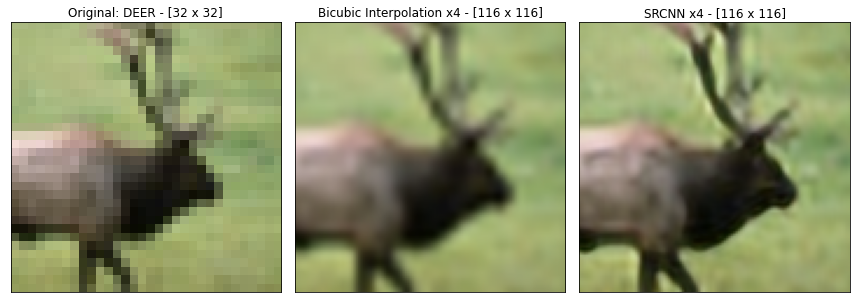

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


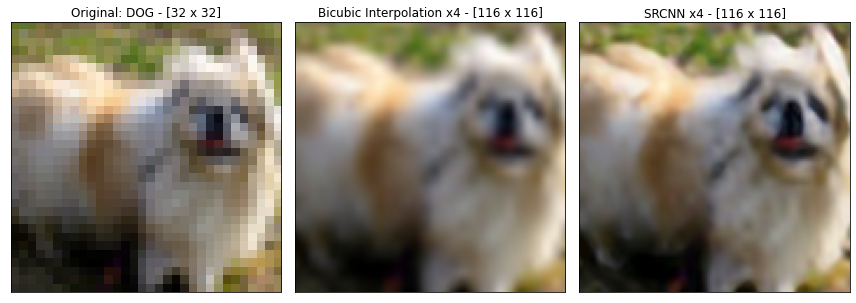

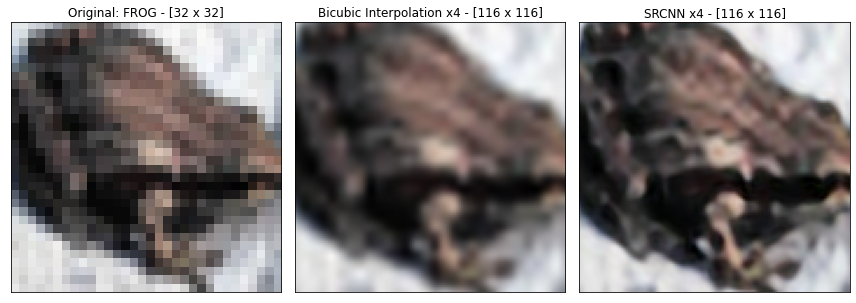

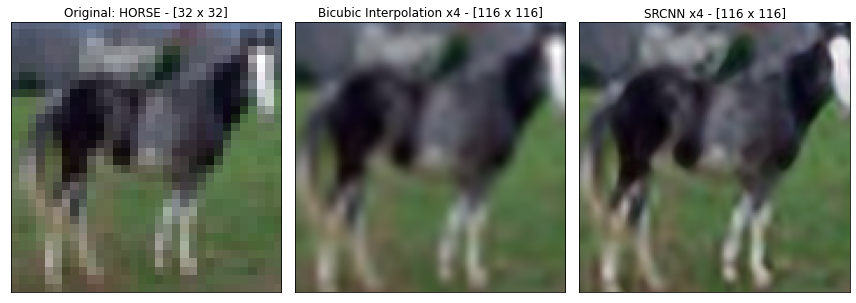

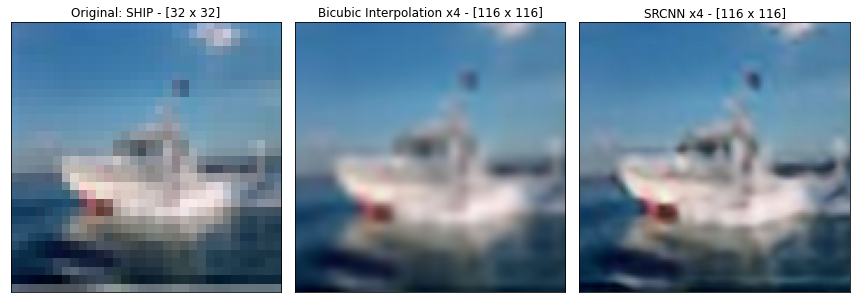

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


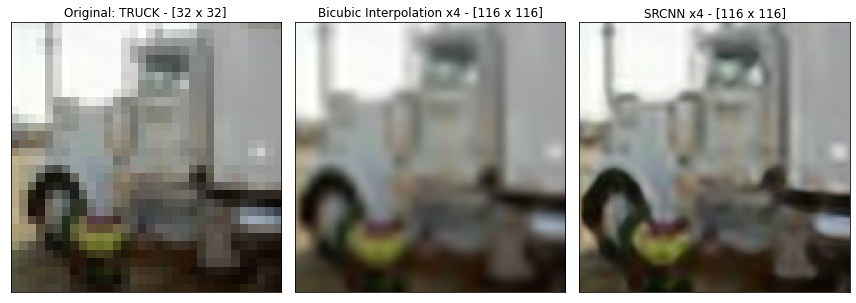

In [18]:
for label, image_raw, image_pred, image_scale in zip(label_list, list(im_list), list(im_pred), list(im_scale)):
    n_compare(
        im_list=[image_raw, image_scale, image_pred],
        label_list=[f'Original: {label.upper()} - [{image_raw.shape[1]} x {image_raw.shape[0]}]',
                    f'Bicubic Interpolation x{scaling_factor} - [{image_scale.shape[1]} x {image_scale.shape[0]}]',
                    f'SRCNN x{scaling_factor} - [{image_pred.shape[1]} x {image_pred.shape[0]}]'],
        figsize=(12,5))
    
    im = Image.fromarray(np.uint8(image_pred*255))
    im.save(f"results/{im_prefix}{label}.png")

In [5]:
## Results sorted (by PSNR improvement)
### Data not augemnted
#### Using original data (no augmentation)
col_names = ['Scaling factor', 'Image Set', 'f_1', 'f_3', 'n_1', 'n_2', 'n_nonlin', 'Bicubic - PSNR (mean)', 'SRCNN - PSNR (mean)', 'PSNR Mean Improvement', 'Bicubic - SSIM (mean)', 'SRCNN - SSIM (mean)', 'SSIM Mean Improvement']

s = """| $2\times$ | Set14 | 9 / 7 / 64 / 32 / 1 | $23.18$ dB | $24.38$ dB | $+1.21$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 4 | $23.54$ dB | $24.37$ dB | $+0.83$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 64 / 1 | $23.18$ dB | $24.37$ dB | $+1.19$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 64 / 1 | $23.54$ dB | $24.36$ dB | $+0.82$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 64 / 64 / 1 | $23.18$ dB | $24.35$ dB | $+1.17$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 64 / 32 / 4 | $23.18$ dB | $24.34$ dB | $+1.17$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 8 | $23.54$ dB | $24.34$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 32 / 8 | $23.18$ dB | $24.34$ dB | $+1.16$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 1 | $23.54$ dB | $24.33$ dB | $+0.79$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 64 / 1 | $23.18$ dB | $24.33$ dB | $+1.15$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 128 / 1 | $23.18$ dB | $24.33$ dB | $+1.15$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 64 / 4 | $23.18$ dB | $24.33$ dB | $+1.16$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 64 / 1 | $23.53$ dB | $24.33$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 64 / 4 | $23.53$ dB | $24.33$ dB | $+0.80$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 1 | $23.54$ dB | $24.33$ dB | $+0.79$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 32 / 4 | $23.54$ dB | $24.32$ dB | $+0.79$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 32 / 1 | $23.54$ dB | $24.32$ dB | $+0.79$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 64 / 8 | $23.54$ dB | $24.32$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 32 / 8 | $23.18$ dB | $24.32$ dB | $+1.15$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 128 / 4 | $23.54$ dB | $24.32$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 32 / 8 | $23.54$ dB | $24.32$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 128 / 1 | $23.54$ dB | $24.31$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 64 / 64 / 4 | $23.54$ dB | $24.31$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 32 / 1 | $23.54$ dB | $24.31$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 32 / 1 | $23.53$ dB | $24.31$ dB | $+0.77$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 32 / 4 | $23.53$ dB | $24.31$ dB | $+0.77$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 32 / 8 | $23.53$ dB | $24.30$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 32 / 4 | $23.17$ dB | $24.30$ dB | $+1.14$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 32 / 8 | $23.17$ dB | $24.30$ dB | $+1.13$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 64 / 1 | $23.54$ dB | $24.30$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 64 / 64 / 8 | $23.53$ dB | $24.30$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 32 / 1 | $23.53$ dB | $24.30$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 64 / 32 / 4 | $23.53$ dB | $24.30$ dB | $+0.77$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 128 / 4 | $23.17$ dB | $24.30$ dB | $+1.13$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 5 / 64 / 32 / 8 | $23.53$ dB | $24.29$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 64 / 64 / 1 | $23.53$ dB | $24.29$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 64 / 64 / 4 | $23.53$ dB | $24.29$ dB | $+0.75$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 64 / 32 / 8 | $23.18$ dB | $24.29$ dB | $+1.12$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 128 / 4 | $23.54$ dB | $24.29$ dB | $+0.75$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 128 / 8 | $23.54$ dB | $24.28$ dB | $+0.75$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 32 / 4 | $23.53$ dB | $24.28$ dB | $+0.74$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 128 / 8 | $23.54$ dB | $24.28$ dB | $+0.74$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 128 / 4 | $23.18$ dB | $24.28$ dB | $+1.11$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 64 / 64 / 8 | $23.18$ dB | $24.28$ dB | $+1.10$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 32 / 1 | $23.18$ dB | $24.28$ dB | $+1.11$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 32 / 4 | $23.54$ dB | $24.28$ dB | $+0.74$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 128 / 1 | $23.18$ dB | $24.28$ dB | $+1.10$ dB | $0.64$ | $0.68$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 64 / 8 | $23.54$ dB | $24.27$ dB | $+0.73$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 32 / 1 | $23.18$ dB | $24.27$ dB | $+1.10$ dB | $0.64$ | $0.68$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 32 / 4 | $23.18$ dB | $24.27$ dB | $+1.09$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 64 / 8 | $23.18$ dB | $24.26$ dB | $+1.09$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 64 / 4 | $23.54$ dB | $24.25$ dB | $+0.71$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 64 / 4 | $23.54$ dB | $24.24$ dB | $+0.70$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 128 / 8 | $23.17$ dB | $24.24$ dB | $+1.08$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 11 / 64 / 32 / 1 | $23.15$ dB | $24.24$ dB | $+1.09$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 128 / 8 | $23.18$ dB | $24.21$ dB | $+1.04$ dB | $0.64$ | $0.68$ | $+0.04$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 32 / 8 | $23.54$ dB | $24.21$ dB | $+0.67$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 9 / 7 / 64 / 64 / 4 | $23.18$ dB | $24.20$ dB | $+1.03$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 128 / 32 / 8 | $23.54$ dB | $24.14$ dB | $+0.60$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 64 / 32 / 1 | $23.53$ dB | $24.11$ dB | $+0.58$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 128 / 8 | $23.18$ dB | $24.03$ dB | $+0.85$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 128 / 4 | $23.18$ dB | $23.98$ dB | $+0.80$ dB | $0.64$ | $0.68$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 7 / 128 / 32 / 4 | $23.18$ dB | $11.50$ dB | $-11.67$ dB | $0.64$ | $0.47$ | $-0.17$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 32 / 8 | $23.53$ dB | $24.09$ dB | $+0.55$ dB | $0.65$ | $0.68$ | $+0.03$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 64 / 8 | $23.53$ dB | $24.22$ dB | $+0.68$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 128 / 4 | $23.53$ dB | $nan$ dB | $nan$ dB | $0.65$ | $nan$ | $+nan$ |
| $2\times$ | Set14 | 13 / 5 / 128 / 128 / 8 | $23.53$ dB | $24.25$ dB | $+0.71$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 64 / 1 | $23.53$ dB | $24.28$ dB | $+0.75$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 64 / 4 | $23.53$ dB | $24.32$ dB | $+0.78$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 64 / 8 | $23.53$ dB | $24.21$ dB | $+0.68$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 128 / 1 | $23.53$ dB | $24.30$ dB | $+0.76$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 128 / 4 | $23.53$ dB | $24.30$ dB | $+0.77$ dB | $0.65$ | $0.69$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 5 / 256 / 128 / 8 | $23.53$ dB | $11.49$ dB | $-12.04$ dB | $0.65$ | $0.46$ | $-0.19$ |
| $2\times$ | Set14 | 13 / 7 / 64 / 32 / 1 | $23.17$ dB | $24.30$ dB | $+1.14$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 64 / 32 / 4 | $23.17$ dB | $24.36$ dB | $+1.19$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 64 / 32 / 8 | $23.17$ dB | $11.50$ dB | $+-11.67$ dB | $0.64$ | $0.47$ | $+-0.17$ |
| $2\times$ | Set14 | 13 / 7 / 64 / 64 / 1 | $23.17$ dB | $24.34$ dB | $+1.17$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 64 / 64 / 4 | $23.17$ dB | $24.29$ dB | $+1.13$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 64 / 64 / 8 | $23.17$ dB | $23.98$ dB | $+0.81$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 32 / 1 | $23.17$ dB | $24.31$ dB | $+1.15$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 32 / 4 | $23.17$ dB | $10.63$ dB | $-12.54$ dB | $0.64$ | $0.46$ | $-0.18$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 32 / 8 | $23.17$ dB | $24.14$ dB | $+0.97$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 64 / 1 | $23.17$ dB | $24.30$ dB | $+1.14$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 64 / 4 | $23.17$ dB | $24.24$ dB | $+1.07$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 64 / 8 | $23.17$ dB | $24.24$ dB | $+1.07$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 128 / 1 | $23.17$ dB | $24.34$ dB | $+1.17$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 128 / 4 | $23.17$ dB | $24.30$ dB | $+1.13$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 128 / 128 / 8 | $23.17$ dB | $24.26$ dB | $+1.10$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 32 / 1 | $23.17$ dB | $24.29$ dB | $+1.12$ dB | $0.64$ | $0.68$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 64 / 1 | $23.17$ dB | $24.32$ dB | $+1.16$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 64 / 4 | $23.17$ dB | $24.34$ dB | $+1.17$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 64 / 8 | $23.17$ dB | $nan$ dB | $nan$ dB | $0.64$ | $nan$ | $+nan$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 128 / 1 | $23.17$ dB | $24.30$ dB | $+1.13$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 7 / 256 / 128 / 4 | $23.17$ dB | $24.27$ dB | $+1.10$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 11 / 64 / 32 / 4 | $23.15$ dB | $24.21$ dB | $+1.06$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 11 / 64 / 32 / 8 | $23.15$ dB | $24.17$ dB | $+1.01$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 11 / 64 / 64 / 1 | $23.15$ dB | $24.09$ dB | $+0.94$ dB | $0.64$ | $0.68$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 11 / 64 / 64 / 4 | $23.15$ dB | $24.20$ dB | $+1.05$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 11 / 64 / 64 / 8 | $23.15$ dB | $23.97$ dB | $+0.82$ dB | $0.64$ | $0.68$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 11 / 128 / 32 / 1 | $23.15$ dB | $23.80$ dB | $+0.65$ dB | $0.64$ | $0.68$ | $+0.04$ |
| $2\times$ | Set14 | 13 / 11 / 128 / 32 / 4 | $23.15$ dB | $8.09$ dB | $-15.06$ dB | $0.64$ | $0.24$ | $-0.40$ |
| $2\times$ | Set14 | 13 / 11 / 128 / 32 / 8 | $23.15$ dB | $24.26$ dB | $+1.11$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 11 / 128 / 64 / 1 | $23.15$ dB | $nan$ dB | $nan$ dB | $0.64$ | $nan$ | $+nan$ |
| $2\times$ | Set14 | 13 / 11 / 128 / 64 / 4 | $23.15$ dB | $24.05$ dB | $+0.90$ dB | $0.64$ | $0.68$ | $+0.05$ |
| $2\times$ | Set14 | 13 / 11 / 128 / 64 / 8 | $23.15$ dB | $24.25$ dB | $+1.09$ dB | $0.64$ | $0.69$ | $+0.05$ |
| $2\times$ | Set14 | 9 / 5 / 256 / 128 / 1 | $23.54$ dB | $11.50$ dB | $-12.04$ dB | $0.65$ | $0.47$ | $-0.18$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 64 / 4 | $23.18$ dB | $11.50$ dB | $-11.68$ dB | $0.64$ | $0.47$ | $+-0.17$ |
| $2\times$ | Set14 | 9 / 7 / 256 / 64 / 8 | $23.18$ dB | $11.50$ dB | $-11.68$ dB | $0.64$ | $0.47$ | $-0.17$ |"""

In [6]:
s1 = s.replace('$', '')
s2 = s1.replace('|', ',')
s3 = s2.replace(', 2	imes , Set14 , ', '')
s4 = s3.replace(' /', ',')
s5 = s4.replace(' dB ', '')
s6 = s5.replace('+', '')
print(s6)

9, 7, 64, 32, 1 , 23.18, 24.38, 1.21, 0.64 , 0.69 , 0.05 ,
9, 5, 64, 32, 4 , 23.54, 24.37, 0.83, 0.65 , 0.69 , 0.04 ,
9, 7, 128, 64, 1 , 23.18, 24.37, 1.19, 0.64 , 0.69 , 0.05 ,
9, 5, 256, 64, 1 , 23.54, 24.36, 0.82, 0.65 , 0.69 , 0.04 ,
9, 7, 64, 64, 1 , 23.18, 24.35, 1.17, 0.64 , 0.69 , 0.05 ,
9, 7, 64, 32, 4 , 23.18, 24.34, 1.17, 0.64 , 0.69 , 0.05 ,
9, 5, 64, 64, 8 , 23.54, 24.34, 0.80, 0.65 , 0.69 , 0.04 ,
9, 7, 256, 32, 8 , 23.18, 24.34, 1.16, 0.64 , 0.69 , 0.05 ,
9, 5, 64, 32, 1 , 23.54, 24.33, 0.79, 0.65 , 0.69 , 0.04 ,
9, 7, 256, 64, 1 , 23.18, 24.33, 1.15, 0.64 , 0.69 , 0.05 ,
9, 7, 256, 128, 1 , 23.18, 24.33, 1.15, 0.64 , 0.69 , 0.05 ,
9, 7, 128, 64, 4 , 23.18, 24.33, 1.16, 0.64 , 0.69 , 0.05 ,
13, 5, 128, 64, 1 , 23.53, 24.33, 0.80, 0.65 , 0.69 , 0.04 ,
13, 5, 128, 64, 4 , 23.53, 24.33, 0.80, 0.65 , 0.69 , 0.04 ,
9, 5, 64, 64, 1 , 23.54, 24.33, 0.79, 0.65 , 0.69 , 0.04 ,
9, 5, 128, 32, 4 , 23.54, 24.32, 0.79, 0.65 , 0.69 , 0.04 ,
9, 5, 256, 32, 1 , 23.54, 24.32, 0.79, 0.65 

In [9]:
d = [[9, 7, 64, 32, 1 , 23.18, 24.38, 1.21, 0.64 , 0.69 , 0.05],
[9, 5, 64, 32, 4 , 23.54, 24.37, 0.83, 0.65 , 0.69 , 0.04],
[9, 7, 128, 64, 1 , 23.18, 24.37, 1.19, 0.64 , 0.69 , 0.05],
[9, 5, 256, 64, 1 , 23.54, 24.36, 0.82, 0.65 , 0.69 , 0.04],
[9, 7, 64, 64, 1 , 23.18, 24.35, 1.17, 0.64 , 0.69 , 0.05],
[9, 7, 64, 32, 4 , 23.18, 24.34, 1.17, 0.64 , 0.69 , 0.05],
[9, 5, 64, 64, 8 , 23.54, 24.34, 0.80, 0.65 , 0.69 , 0.04],
[9, 7, 256, 32, 8 , 23.18, 24.34, 1.16, 0.64 , 0.69 , 0.05],
[9, 5, 64, 32, 1 , 23.54, 24.33, 0.79, 0.65 , 0.69 , 0.04],
[9, 7, 256, 64, 1 , 23.18, 24.33, 1.15, 0.64 , 0.69 , 0.05],
[9, 7, 256, 128, 1 , 23.18, 24.33, 1.15, 0.64 , 0.69 , 0.05],
[9, 7, 128, 64, 4 , 23.18, 24.33, 1.16, 0.64 , 0.69 , 0.05],
[13, 5, 128, 64, 1 , 23.53, 24.33, 0.80, 0.65 , 0.69 , 0.04],
[13, 5, 128, 64, 4 , 23.53, 24.33, 0.80, 0.65 , 0.69 , 0.04],
[9, 5, 64, 64, 1 , 23.54, 24.33, 0.79, 0.65 , 0.69 , 0.04],
[9, 5, 128, 32, 4 , 23.54, 24.32, 0.79, 0.65 , 0.69 , 0.04],
[9, 5, 256, 32, 1 , 23.54, 24.32, 0.79, 0.65 , 0.69 , 0.04],
[9, 5, 256, 64, 8 , 23.54, 24.32, 0.78, 0.65 , 0.69 , 0.04],
[9, 7, 128, 32, 8 , 23.18, 24.32, 1.15, 0.64 , 0.69 , 0.05],
[9, 5, 128, 128, 4 , 23.54, 24.32, 0.78, 0.65 , 0.69 , 0.04],
[9, 5, 64, 32, 8 , 23.54, 24.32, 0.78, 0.65 , 0.69 , 0.04],
[9, 5, 128, 128, 1 , 23.54, 24.31, 0.78, 0.65 , 0.69 , 0.04],
[9, 5, 64, 64, 4 , 23.54, 24.31, 0.78, 0.65 , 0.69 , 0.04],
[9, 5, 128, 32, 1 , 23.54, 24.31, 0.78, 0.65 , 0.69 , 0.04],
[13, 5, 256, 32, 1 , 23.53, 24.31, 0.77, 0.65 , 0.69 , 0.04],
[13, 5, 256, 32, 4 , 23.53, 24.31, 0.77, 0.65 , 0.69 , 0.04],
[13, 5, 256, 32, 8 , 23.53, 24.30, 0.76, 0.65 , 0.69 , 0.04],
[13, 7, 256, 32, 4 , 23.17, 24.30, 1.14, 0.64 , 0.69 , 0.05],
[13, 7, 256, 32, 8 , 23.17, 24.30, 1.13, 0.64 , 0.69 , 0.05],
[9, 5, 128, 64, 1 , 23.54, 24.30, 0.76, 0.65 , 0.69 , 0.04],
[13, 5, 64, 64, 8 , 23.53, 24.30, 0.76, 0.65 , 0.69 , 0.04],
[13, 5, 128, 32, 1 , 23.53, 24.30, 0.76, 0.65 , 0.69 , 0.04],
[13, 5, 64, 32, 4 , 23.53, 24.30, 0.77, 0.65 , 0.69 , 0.04],
[13, 7, 128, 128, 4 , 23.17, 24.30, 1.13, 0.64 , 0.69 , 0.05],
[13, 5, 64, 32, 8 , 23.53, 24.29, 0.76, 0.65 , 0.69 , 0.04],
[13, 5, 64, 64, 1 , 23.53, 24.29, 0.76, 0.65 , 0.69 , 0.04],
[13, 5, 64, 64, 4 , 23.53, 24.29, 0.75, 0.65 , 0.69 , 0.04],
[9, 7, 64, 32, 8 , 23.18, 24.29, 1.12, 0.64 , 0.69 , 0.05],
[9, 5, 256, 128, 4 , 23.54, 24.29, 0.75, 0.65 , 0.69 , 0.04],
[9, 5, 128, 128, 8 , 23.54, 24.28, 0.75, 0.65 , 0.69 , 0.04],
[13, 5, 128, 32, 4 , 23.53, 24.28, 0.74, 0.65 , 0.69 , 0.04],
[9, 5, 256, 128, 8 , 23.54, 24.28, 0.74, 0.65 , 0.69 , 0.04],
[9, 7, 256, 128, 4 , 23.18, 24.28, 1.11, 0.64 , 0.69 , 0.05],
[9, 7, 64, 64, 8 , 23.18, 24.28, 1.10, 0.64 , 0.69 , 0.05],
[9, 7, 128, 32, 1 , 23.18, 24.28, 1.11, 0.64 , 0.69 , 0.05],
[9, 5, 256, 32, 4 , 23.54, 24.28, 0.74, 0.65 , 0.69 , 0.04],
[9, 7, 128, 128, 1 , 23.18, 24.28, 1.10, 0.64 , 0.68 , 0.05],
[9, 5, 128, 64, 8 , 23.54, 24.27, 0.73, 0.65 , 0.69 , 0.04],
[9, 7, 256, 32, 1 , 23.18, 24.27, 1.10, 0.64 , 0.68 , 0.05],
[9, 7, 256, 32, 4 , 23.18, 24.27, 1.09, 0.64 , 0.69 , 0.05],
[9, 7, 128, 64, 8 , 23.18, 24.26, 1.09, 0.64 , 0.69 , 0.05],
[9, 5, 256, 64, 4 , 23.54, 24.25, 0.71, 0.65 , 0.69 , 0.04],
[9, 5, 128, 64, 4 , 23.54, 24.24, 0.70, 0.65 , 0.69 , 0.04],
[13, 7, 256, 128, 8 , 23.17, 24.24, 1.08, 0.64 , 0.69 , 0.05],
[13, 11, 64, 32, 1 , 23.15, 24.24, 1.09, 0.64 , 0.69 , 0.05],
[9, 7, 128, 128, 8 , 23.18, 24.21, 1.04, 0.64 , 0.68 , 0.04],
[9, 5, 256, 32, 8 , 23.54, 24.21, 0.67, 0.65 , 0.68 , 0.03],
[9, 7, 64, 64, 4 , 23.18, 24.20, 1.03, 0.64 , 0.69 , 0.05],
[9, 5, 128, 32, 8 , 23.54, 24.14, 0.60, 0.65 , 0.69 , 0.04],
[13, 5, 64, 32, 1 , 23.53, 24.11, 0.58, 0.65 , 0.68 , 0.03],
[9, 7, 256, 128, 8 , 23.18, 24.03, 0.85, 0.64 , 0.69 , 0.05],
[9, 7, 128, 128, 4 , 23.18, 23.98, 0.80, 0.64 , 0.68 , 0.05],
[9, 7, 128, 32, 4 , 23.18, 11.50, -11.67, 0.64 , 0.47 , -0.17],
[13, 5, 128, 32, 8 , 23.53, 24.09, 0.55, 0.65 , 0.68 , 0.03],
[13, 5, 128, 64, 8 , 23.53, 24.22, 0.68, 0.65 , 0.69 , 0.04],
[13, 5, 128, 128, 4 , 23.53, np.nan, np.nan, 0.65 , np.nan , np.nan],
[13, 5, 128, 128, 8 , 23.53, 24.25, 0.71, 0.65 , 0.69 , 0.04],
[13, 5, 256, 64, 1 , 23.53, 24.28, 0.75, 0.65 , 0.69 , 0.04],
[13, 5, 256, 64, 4 , 23.53, 24.32, 0.78, 0.65 , 0.69 , 0.04],
[13, 5, 256, 64, 8 , 23.53, 24.21, 0.68, 0.65 , 0.69 , 0.04],
[13, 5, 256, 128, 1 , 23.53, 24.30, 0.76, 0.65 , 0.69 , 0.04],
[13, 5, 256, 128, 4 , 23.53, 24.30, 0.77, 0.65 , 0.69 , 0.04],
[13, 5, 256, 128, 8 , 23.53, 11.49, -12.04, 0.65 , 0.46 , -0.19],
[13, 7, 64, 32, 1 , 23.17, 24.30, 1.14, 0.64 , 0.69 , 0.05],
[13, 7, 64, 32, 4 , 23.17, 24.36, 1.19, 0.64 , 0.69 , 0.05],
[13, 7, 64, 32, 8 , 23.17, 11.50, -11.67, 0.64 , 0.47 , -0.17],
[13, 7, 64, 64, 1 , 23.17, 24.34, 1.17, 0.64 , 0.69 , 0.05],
[13, 7, 64, 64, 4 , 23.17, 24.29, 1.13, 0.64 , 0.69 , 0.05],
[13, 7, 64, 64, 8 , 23.17, 23.98, 0.81, 0.64 , 0.69 , 0.05],
[13, 7, 128, 32, 1 , 23.17, 24.31, 1.15, 0.64 , 0.69 , 0.05],
[13, 7, 128, 32, 4 , 23.17, 10.63, -12.54, 0.64 , 0.46 , -0.18],
[13, 7, 128, 32, 8 , 23.17, 24.14, 0.97, 0.64 , 0.69 , 0.05],
[13, 7, 128, 64, 1 , 23.17, 24.30, 1.14, 0.64 , 0.69 , 0.05],
[13, 7, 128, 64, 4 , 23.17, 24.24, 1.07, 0.64 , 0.69 , 0.05],
[13, 7, 128, 64, 8 , 23.17, 24.24, 1.07, 0.64 , 0.69 , 0.05],
[13, 7, 128, 128, 1 , 23.17, 24.34, 1.17, 0.64 , 0.69 , 0.05],
[13, 7, 128, 128, 4 , 23.17, 24.30, 1.13, 0.64 , 0.69 , 0.05],
[13, 7, 128, 128, 8 , 23.17, 24.26, 1.10, 0.64 , 0.69 , 0.05],
[13, 7, 256, 32, 1 , 23.17, 24.29, 1.12, 0.64 , 0.68 , 0.05],
[13, 7, 256, 64, 1 , 23.17, 24.32, 1.16, 0.64 , 0.69 , 0.05],
[13, 7, 256, 64, 4 , 23.17, 24.34, 1.17, 0.64 , 0.69 , 0.05],
[13, 7, 256, 64, 8 , 23.17, np.nan, np.nan, 0.64 , np.nan , np.nan],
[13, 7, 256, 128, 1 , 23.17, 24.30, 1.13, 0.64 , 0.69 , 0.05],
[13, 7, 256, 128, 4 , 23.17, 24.27, 1.10, 0.64 , 0.69 , 0.05],
[13, 11, 64, 32, 4 , 23.15, 24.21, 1.06, 0.64 , 0.69 , 0.05],
[13, 11, 64, 32, 8 , 23.15, 24.17, 1.01, 0.64 , 0.69 , 0.05],
[13, 11, 64, 64, 1 , 23.15, 24.09, 0.94, 0.64 , 0.68 , 0.04],
[13, 11, 64, 64, 4 , 23.15, 24.20, 1.05, 0.64 , 0.69 , 0.05],
[13, 11, 64, 64, 8 , 23.15, 23.97, 0.82, 0.64 , 0.68 , 0.04],
[13, 11, 128, 32, 1 , 23.15, 23.80, 0.65, 0.64 , 0.68 , 0.04],
[13, 11, 128, 32, 4 , 23.15, 8.09, -15.06, 0.64 , 0.24 , -0.40],
[13, 11, 128, 32, 8 , 23.15, 24.26, 1.11, 0.64 , 0.69 , 0.05],
[13, 11, 128, 64, 1 , 23.15, np.nan, np.nan, 0.64 , np.nan , np.nan],
[13, 11, 128, 64, 4 , 23.15, 24.05, 0.90, 0.64 , 0.68 , 0.05],
[13, 11, 128, 64, 8 , 23.15, 24.25, 1.09, 0.64 , 0.69 , 0.05],
[9, 5, 256, 128, 1 , 23.54, 11.50, -12.04, 0.65 , 0.47 , -0.18],
[9, 7, 256, 64, 4 , 23.18, 11.50, -11.68, 0.64 , 0.47 , -0.17],
[9, 7, 256, 64, 8 , 23.18, 11.50, -11.68, 0.64 , 0.47 , -0.17]]

df = pd.DataFrame(data=d, columns=col_names[2:])
df[col_names[0]] = 2
df[col_names[1]] = 'Set14'
df = df[col_names]
df

Scaling factor Image Set  f_1  f_3  n_1  n_2  n_nonlin  \
0                 2     Set14    9    7   64   32         1   
1                 2     Set14    9    5   64   32         4   
2                 2     Set14    9    7  128   64         1   
3                 2     Set14    9    5  256   64         1   
4                 2     Set14    9    7   64   64         1   
..              ...       ...  ...  ...  ...  ...       ...   
103               2     Set14   13   11  128   64         4   
104               2     Set14   13   11  128   64         8   
105               2     Set14    9    5  256  128         1   
106               2     Set14    9    7  256   64         4   
107               2     Set14    9    7  256   64         8   

     Bicubic - PSNR (mean)  SRCNN - PSNR (mean)  PSNR Mean Improvement  \
0                    23.18                24.38                   1.21   
1                    23.54                24.37                   0.83   
2                    23.18                24.37                   1.19   
3                    23.54                24.36                   0.82   
4                    23.18                24.35                   1.17   
..                     ...                  ...                    ...   
103                  23.15                24.05                   0.90   
104                  23.15                24.25                   1.09   
105                  23.54                11.50                 -12.04   
106                  23.18                11.50                 -11.68   
107                  23.18                11.50                 -11.68   

     Bicubic - SSIM (mean)  SRCNN - SSIM (mean)  SSIM Mean Improvement  
0                     0.64                 0.69                   0.05  
1                     0.65                 0.69                   0.04  
2                     0.64                 0.69                   0.05  
3                     0.65                 0.69                   0.04  
4                     0.64                 0.69                   0.05  
..                     ...                  ...                    ...  
103                   0.64                 0.68                   0.05  
104                   0.64                 0.69                   0.05  
105                   0.65                 0.47                  -0.18  
106                   0.64                 0.47                  -0.17  
107                   0.64                 0.47                  -0.17  

[108 rows x 13 columns]

In [25]:
df.sort_values(by='SRCNN - PSNR (mean)', ascending=True)

Scaling factor Image Set  f_1  f_3  n_1  n_2  n_nonlin  \
100               2     Set14   13   11  128   32         4   
80                2     Set14   13    7  128   32         4   
72                2     Set14   13    5  256  128         8   
107               2     Set14    9    7  256   64         8   
62                2     Set14    9    7  128   32         4   
..              ...       ...  ...  ...  ...  ...       ...   
1                 2     Set14    9    5   64   32         4   
0                 2     Set14    9    7   64   32         1   
65                2     Set14   13    5  128  128         4   
91                2     Set14   13    7  256   64         8   
102               2     Set14   13   11  128   64         1   

     Bicubic - PSNR (mean)  SRCNN - PSNR (mean)  PSNR Mean Improvement  \
100                  23.15                 8.09                 -15.06   
80                   23.17                10.63                 -12.54   
72                   23.53                11.49                 -12.04   
107                  23.18                11.50                 -11.68   
62                   23.18                11.50                 -11.67   
..                     ...                  ...                    ...   
1                    23.54                24.37                   0.83   
0                    23.18                24.38                   1.21   
65                   23.53                  NaN                    NaN   
91                   23.17                  NaN                    NaN   
102                  23.15                  NaN                    NaN   

     Bicubic - SSIM (mean)  SRCNN - SSIM (mean)  SSIM Mean Improvement  
100                   0.64                 0.24                  -0.40  
80                    0.64                 0.46                  -0.18  
72                    0.65                 0.46                  -0.19  
107                   0.64                 0.47                  -0.17  
62                    0.64                 0.47                  -0.17  
..                     ...                  ...                    ...  
1                     0.65                 0.69                   0.04  
0                     0.64                 0.69                   0.05  
65                    0.65                  NaN                    NaN  
91                    0.64                  NaN                    NaN  
102                   0.64                  NaN                    NaN  

[108 rows x 13 columns]

In [19]:
df.groupby(['f_1', 'f_3']).agg({'SRCNN - PSNR (mean)':'mean'}).sort_values(by='SRCNN - PSNR (mean)', ascending=False)

SRCNN - PSNR (mean)
f_1 f_3                     
9   5              23.762500
13  5              23.690909
    7              23.174583
9   7              22.675833
13  11             22.666364

In [20]:
df.groupby(['n_1', 'n_2']).agg({'SRCNN - PSNR (mean)':'mean'}).sort_values(by='SRCNN - PSNR (mean)', ascending=False)

SRCNN - PSNR (mean)
n_1 n_2                     
256 32             24.291667
128 64             24.266429
    128            24.257273
64  64             24.237333
    32             23.434000
256 128            22.134167
    64             21.975455
128 32             21.384667

In [22]:
df.loc[(df['n_1']==256)&(df['n_2']==32)].sort_values(by='SRCNN - PSNR (mean)', ascending=False)

Scaling factor Image Set  f_1  f_3  n_1  n_2  n_nonlin  \
7                2     Set14    9    7  256   32         8   
16               2     Set14    9    5  256   32         1   
24               2     Set14   13    5  256   32         1   
25               2     Set14   13    5  256   32         4   
26               2     Set14   13    5  256   32         8   
27               2     Set14   13    7  256   32         4   
28               2     Set14   13    7  256   32         8   
88               2     Set14   13    7  256   32         1   
45               2     Set14    9    5  256   32         4   
48               2     Set14    9    7  256   32         1   
49               2     Set14    9    7  256   32         4   
56               2     Set14    9    5  256   32         8   

    Bicubic - PSNR (mean)  SRCNN - PSNR (mean)  PSNR Mean Improvement  \
7                   23.18                24.34                   1.16   
16                  23.54                24.32                   0.79   
24                  23.53                24.31                   0.77   
25                  23.53                24.31                   0.77   
26                  23.53                24.30                   0.76   
27                  23.17                24.30                   1.14   
28                  23.17                24.30                   1.13   
88                  23.17                24.29                   1.12   
45                  23.54                24.28                   0.74   
48                  23.18                24.27                   1.10   
49                  23.18                24.27                   1.09   
56                  23.54                24.21                   0.67   

    Bicubic - SSIM (mean)  SRCNN - SSIM (mean)  SSIM Mean Improvement  
7                    0.64                 0.69                   0.05  
16                   0.65                 0.69                   0.04  
24                   0.65                 0.69                   0.04  
25                   0.65                 0.69                   0.04  
26                   0.65                 0.69                   0.04  
27                   0.64                 0.69                   0.05  
28                   0.64                 0.69                   0.05  
88                   0.64                 0.68                   0.05  
45                   0.65                 0.69                   0.04  
48                   0.64                 0.68                   0.05  
49                   0.64                 0.69                   0.05  
56                   0.65                 0.68                   0.03

In [23]:
df.loc[(df['f_1']==9)&(df['f_3']==5)].sort_values(by='SRCNN - PSNR (mean)', ascending=False)

Scaling factor Image Set  f_1  f_3  n_1  n_2  n_nonlin  \
1                 2     Set14    9    5   64   32         4   
3                 2     Set14    9    5  256   64         1   
6                 2     Set14    9    5   64   64         8   
8                 2     Set14    9    5   64   32         1   
14                2     Set14    9    5   64   64         1   
15                2     Set14    9    5  128   32         4   
16                2     Set14    9    5  256   32         1   
17                2     Set14    9    5  256   64         8   
19                2     Set14    9    5  128  128         4   
20                2     Set14    9    5   64   32         8   
22                2     Set14    9    5   64   64         4   
23                2     Set14    9    5  128   32         1   
21                2     Set14    9    5  128  128         1   
29                2     Set14    9    5  128   64         1   
38                2     Set14    9    5  256  128         4   
39                2     Set14    9    5  128  128         8   
41                2     Set14    9    5  256  128         8   
45                2     Set14    9    5  256   32         4   
47                2     Set14    9    5  128   64         8   
51                2     Set14    9    5  256   64         4   
52                2     Set14    9    5  128   64         4   
56                2     Set14    9    5  256   32         8   
58                2     Set14    9    5  128   32         8   
105               2     Set14    9    5  256  128         1   

     Bicubic - PSNR (mean)  SRCNN - PSNR (mean)  PSNR Mean Improvement  \
1                    23.54                24.37                   0.83   
3                    23.54                24.36                   0.82   
6                    23.54                24.34                   0.80   
8                    23.54                24.33                   0.79   
14                   23.54                24.33                   0.79   
15                   23.54                24.32                   0.79   
16                   23.54                24.32                   0.79   
17                   23.54                24.32                   0.78   
19                   23.54                24.32                   0.78   
20                   23.54                24.32                   0.78   
22                   23.54                24.31                   0.78   
23                   23.54                24.31                   0.78   
21                   23.54                24.31                   0.78   
29                   23.54                24.30                   0.76   
38                   23.54                24.29                   0.75   
39                   23.54                24.28                   0.75   
41                   23.54                24.28                   0.74   
45                   23.54                24.28                   0.74   
47                   23.54                24.27                   0.73   
51                   23.54                24.25                   0.71   
52                   23.54                24.24                   0.70   
56                   23.54                24.21                   0.67   
58                   23.54                24.14                   0.60   
105                  23.54                11.50                 -12.04   

     Bicubic - SSIM (mean)  SRCNN - SSIM (mean)  SSIM Mean Improvement  
1                     0.65                 0.69                   0.04  
3                     0.65                 0.69                   0.04  
6                     0.65                 0.69                   0.04  
8                     0.65                 0.69                   0.04  
14                    0.65                 0.69                   0.04  
15                    0.65                 0.69                   0.04  
16                    0.65                 0.69                   0

In [24]:
df.loc[df['SRCNN - PSNR (mean)']>=24.33].sort_values(by='SRCNN - PSNR (mean)', ascending=False)

Scaling factor Image Set  f_1  f_3  n_1  n_2  n_nonlin  \
0                2     Set14    9    7   64   32         1   
1                2     Set14    9    5   64   32         4   
2                2     Set14    9    7  128   64         1   
3                2     Set14    9    5  256   64         1   
74               2     Set14   13    7   64   32         4   
4                2     Set14    9    7   64   64         1   
85               2     Set14   13    7  128  128         1   
76               2     Set14   13    7   64   64         1   
90               2     Set14   13    7  256   64         4   
7                2     Set14    9    7  256   32         8   
6                2     Set14    9    5   64   64         8   
5                2     Set14    9    7   64   32         4   
8                2     Set14    9    5   64   32         1   
10               2     Set14    9    7  256  128         1   
11               2     Set14    9    7  128   64         4   
12               2     Set14   13    5  128   64         1   
13               2     Set14   13    5  128   64         4   
14               2     Set14    9    5   64   64         1   
9                2     Set14    9    7  256   64         1   

    Bicubic - PSNR (mean)  SRCNN - PSNR (mean)  PSNR Mean Improvement  \
0                   23.18                24.38                   1.21   
1                   23.54                24.37                   0.83   
2                   23.18                24.37                   1.19   
3                   23.54                24.36                   0.82   
74                  23.17                24.36                   1.19   
4                   23.18                24.35                   1.17   
85                  23.17                24.34                   1.17   
76                  23.17                24.34                   1.17   
90                  23.17                24.34                   1.17   
7                   23.18                24.34                   1.16   
6                   23.54                24.34                   0.80   
5                   23.18                24.34                   1.17   
8                   23.54                24.33                   0.79   
10                  23.18                24.33                   1.15   
11                  23.18                24.33                   1.16   
12                  23.53                24.33                   0.80   
13                  23.53                24.33                   0.80   
14                  23.54                24.33                   0.79   
9                   23.18                24.33                   1.15   

    Bicubic - SSIM (mean)  SRCNN - SSIM (mean)  SSIM Mean Improvement  
0                    0.64                 0.69                   0.05  
1                    0.65                 0.69                   0.04  
2                    0.64                 0.69                   0.05  
3                    0.65                 0.69                   0.04  
74                   0.64                 0.69                   0.05  
4                    0.64                 0.69                   0.05  
85                   0.64                 0.69                   0.05  
76                   0.64                 0.69                   0.05  
90                   0.64                 0.69                   0.05  
7                    0.64                 0.69                   0.05  
6                    0.65                 0.69                   0.04  
5                    0.64                 0.69                   0.05  
8                    0.65                 0.69                   0.04  
10                   0.64                 0.69                   0.05  
11                   0.64                 0.69                   0.05  
12                   0.65                 0.69                   0.04  
13                   0.65                 0.69                   0.04  
14    